In [75]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl

con = duckdb.connect(database=':memory:')

stables = set(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy'])
lags = 60

con.execute('''
    create or replace table coins as
    select distinct on (ts, symbol)
        timestamp as ts,
        regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
        price as close,
        -- volume in USD
        total_volume as volume
    from read_parquet('pd-data/*.parquet', filename=true)
    where symbol not in ?
      and price is not null
      and total_volume > 0
    order by ts desc
''', [tuple(stables)])

con.sql('''
    create index ts_coins on coins(ts);
    create index sym_coins on coins(symbol);
    create unique index sym_ts_coins on coins(symbol, ts);
''')

con.execute('''
    create or replace table open as
    select
        c.ts,
        c.symbol,
        c.close,
        -- crypto trades 24/7 yesterday's close = today's open
        cc.close as open,
        c.volume
    from coins c
    asof join coins cc
        on c.symbol = cc.symbol
        and cc.ts < c.ts
    where c.ts - cc.ts <= interval '25 hour';
    
    create index ts_open on open(ts);
    create index sym_open on open(symbol);
    create unique index sym_ts_open on open(symbol, ts);
''')

con.execute('''
    create or replace table momentum as 
    with params as (
        select
            unnest([1,2,3,4,5,10,15,20,30,60]) as lag
    )
    select
        td.ts,
        td.symbol,
        ln(td.close / td.open) as ret,
        p.lag,
        ln(td.open / hori.open) as mom
    from open td
    cross join params p
    asof join open hori
        on td.symbol = hori.symbol
        and hori.ts <= td.ts - (p.lag * interval '1 day')
    where td.close is not null 
      and td.open is not null
      and hori.close is not null
''')#, [lags])

con.sql('''
    create index ts_mom on momentum(ts);
    create index sym_mom on momentum(symbol);
    create unique index sym_ts_lag_mom on momentum(symbol, lag, ts);
''')

con.sql('''
    create or replace table benchmark as
    select
        year(ts) as year,
        sum(ln(close / open)) as ret
    from open
    where symbol = 'btc'
    group by year;
    
    create unique index yr_bench on benchmark(year);
''')

con.sql('''
    create or replace table volume as
    with vol as (
        select
            ts,
            symbol,
            sum(volume) over (partition by ts) as total,
            volume::double / total as rel,
            volume::double as abs
        from coins
    )        
    select
        td.ts,
        td.symbol,
        yd.total as sum_yd,
        yd.abs as abs_yd,
        yd.rel as rel_yd,
        td.rel as rel_td
    from vol td
    asof join vol yd
        on yd.symbol = td.symbol
        and yd.ts <= td.ts - interval '1 day'
    where td.ts - yd.ts <= interval '25 hours';
    
    create unique index rv_ts_sym on volume(ts, symbol);
    create index rv_sym on volume(symbol);
''')

con.sql('''
create or replace table sma as
select
    c.ts,
    c.symbol,
    avg(volume) over w20 as vol20,
    avg(volume) over w50 as vol50,
    avg(volume) over w100 as vol100,
    avg(volume) over w200 as vol200,

    avg(rel_td) over w20 as relvol20,
    avg(rel_td) over w50 as relvol50,
    avg(rel_td) over w100 as relvol100,
    avg(rel_td) over w200 as relvol200,

    avg(close) over w20 as close20,
    avg(close) over w50 as close50,
    avg(close) over w100 as close100,
    avg(close) over w200 as close200
from coins c
join volume on volume.ts = c.ts and volume.symbol = c.symbol
window
    w20 as (partition by c.symbol order by c.ts rows between 20 preceding and 1 preceding),
    w50 as (partition by c.symbol order by c.ts rows between 50 preceding and 1 preceding),
    w100 as (partition by c.symbol order by c.ts rows between 100 preceding and 1 preceding),
    w200 as (partition by c.symbol order by c.ts rows between 200 preceding and 1 preceding)
order by c.ts
''')

emas = con.sql("""
    select
        c.ts,
        c.symbol,
        c.close,
        v.rel_td,
        c.volume
    from coins c
    join volume v on v.ts = c.ts and v.symbol = c.symbol
    order by c.symbol, c.ts
""").pl().with_columns([
    pl.col("close")
        .ewm_mean(span=5, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("close_ema5"),
    pl.col("close")
        .ewm_mean(span=60, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("close_ema60"),

    pl.col("volume")
        .ewm_mean(span=5, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("vol_ema5"),
    pl.col("volume")
        .ewm_mean(span=60, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("vol_ema60"),

    pl.col("rel_td")
        .ewm_mean(span=5, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("relvol_ema5"),
    pl.col("rel_td")
        .ewm_mean(span=60, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("relvol_ema60"),
])
con.execute("""
    create or replace table ema as select * from emas
""")

del emas

In [ ]:
# short term mean reversal strategy (vibe coded)

# 1. Calculate Sharpe by Lag
def get_sharpe(series):
    if len(series) < 100: return 0
    ann_ret = series.mean() * 365
    ann_vol = series.std() * np.sqrt(365)
    return ann_ret / ann_vol if ann_vol > 0 else 0

rev_stats = df_rev.groupby('lag')['strat_ret'].apply(get_sharpe)

# 2. Visualization: The Reversion Curve
plt.figure(figsize=(12, 5))

# Plot bars
colors = ['#d62728' if x < 0 else '#2ca02c' for x in rev_stats]
plt.bar(rev_stats.index, rev_stats, color=colors)

plt.title('Mean Reversion (Buy Bottom 10%) Sharpe Ratio by Lag')
plt.xlabel('Lookback Window (Days)')
plt.ylabel('Sharpe Ratio')
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', alpha=0.3)

# Highlight the common "Reversion Zone"
plt.axvspan(1, 7, color='yellow', alpha=0.1, label='Short-Term Zone')
plt.legend()
plt.show()

# 3. Best Reversion Lag Performance
best_rev_lag = rev_stats.idxmax()
best_rev_sharpe = rev_stats.max()

print(f"Best Reversion Lag: {best_rev_lag} Days")
print(f"Best Reversion Sharpe: {best_rev_sharpe:.2f}")

# Compare Equity Curves
rev_curve = df_rev[df_rev['lag'] == best_rev_lag].set_index('ts').sort_index()
rev_curve['cum_ret'] = rev_curve['strat_ret'].cumsum()

# Compare against BTC
btc = con.sql("SELECT ts, sum(ln(close/open)) as ret FROM open WHERE symbol='btc' GROUP BY ts ORDER BY ts").df().set_index('ts')
btc['cum_ret'] = btc['ret'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(rev_curve.index, rev_curve['cum_ret'], label=f'Reversion Strategy (Lag {best_rev_lag})', color='#d62728')
plt.plot(btc.index, btc['cum_ret'], label='Bitcoin', linestyle='--', color='gray', alpha=0.6)
plt.title(f'Mean Reversion (Buy Losers) vs BTC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

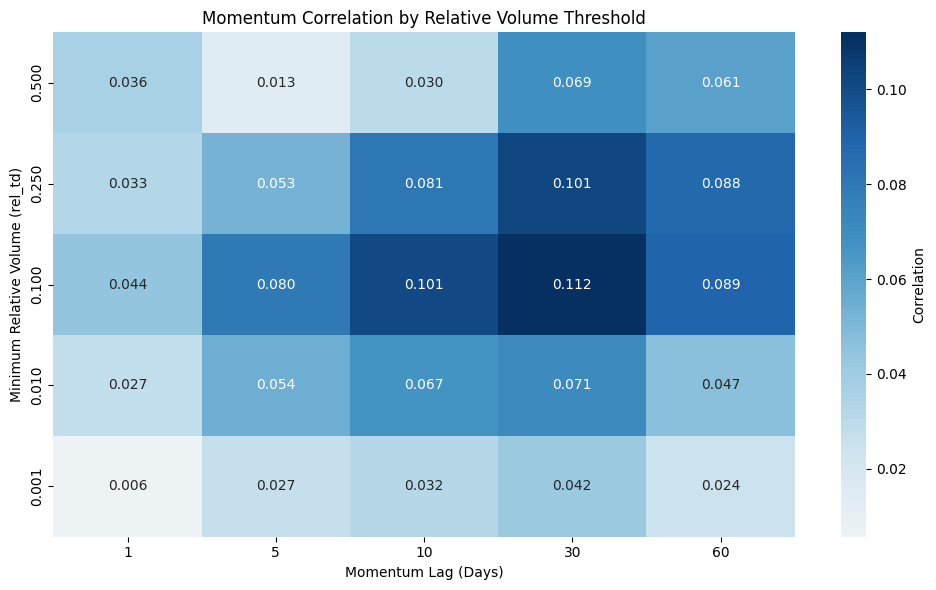

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Correlation by Volume Bucket in DuckDB
df_vol_corr = con.sql('''
    with thresholds as (
        -- Define your buckets here
        select unnest([0.5, 0.25, 0.1, 0.01, 0.001]) as min_rel_vol
    )
    select 
        t.min_rel_vol,
        m.lag,
        corr(m.mom, m.ret) as correlation,
        count(*) as sample_size
    from momentum m
    join volume v 
      on v.ts = m.ts and v.symbol = m.symbol
    cross join thresholds t
    where v.rel_td >= t.min_rel_vol  -- Cumulative Filter
      and m.lag in (1, 5, 10, 30, 60) -- Filter specific lags to keep it readable
    group by 1, 2
    order by 1 desc, 2
''').pl()

# 2. Pivot for Heatmap
# Index = Volume Threshold, Columns = Lag
df_pivot = df_vol_corr.to_pandas().pivot(index='min_rel_vol', columns='lag', values='correlation')

# Sort index so highest volume (most restrictive) is at the top
df_pivot = df_pivot.sort_index(ascending=False)

# 3. Visualize
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt='.3f', 
    cmap='RdBu', 
    center=0,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title('Momentum Correlation by Relative Volume Threshold')
ax.set_ylabel('Minimum Relative Volume (rel_td)')
ax.set_xlabel('Momentum Lag (Days)')

plt.tight_layout()
plt.show()

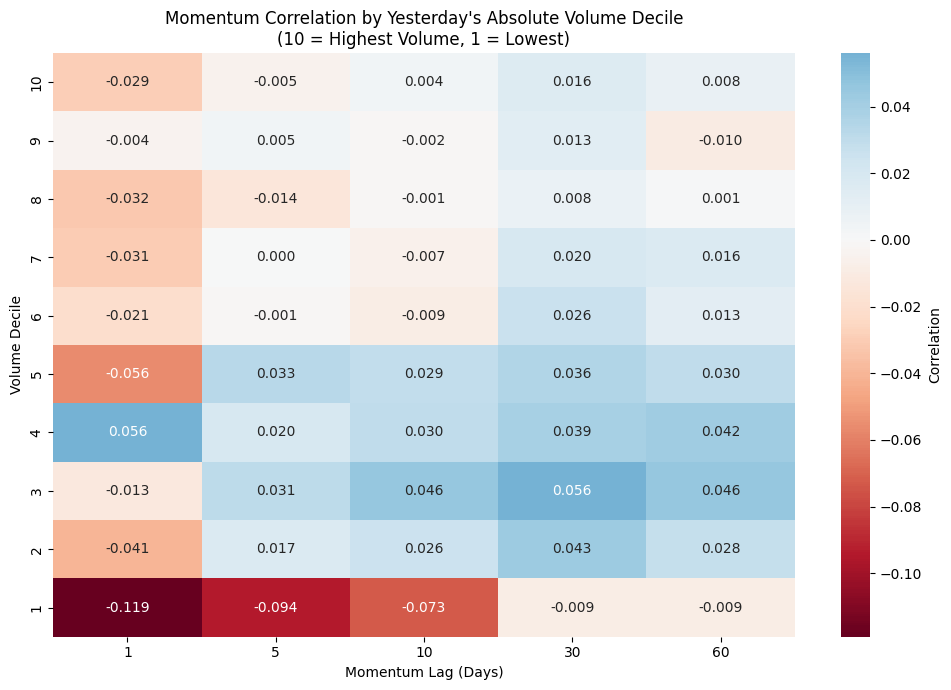

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Deciles & Correlation in DuckDB
df_decile = con.sql('''
    with daily_ranks as (
        select 
            ts, 
            symbol,
            -- Split into 10 buckets based on daily volume rank
            -- 1 = Smallest Volume, 10 = Largest Volume
            ntile(10) over (partition by ts order by abs_yd asc) as vol_decile
        from volume
    )
    select 
        r.vol_decile,
        m.lag,
        corr(m.mom, m.ret) as correlation
    from momentum m
    join daily_ranks r 
      on r.ts = m.ts and r.symbol = m.symbol
    where m.lag in (1, 5, 10, 30, 60) and year(m.ts) >= 2018
    group by 1, 2
    order by 1 desc, 2
''').pl()

# 2. Pivot for Heatmap
# Index = Decile, Columns = Lag
df_pivot = df_decile.to_pandas().pivot(index='vol_decile', columns='lag', values='correlation')

# Sort index descending so "Largest" (10) is at the top
df_pivot = df_pivot.sort_index(ascending=False)

# 3. Visualize
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt='.3f', 
    cmap='RdBu', 
    center=0,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title('Momentum Correlation by Yesterday\'s Absolute Volume Decile\n(10 = Highest Volume, 1 = Lowest)')
ax.set_ylabel('Volume Decile')
ax.set_xlabel('Momentum Lag (Days)')

# Optional: Add friendly labels to Y-axis
# ax.set_yticklabels([f'D{i}' for i in range(10, 0, -1)], rotation=0)

plt.tight_layout()
plt.show()

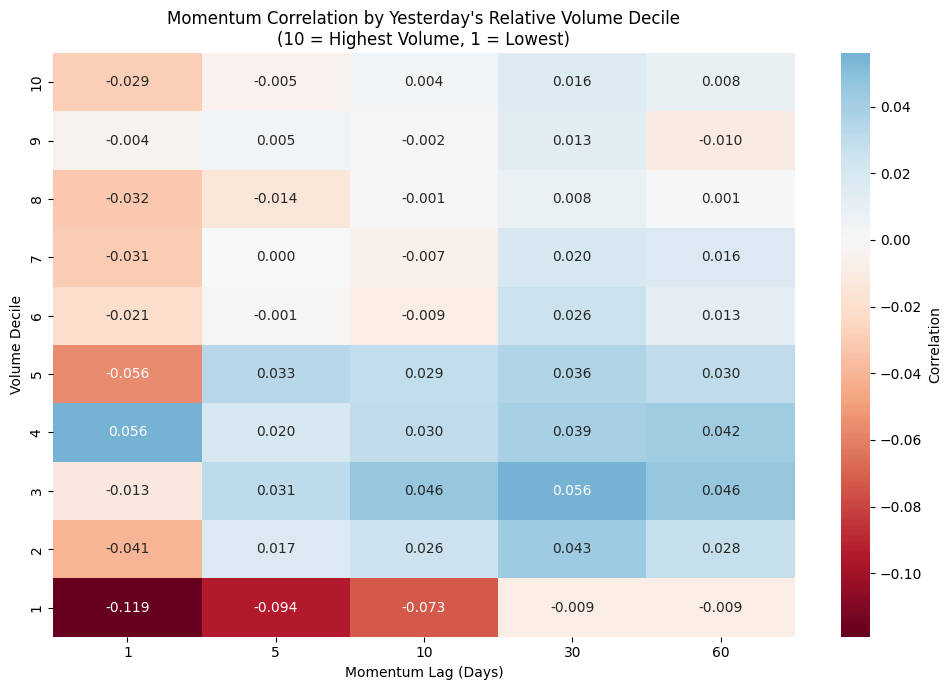

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Deciles & Correlation in DuckDB
df_decile = con.sql('''
    with daily_ranks as (
        select 
            ts, 
            symbol,
            -- Split into 10 buckets based on daily volume rank
            -- 1 = Smallest Volume, 10 = Largest Volume
            ntile(10) over (partition by ts order by rel_yd asc) as vol_decile
        from volume
    )
    select 
        r.vol_decile,
        m.lag,
        corr(m.mom, m.ret) as correlation
    from momentum m
    join daily_ranks r 
      on r.ts = m.ts and r.symbol = m.symbol
    where m.lag in (1, 5, 10, 30, 60) and year(m.ts) >= 2018
    group by 1, 2
    order by 1 desc, 2
''').pl()

# 2. Pivot for Heatmap
# Index = Decile, Columns = Lag
df_pivot = df_decile.to_pandas().pivot(index='vol_decile', columns='lag', values='correlation')

# Sort index descending so "Largest" (10) is at the top
df_pivot = df_pivot.sort_index(ascending=False)

# 3. Visualize
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt='.3f', 
    cmap='RdBu', 
    center=0,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title('Momentum Correlation by Yesterday\'s Relative Volume Decile\n(10 = Highest Volume, 1 = Lowest)')
ax.set_ylabel('Volume Decile')
ax.set_xlabel('Momentum Lag (Days)')

# Optional: Add friendly labels to Y-axis
# ax.set_yticklabels([f'D{i}' for i in range(10, 0, -1)], rotation=0)

plt.tight_layout()
plt.show()

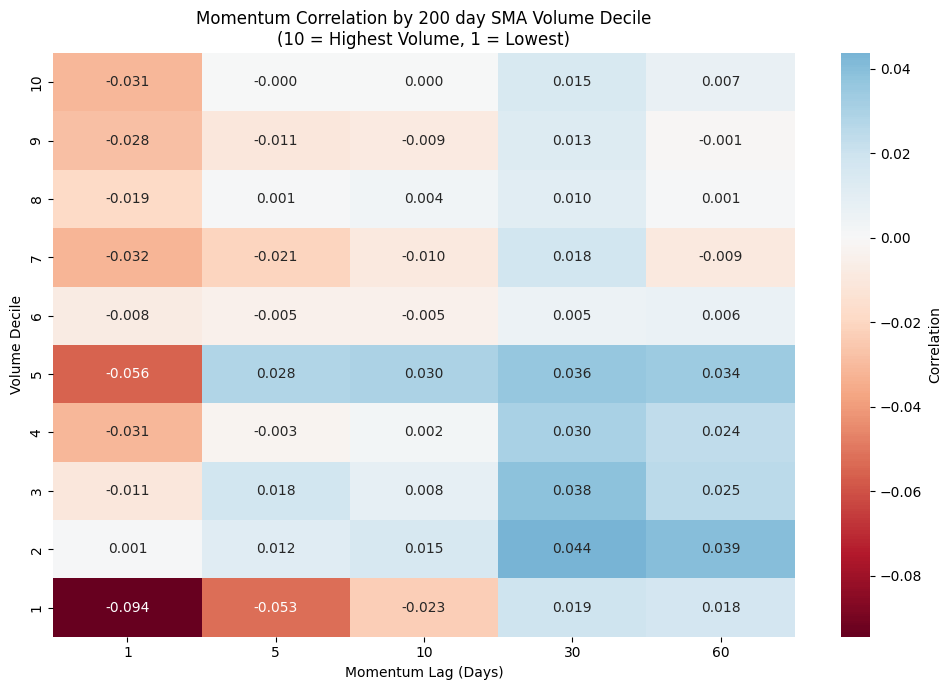

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Deciles & Correlation in DuckDB
df_decile = con.sql('''
    with daily_ranks as (
        select 
            ts, 
            symbol,
            -- Split into 10 buckets based on daily volume rank
            -- 1 = Smallest Volume, 10 = Largest Volume
            ntile(10) over (partition by ts order by vol200 asc) as vol_decile
        from sma
    )
    select 
        r.vol_decile,
        m.lag,
        corr(m.mom, m.ret) as correlation
    from momentum m
    join daily_ranks r 
      on r.ts = m.ts and r.symbol = m.symbol
    where m.lag in (1, 5, 10, 30, 60) and year(m.ts) >= 2018
    group by 1, 2
    order by 1 desc, 2
''').pl()

# 2. Pivot for Heatmap
# Index = Decile, Columns = Lag
df_pivot = df_decile.to_pandas().pivot(index='vol_decile', columns='lag', values='correlation')

# Sort index descending so "Largest" (10) is at the top
df_pivot = df_pivot.sort_index(ascending=False)

# 3. Visualize
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt='.3f', 
    cmap='RdBu', 
    center=0,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title('Momentum Correlation by 200 day SMA Volume Decile\n(10 = Highest Volume, 1 = Lowest)')
ax.set_ylabel('Volume Decile')
ax.set_xlabel('Momentum Lag (Days)')

# Optional: Add friendly labels to Y-axis
# ax.set_yticklabels([f'D{i}' for i in range(10, 0, -1)], rotation=0)

plt.tight_layout()
plt.show()

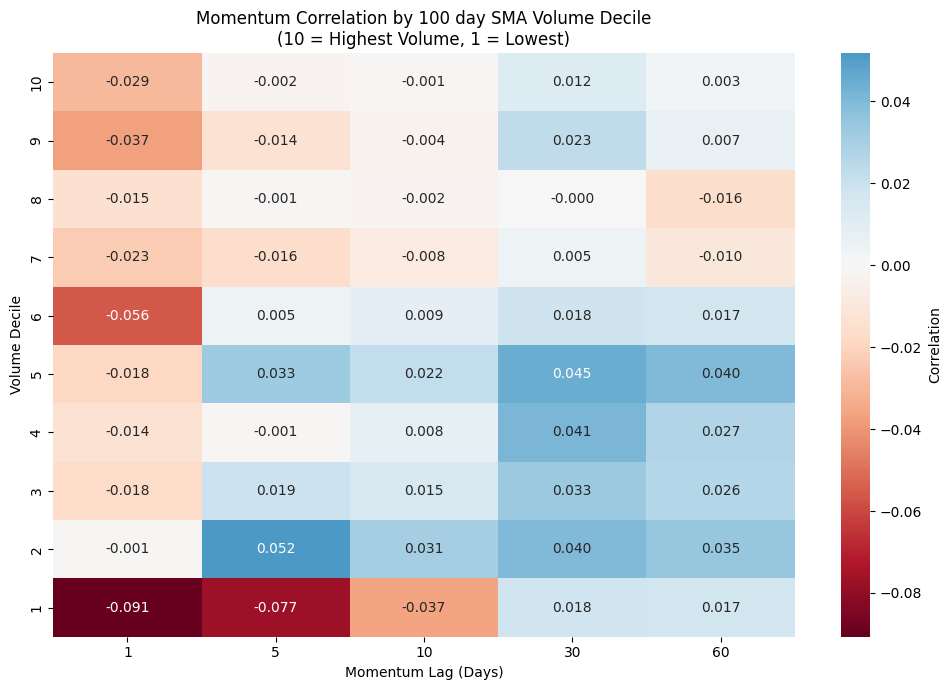

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Deciles & Correlation in DuckDB
df_decile = con.sql('''
    with daily_ranks as (
        select 
            ts, 
            symbol,
            -- Split into 10 buckets based on daily volume rank
            -- 1 = Smallest Volume, 10 = Largest Volume
            ntile(10) over (partition by ts order by vol100 asc) as vol_decile
        from sma
    )
    select 
        r.vol_decile,
        m.lag,
        corr(m.mom, m.ret) as correlation
    from momentum m
    join daily_ranks r 
      on r.ts = m.ts and r.symbol = m.symbol
    where m.lag in (1, 5, 10, 30, 60) and year(m.ts) >= 2018
    group by 1, 2
    order by 1 desc, 2
''').pl()

# 2. Pivot for Heatmap
# Index = Decile, Columns = Lag
df_pivot = df_decile.to_pandas().pivot(index='vol_decile', columns='lag', values='correlation')

# Sort index descending so "Largest" (10) is at the top
df_pivot = df_pivot.sort_index(ascending=False)

# 3. Visualize
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt='.3f', 
    cmap='RdBu', 
    center=0,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title('Momentum Correlation by 100 day SMA Volume Decile\n(10 = Highest Volume, 1 = Lowest)')
ax.set_ylabel('Volume Decile')
ax.set_xlabel('Momentum Lag (Days)')

# Optional: Add friendly labels to Y-axis
# ax.set_yticklabels([f'D{i}' for i in range(10, 0, -1)], rotation=0)

plt.tight_layout()
plt.show()

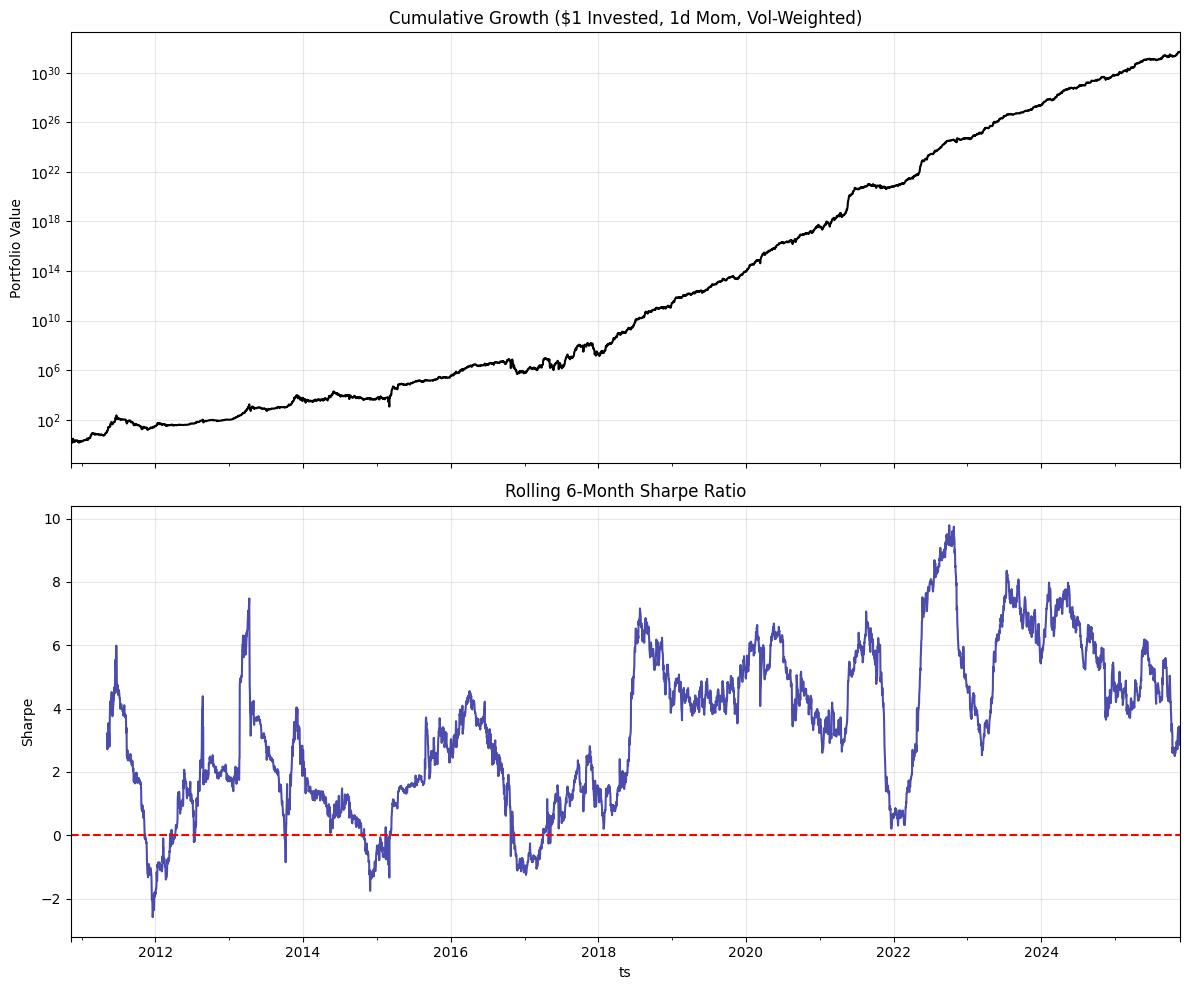

In [19]:
# VW-MON winner - losers

import pandas as pd
import numpy as np

# --- CONFIGURATION ---
MOM_LAG = 1  # Lookback period for the signal
SMA_COL = 'vol20' # Column from 'sma' table to use for weighting

# 1. Execute Backtest Logic in DuckDB
# We do the heavy lifting in SQL to avoid pulling raw data to Python
df_pnl = con.sql(f'''
    WITH daily_signal AS (
        -- Join Momentum (Signal) with SMA (Weight)
        SELECT 
            m.ts,
            m.symbol,
            m.mom,
            m.ret,   -- Next day return
            s.{SMA_COL} as weight_metric
        FROM momentum m
        JOIN sma s 
          ON m.ts = s.ts AND m.symbol = s.symbol
        WHERE m.lag = {MOM_LAG}
          AND s.{SMA_COL} > 0
    ),
    ranked AS (
        -- Rank coins into 10 buckets (1=Low Mom, 10=High Mom)
        SELECT 
            *,
            ntile(10) OVER (PARTITION BY ts ORDER BY mom ASC) as decile
        FROM daily_signal
    ),
    bucket_stats AS (
        -- Calculate total weight (volume) per bucket to normalize later
        SELECT 
            ts, 
            decile,
            sum(weight_metric) as total_bucket_vol
        FROM ranked
        WHERE decile IN (1, 10)
        GROUP BY 1, 2
    )
    SELECT 
        r.ts,
        -- LONG SIDE (Decile 10)
        sum(case when r.decile = 10 then (r.weight_metric / bs.total_bucket_vol) * r.ret else 0 end) as long_ret,
        
        -- SHORT SIDE (Decile 1)
        sum(case when r.decile = 1 then (r.weight_metric / bs.total_bucket_vol) * r.ret else 0 end) as short_ret
        
    FROM ranked r
    JOIN bucket_stats bs 
      ON r.ts = bs.ts AND r.decile = bs.decile
    GROUP BY r.ts
    ORDER BY r.ts
''').pl().to_pandas()

# 2. Calculate Strategy Net Return (Long - Short)
# This assumes $1 Long and $1 Short (Gross Leverage 2.0)
df_pnl['strategy_ret'] = -(df_pnl['long_ret'] - df_pnl['short_ret'])

# 3. Compute Metrics by Year
# We aggregate daily log returns to get annual figures
stats = df_pnl.groupby(df_pnl['ts'].dt.year).agg(
    daily_mean=('strategy_ret', 'mean'),
    daily_std=('strategy_ret', 'std'),
    count=('strategy_ret', 'count'),
    total_ret=('strategy_ret', 'sum') # Sum of log returns = Cumulative Log Return
)

# Annualize Metrics (Crypto trades 365 days)
stats['Annual_Return'] = stats['daily_mean'] * 365
stats['Annual_Vol'] = stats['daily_std'] * np.sqrt(365)
stats['Sharpe_Ratio'] = stats['Annual_Return'] / stats['Annual_Vol']

# Formatting for display
display_cols = ['total_ret', 'Annual_Return', 'Annual_Vol', 'Sharpe_Ratio']
print(stats[display_cols].style.format("{:.2f}"))

# 4. Visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Cumulative PnL
# cumsum of log returns is the log price path. exp() converts to equity curve.
df_pnl.set_index('ts')['strategy_ret'].cumsum().apply(np.exp).plot(ax=ax1, logy=True, title=f'Cumulative Growth ($1 Invested, {MOM_LAG}d Mom, Vol-Weighted)', color='black')
ax1.set_ylabel('Portfolio Value')
ax1.grid(True, alpha=0.3)

# Rolling Sharpe (6 Month)
rolling_sharpe = (
    df_pnl.set_index('ts')['strategy_ret'].rolling(180).mean() * 365 / 
    (df_pnl.set_index('ts')['strategy_ret'].rolling(180).std() * np.sqrt(365))
)
rolling_sharpe.plot(ax=ax2, color='darkblue', alpha=0.7)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title('Rolling 6-Month Sharpe Ratio')
ax2.set_ylabel('Sharpe')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- Annual Performance (Net of Fees) ---


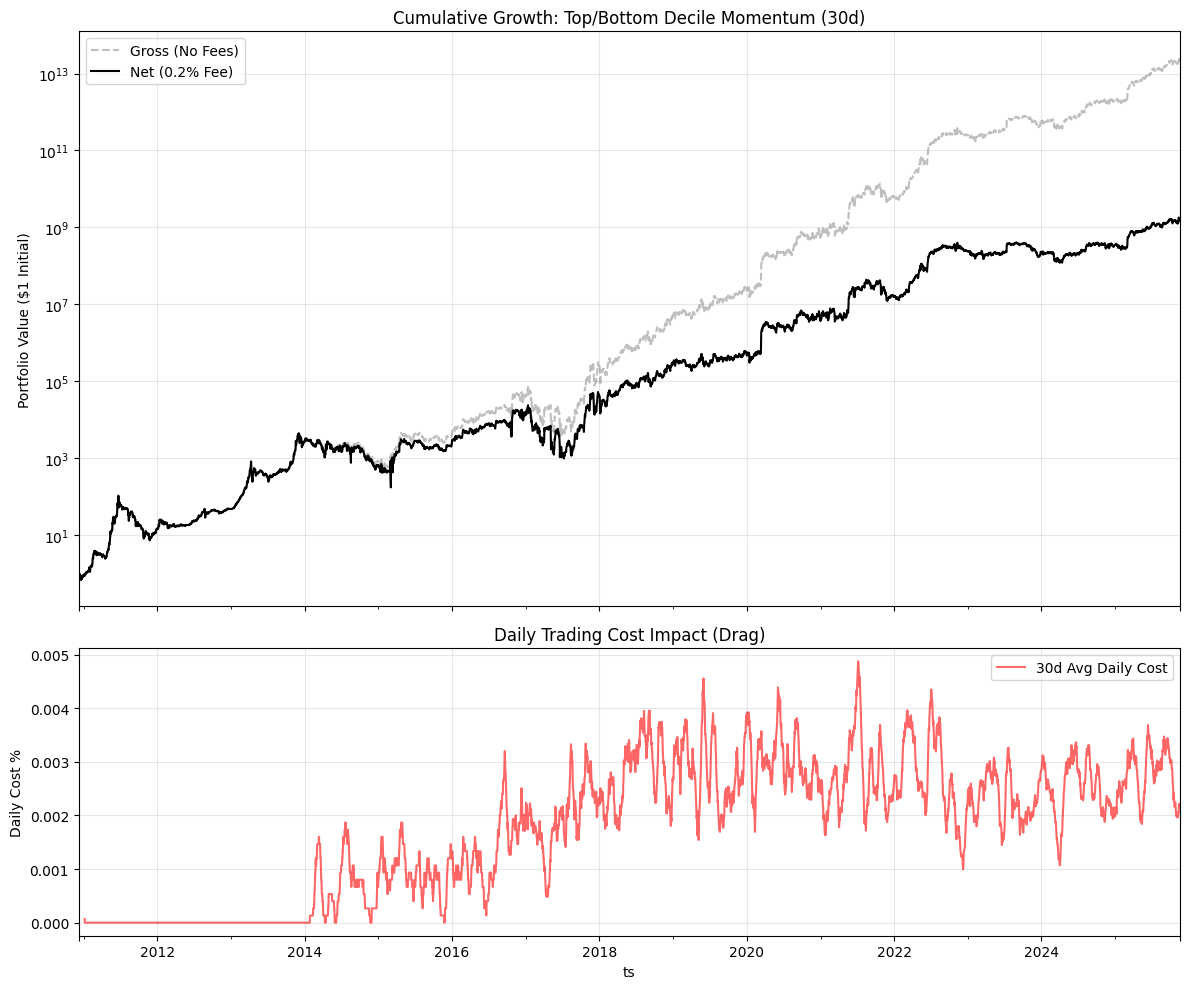

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
MOM_LAG = 30     # Lookback period
SMA_COL = 'vol20' 
FEE_RATE = 0.002 # 0.2% per trade (Taker fee assumption)

# 1. Execute Backtest Logic in DuckDB
df_pnl = con.sql(f'''
    WITH daily_signal AS (
        SELECT 
            m.ts,
            m.symbol,
            m.mom,
            m.ret,
            s.{SMA_COL} as weight_metric
        FROM momentum m
        JOIN sma s ON m.ts = s.ts AND m.symbol = s.symbol
        WHERE m.lag = {MOM_LAG} AND s.{SMA_COL} > 0
    ),
    ranked AS (
        -- Rank EVERY coin, not just the ones we trade
        SELECT 
            *,
            ntile(10) OVER (PARTITION BY ts ORDER BY mom ASC) as decile
        FROM daily_signal
    ),
    bucket_stats AS (
        -- Get total volume only for the buckets we care about (1 and 10)
        SELECT 
            ts, 
            decile,
            sum(weight_metric) as total_bucket_vol
        FROM ranked
        WHERE decile IN (1, 10)
        GROUP BY 1, 2
    ),
    weights AS (
        -- Assign target weights to every coin
        -- Decile 10 = Positive Weight (Long)
        -- Decile 1  = Negative Weight (Short)
        -- Others    = 0 (Not held)
        SELECT
            r.ts,
            r.symbol,
            r.ret,
            CASE 
                WHEN r.decile = 10 THEN -1 * (r.weight_metric / bs.total_bucket_vol)
                WHEN r.decile = 1  THEN  1 * (r.weight_metric / bs.total_bucket_vol)
                ELSE 0.0 
            END as target_weight
        FROM ranked r
        LEFT JOIN bucket_stats bs 
            ON r.ts = bs.ts AND r.decile = bs.decile
    ),
    turnover_calc AS (
        SELECT
            ts,
            symbol,
            ret,
            target_weight,
            -- Look at previous day's weight to determine trade size
            LAG(target_weight, 1, 0.0) OVER (PARTITION BY symbol ORDER BY ts) as prev_weight
        FROM weights
    )
    SELECT 
        ts,
        -- Gross PnL (Strategy Return before fees)
        sum(target_weight * ret) as gross_ret,
        
        -- Turnover: The absolute change in weight for every coin
        -- This captures Entries, Exits, and Rebalancing sizes
        sum(abs(target_weight - prev_weight)) as turnover
        
    FROM turnover_calc
    -- Optimization: We only care about rows where a trade happened or a position is held
    WHERE abs(target_weight) > 0 OR abs(prev_weight) > 0
    GROUP BY ts
    ORDER BY ts
''').pl().to_pandas()

# 2. Calculate Net Returns
# Cost = Total Turnover * Fee Rate
df_pnl['cost'] = df_pnl['turnover'] * FEE_RATE
df_pnl['net_ret'] = df_pnl['gross_ret'] - df_pnl['cost']

# 3. Compute Metrics (Using Net Return)
stats = df_pnl.groupby(df_pnl['ts'].dt.year).agg(
    daily_mean=('net_ret', 'mean'),
    daily_std=('net_ret', 'std'),
    turnover_avg=('turnover', 'mean'), # Track how much we trade daily
    total_cost=('cost', 'sum'),
    total_ret=('net_ret', 'sum') 
)

stats['Annual_Return'] = stats['daily_mean'] * 365
stats['Annual_Vol'] = stats['daily_std'] * np.sqrt(365)
stats['Sharpe_Ratio'] = stats['Annual_Return'] / stats['Annual_Vol']

# Display
print("--- Annual Performance (Net of Fees) ---")
display_cols = ['total_ret', 'Annual_Return', 'Sharpe_Ratio', 'turnover_avg']
print(stats[display_cols].style.format("{:.2f}"))

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot Gross vs Net to see Fee Impact
df_pnl.set_index('ts')['gross_ret'].cumsum().apply(np.exp).plot(ax=ax1, label='Gross (No Fees)', color='grey', alpha=0.5, linestyle='--')
df_pnl.set_index('ts')['net_ret'].cumsum().apply(np.exp).plot(ax=ax1, label=f'Net ({FEE_RATE*100}% Fee)', color='black', linewidth=1.5)

ax1.set_title(f'Cumulative Growth: Top/Bottom Decile Momentum ({MOM_LAG}d)')
ax1.set_ylabel('Portfolio Value ($1 Initial)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log') # Log scale is often better for crypto backtests

# Plot Daily Costs
df_pnl.set_index('ts')['cost'].rolling(30).mean().plot(ax=ax2, color='red', alpha=0.6, label='30d Avg Daily Cost')
ax2.set_title('Daily Trading Cost Impact (Drag)')
ax2.set_ylabel('Daily Cost %')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

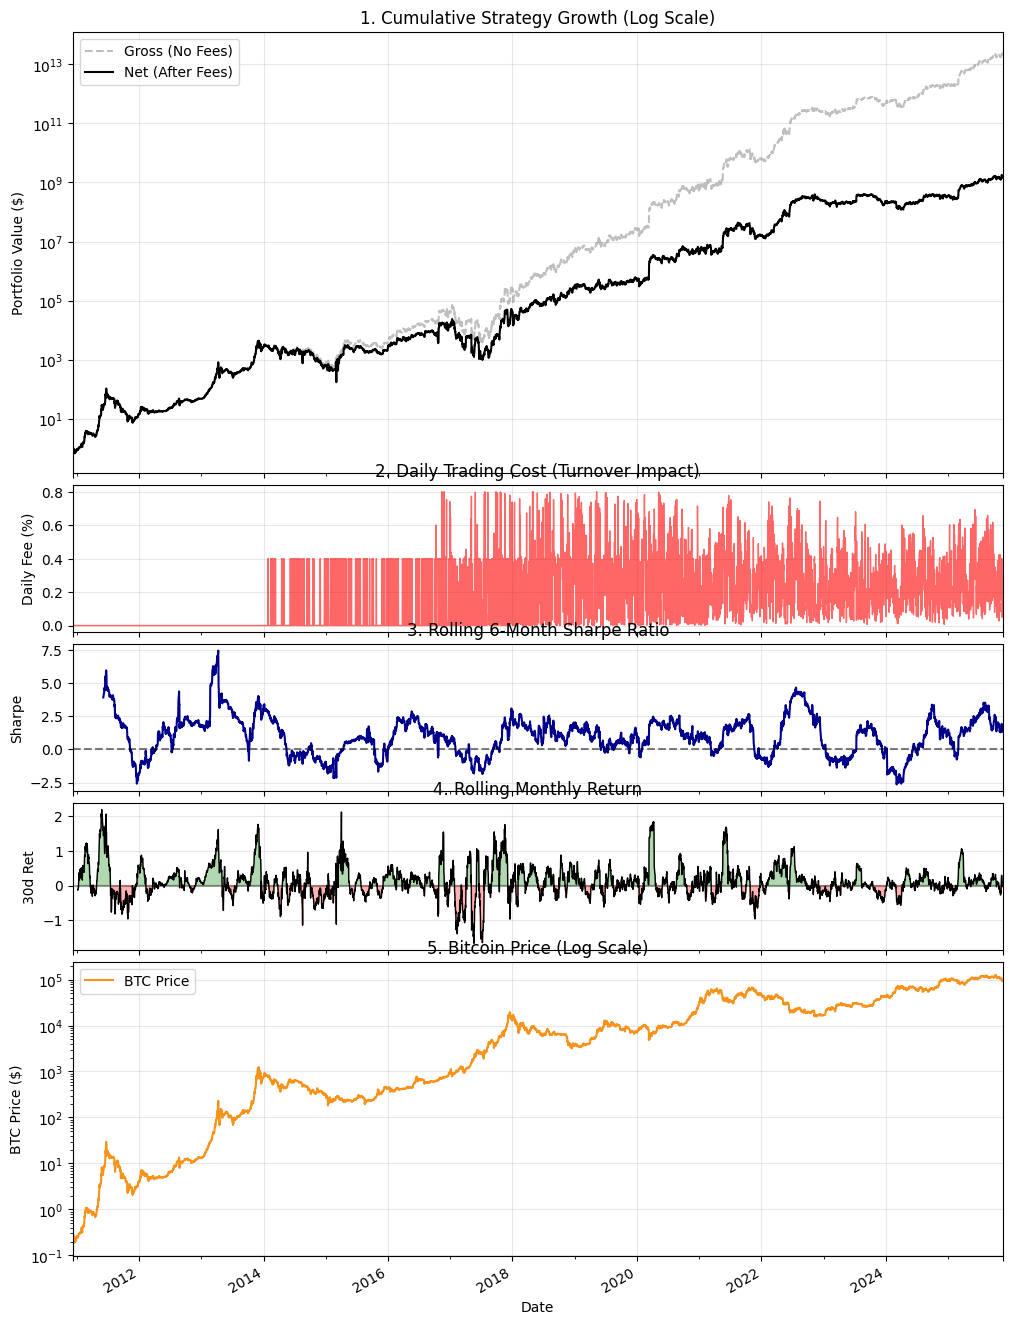

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Fetch BTC Price for Context
df_btc = con.sql('''
    SELECT ts, close as btc_price 
    FROM coins 
    WHERE symbol = 'btc' 
    ORDER BY ts
''').pl().to_pandas()

# 2. Merge Strategy Data with BTC Data
# We use an 'asof' merge or left join to align timestamps perfectly
df_viz = pd.merge(df_pnl, df_btc, on='ts', how='left')
df_viz = df_viz.set_index('ts')

# 3. Calculate Additional Rolling Metrics
# Rolling 6-Month Sharpe (Annualized)
rolling_sharpe = (
    df_viz['net_ret'].rolling(180).mean() * 365 / 
    (df_viz['net_ret'].rolling(180).std() * np.sqrt(365))
)

# Rolling Monthly (30-Day) Return (Sum of log returns)
rolling_monthly_ret = df_viz['net_ret'].rolling(30).sum()

# 4. Create the 5-Panel Plot
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 2]})
plt.subplots_adjust(hspace=0.05) # Reduce gaps between plots

# --- Panel 1: Cumulative Growth (Gross vs Net) ---
df_viz['gross_ret'].cumsum().apply(np.exp).plot(ax=axes[0], label='Gross (No Fees)', color='grey', alpha=0.5, linestyle='--')
df_viz['net_ret'].cumsum().apply(np.exp).plot(ax=axes[0], label='Net (After Fees)', color='black', linewidth=1.5)
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].set_title('1. Cumulative Strategy Growth (Log Scale)')
axes[0].set_yscale('log')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# --- Panel 2: Daily Trading Fees ---
# We plot the daily cost to show turnover spikes
(df_viz['cost'] * 100).plot(ax=axes[1], color='red', alpha=0.6, linewidth=1)
axes[1].set_ylabel('Daily Fee (%)')
axes[1].set_title('2. Daily Trading Cost (Turnover Impact)')
axes[1].grid(True, alpha=0.3)

# --- Panel 3: Rolling Sharpe Ratio ---
rolling_sharpe.plot(ax=axes[2], color='darkblue', linewidth=1.5)
axes[2].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Sharpe')
axes[2].set_title('3. Rolling 6-Month Sharpe Ratio')
axes[2].grid(True, alpha=0.3)

# --- Panel 4: Rolling Monthly Return ---
# Fill positive green, negative red
axes[3].plot(rolling_monthly_ret.index, rolling_monthly_ret, color='black', linewidth=1)
axes[3].fill_between(rolling_monthly_ret.index, rolling_monthly_ret, 0, where=(rolling_monthly_ret >= 0), color='green', alpha=0.3)
axes[3].fill_between(rolling_monthly_ret.index, rolling_monthly_ret, 0, where=(rolling_monthly_ret < 0), color='red', alpha=0.3)
axes[3].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[3].set_ylabel('30d Ret')
axes[3].set_title('4. Rolling Monthly Return')
axes[3].grid(True, alpha=0.3)

# --- Panel 5: BTC Price (Market Context) ---
axes[4].plot(df_viz.index, df_viz['btc_price'], color='#F7931A', label='BTC Price') # Bitcoin Orange
axes[4].set_ylabel('BTC Price ($)')
axes[4].set_title('5. Bitcoin Price (Log Scale)')
axes[4].set_yscale('log')
axes[4].grid(True, alpha=0.3)
axes[4].legend(loc='upper left')

# Final Formatting
plt.xlabel('Date')
# Align date labels nicely
fig.autofmt_xdate()

plt.show()

--- Mean Reversion on High Vol Assets (Net of Fees) ---


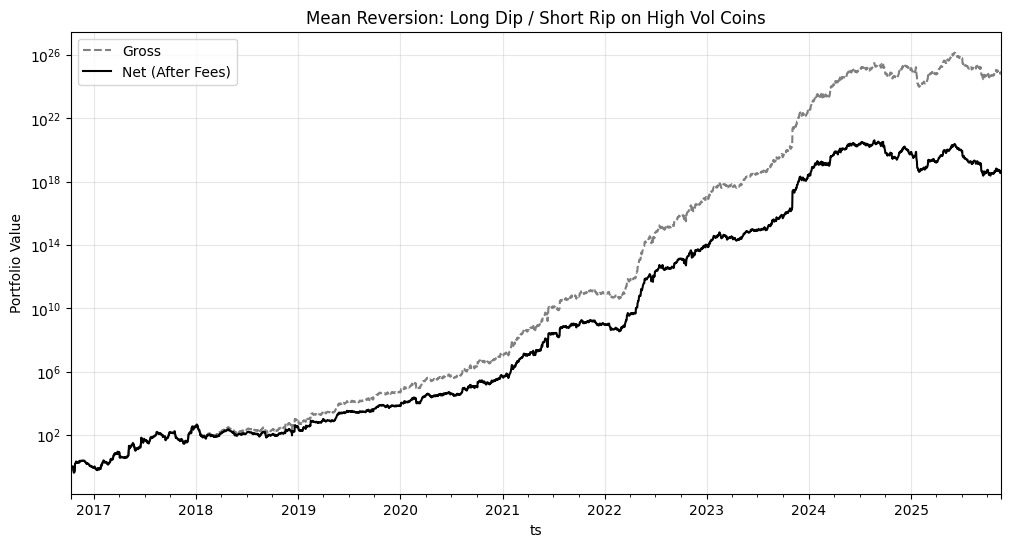

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
FEE_RATE = 0.002  # 0.2% per trade
SMA_COL = 'vol20'

# 1. Execute Backtest Logic in DuckDB
df_pnl = con.sql(f'''
    WITH base_data AS (
        -- Join 30-day Mom (Filter), 1-day Mom (Signal), and Volume (Weight)
        SELECT 
            m30.ts,
            m30.symbol,
            m30.mom as mom30,
            m1.mom as mom1,
            m1.ret,   -- Next day return
            s.{SMA_COL} as weight_metric
        FROM momentum m30
        JOIN momentum m1 
          ON m30.ts = m1.ts AND m30.symbol = m1.symbol
        JOIN sma s 
          ON m30.ts = s.ts AND m30.symbol = s.symbol
        WHERE m30.lag = 30 
          AND m1.lag = 1
          AND s.{SMA_COL} > 0
    ),
    universe_ranking AS (
        SELECT 
            *,
            -- Rank 1: Filter for Top Decile of ABSOLUTE 30-day momentum
            -- This isolates the most volatile/active coins (Big winners AND Big losers)
            ntile(10) OVER (PARTITION BY ts ORDER BY abs(mom30) ASC) as abs_mom30_rank
        FROM base_data
    ),
    target_universe AS (
        -- Keep only the "High Volatility" Decile (Rank 10)
        SELECT * FROM universe_ranking WHERE abs_mom30_rank = 10
    ),
    final_ranking AS (
        -- Rank 2: Sort by 1-Day Momentum to find short-term extensions
        SELECT 
            *,
            ntile(10) OVER (PARTITION BY ts ORDER BY mom1 ASC) as mom1_rank
        FROM target_universe
    ),
    bucket_stats AS (
        SELECT 
            ts, 
            mom1_rank,
            sum(weight_metric) as total_bucket_vol
        FROM final_ranking
        WHERE mom1_rank IN (1, 10)
        GROUP BY 1, 2
    ),
    weights AS (
        SELECT
            r.ts,
            r.symbol,
            r.ret,
            CASE 
                -- COUNTER TRADE LOGIC:
                -- If 1-Day Mom is High (Rank 10) -> Short (Expect Pullback)
                WHEN r.mom1_rank = 10 THEN -1 * (r.weight_metric / bs.total_bucket_vol)
                
                -- If 1-Day Mom is Low (Rank 1) -> Long (Expect Bounce)
                WHEN r.mom1_rank = 1  THEN (r.weight_metric / bs.total_bucket_vol)
                
                ELSE 0.0 
            END as target_weight
        FROM final_ranking r
        LEFT JOIN bucket_stats bs 
            ON r.ts = bs.ts AND r.mom1_rank = bs.mom1_rank
    ),
    turnover_calc AS (
        SELECT
            ts,
            symbol,
            ret,
            target_weight,
            LAG(target_weight, 1, 0.0) OVER (PARTITION BY symbol ORDER BY ts) as prev_weight
        FROM weights
    )
    SELECT 
        ts,
        sum(target_weight * ret) as gross_ret,
        sum(abs(target_weight - prev_weight)) as turnover
    FROM turnover_calc
    WHERE abs(target_weight) > 0 OR abs(prev_weight) > 0
    GROUP BY ts
    ORDER BY ts
''').pl().to_pandas()

# 2. Calculate Net Returns
df_pnl['cost'] = df_pnl['turnover'] * FEE_RATE
df_pnl['net_ret'] = df_pnl['gross_ret'] - df_pnl['cost']

# 3. Compute Metrics
stats = df_pnl.groupby(df_pnl['ts'].dt.year).agg(
    daily_mean=('net_ret', 'mean'),
    daily_std=('net_ret', 'std'),
    turnover_avg=('turnover', 'mean'),
    total_cost=('cost', 'sum'),
    total_ret=('net_ret', 'sum') 
)

stats['Annual_Return'] = stats['daily_mean'] * 365
stats['Annual_Vol'] = stats['daily_std'] * np.sqrt(365)
stats['Sharpe_Ratio'] = stats['Annual_Return'] / stats['Annual_Vol']

print("--- Mean Reversion on High Vol Assets (Net of Fees) ---")
display_cols = ['total_ret', 'Annual_Return', 'Sharpe_Ratio', 'turnover_avg']
print(stats[display_cols].style.format("{:.2f}"))

# 4. Visualization (Cumulative PnL)
fig, ax = plt.subplots(figsize=(12, 6))
df_pnl.set_index('ts')['gross_ret'].cumsum().apply(np.exp).plot(ax=ax, label='Gross', color='grey', linestyle='--')
df_pnl.set_index('ts')['net_ret'].cumsum().apply(np.exp).plot(ax=ax, label='Net (After Fees)', color='black')

ax.set_title('Mean Reversion: Long Dip / Short Rip on High Vol Coins')
ax.set_ylabel('Portfolio Value')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

/Users/kai/studies/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


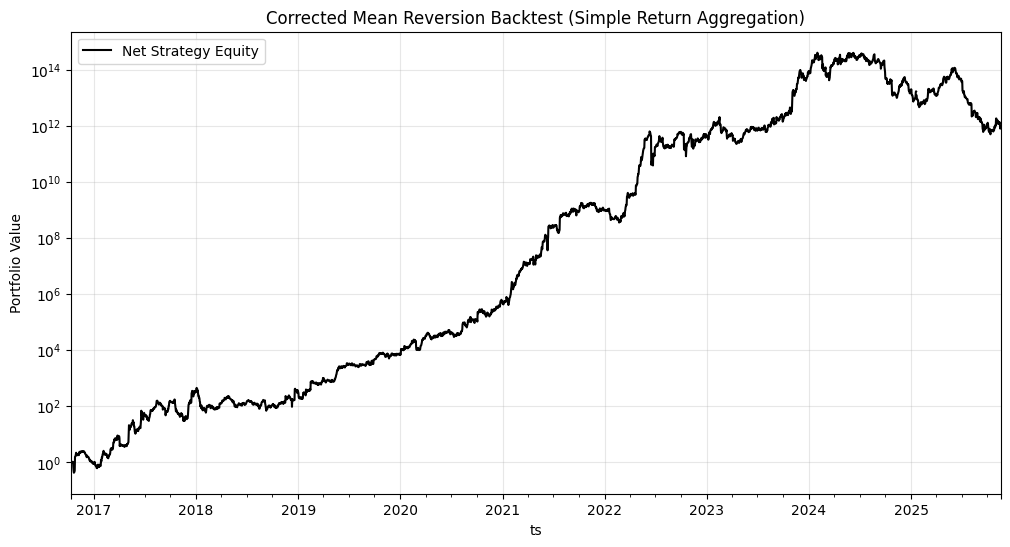

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
FEE_RATE = 0.002
SMA_COL = 'vol20'

# 1. Execute Backtest Logic
df_pnl = con.sql(f'''
    WITH base_data AS (
        SELECT 
            m30.ts,
            m30.symbol,
            m30.mom as mom30,
            m1.mom as mom1,
            -- FIX 1: Convert Log Return to Simple Return for Portfolio Math
            exp(m1.ret) - 1 as ret_simple,
            s.{SMA_COL} as weight_metric
        FROM momentum m30
        JOIN momentum m1 
          ON m30.ts = m1.ts AND m30.symbol = m1.symbol
        JOIN sma s 
          ON m30.ts = s.ts AND m30.symbol = s.symbol
        WHERE m30.lag = 30 
          AND m1.lag = 1
          AND s.{SMA_COL} > 0
    ),
    universe_ranking AS (
        SELECT 
            *,
            -- Rank by Absolute 30d Momentum (Vol Filter)
            ntile(10) OVER (PARTITION BY ts ORDER BY abs(mom30) ASC) as abs_mom30_rank
        FROM base_data
    ),
    target_universe AS (
        SELECT * FROM universe_ranking WHERE abs_mom30_rank = 10
    ),
    final_ranking AS (
        -- Rank by 1d Momentum (Signal)
        SELECT 
            *,
            ntile(10) OVER (PARTITION BY ts ORDER BY mom1 ASC) as mom1_rank
        FROM target_universe
    ),
    bucket_stats AS (
        SELECT 
            ts, 
            mom1_rank,
            sum(weight_metric) as total_bucket_vol
        FROM final_ranking
        WHERE mom1_rank IN (1, 10)
        GROUP BY 1, 2
    ),
    weights AS (
        SELECT
            r.ts,
            r.symbol,
            r.ret_simple, -- Using Simple Return
            CASE 
                -- Short High Mom (Rank 10), Long Low Mom (Rank 1)
                WHEN r.mom1_rank = 10 THEN -1 * (r.weight_metric / bs.total_bucket_vol)
                WHEN r.mom1_rank = 1  THEN (r.weight_metric / bs.total_bucket_vol)
                ELSE 0.0 
            END as target_weight
        FROM final_ranking r
        LEFT JOIN bucket_stats bs 
            ON r.ts = bs.ts AND r.mom1_rank = bs.mom1_rank
    ),
    turnover_calc AS (
        SELECT
            ts,
            symbol,
            ret_simple,
            target_weight,
            LAG(target_weight, 1, 0.0) OVER (PARTITION BY symbol ORDER BY ts) as prev_weight
        FROM weights
    )
    SELECT 
        ts,
        -- FIX 2: Summing Simple Returns is mathematically correct for PnL
        sum(target_weight * ret_simple) as gross_ret_simple,
        
        -- Turnover calc remains same (abs difference of weights)
        sum(abs(target_weight - prev_weight)) as turnover
    FROM turnover_calc
    WHERE abs(target_weight) > 0 OR abs(prev_weight) > 0
    GROUP BY ts
    ORDER BY ts
''').pl().to_pandas()

# 2. Net Returns (Simple Math)
# Net Simple Return = Gross Simple Return - (Turnover * Fee)
df_pnl['cost'] = df_pnl['turnover'] * FEE_RATE
df_pnl['net_ret_simple'] = df_pnl['gross_ret_simple'] - df_pnl['cost']

# 3. Convert back to Log Returns for Cumulative Plotting
# This makes the "cumsum" chart accurate over long periods
df_pnl['net_ret_log'] = np.log1p(df_pnl['net_ret_simple'])

# 4. Visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Use the LOG returns for the cumulative chart
df_pnl.set_index('ts')['net_ret_log'].cumsum().apply(np.exp).plot(ax=ax, color='black', label='Net Strategy Equity')

ax.set_title('Corrected Mean Reversion Backtest (Simple Return Aggregation)')
ax.set_ylabel('Portfolio Value')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

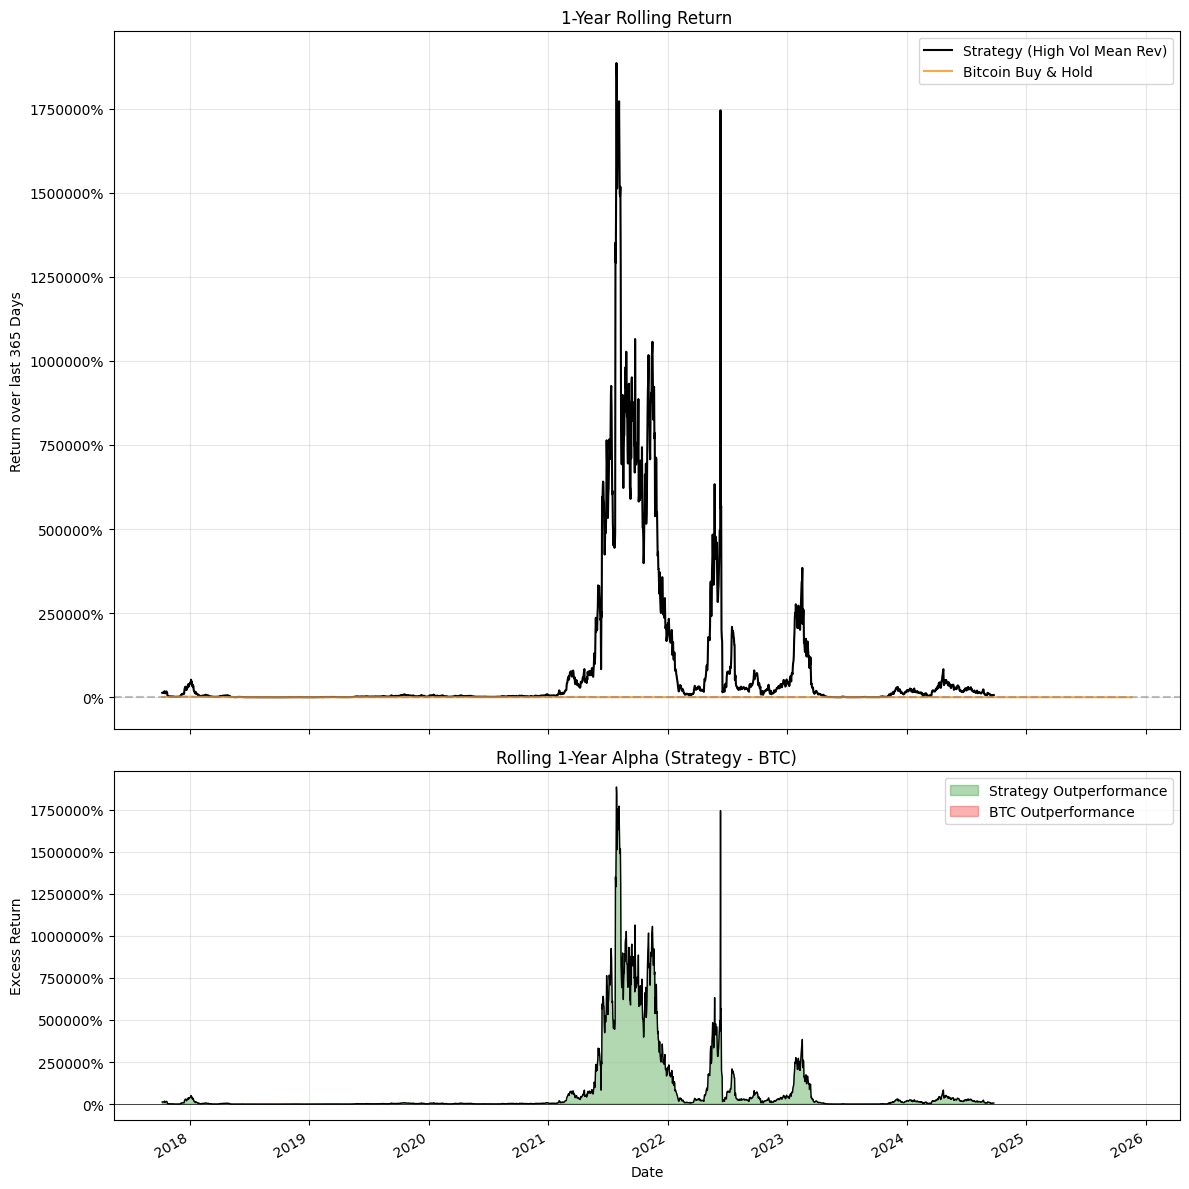

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Fetch BTC Daily Log Returns
df_btc = con.sql('''
    SELECT 
        ts, 
        ln(close / lag(close) OVER (ORDER BY ts)) as btc_ret_log
    FROM coins 
    WHERE symbol = 'btc' 
    ORDER BY ts
''').pl().to_pandas()

# 2. Merge with Strategy Data
# We use 'net_ret_log' calculated in the previous step
df_compare = pd.merge(df_pnl[['ts', 'net_ret_log']], df_btc, on='ts', how='inner')
df_compare = df_compare.set_index('ts')

# 3. Calculate 1-Year (365 Days) Rolling Return
# Sum of log returns = Total Log Return over the period
# We apply exp() - 1 at the end to convert to percentage (e.g., +1.5 = 150%)
rolling_window = 365

df_compare['Strategy_1Y'] = df_compare['net_ret_log'].rolling(rolling_window).sum().apply(lambda x: np.exp(x) - 1)
df_compare['BTC_1Y'] = df_compare['btc_ret_log'].rolling(rolling_window).sum().apply(lambda x: np.exp(x) - 1)

# 4. Calculate Relative Performance (Alpha)
df_compare['Alpha_1Y'] = df_compare['Strategy_1Y'] - df_compare['BTC_1Y']

# 5. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top Panel: Absolute Rolling Returns
ax1.plot(df_compare.index, df_compare['Strategy_1Y'], color='black', label='Strategy (High Vol Mean Rev)', linewidth=1.5)
ax1.plot(df_compare.index, df_compare['BTC_1Y'], color='#F7931A', label='Bitcoin Buy & Hold', alpha=0.8, linewidth=1.5)

# Formatting Y-Axis as Percent
import matplotlib.ticker as mtick
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax1.axhline(0, color='grey', linestyle='--', alpha=0.5)
ax1.set_title('1-Year Rolling Return')
ax1.set_ylabel('Return over last 365 Days')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom Panel: Alpha (Strategy - BTC)
# Fill Green when Strategy wins, Red when BTC wins
ax2.plot(df_compare.index, df_compare['Alpha_1Y'], color='black', linewidth=1)
ax2.fill_between(df_compare.index, df_compare['Alpha_1Y'], 0, where=(df_compare['Alpha_1Y'] >= 0), color='green', alpha=0.3, label='Strategy Outperformance')
ax2.fill_between(df_compare.index, df_compare['Alpha_1Y'], 0, where=(df_compare['Alpha_1Y'] < 0), color='red', alpha=0.3, label='BTC Outperformance')

ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Rolling 1-Year Alpha (Strategy - BTC)')
ax2.set_ylabel('Excess Return')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.xlabel('Date')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Benchmark: BTC Annualized Log Return: 90.53%


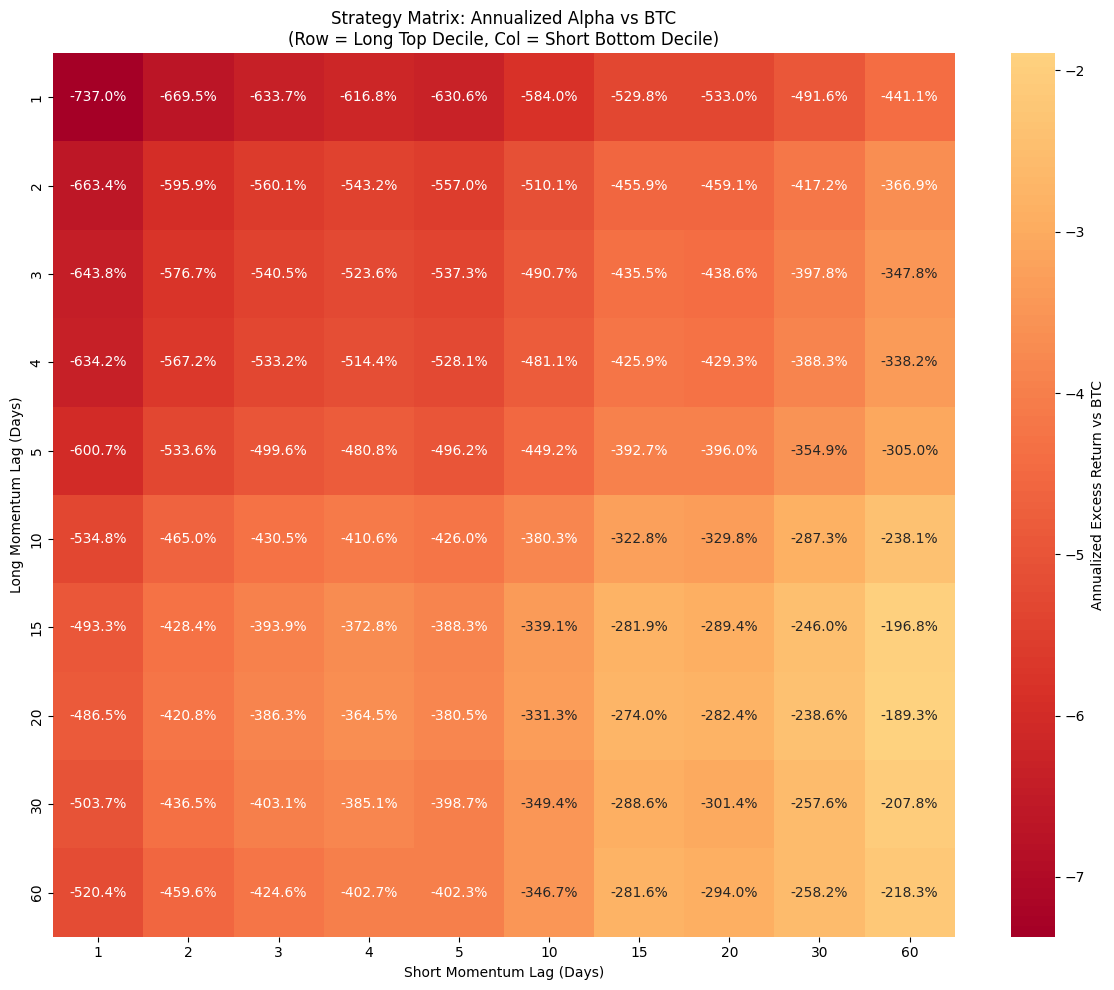

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Get BTC Performance (Benchmark)
# FIX: Use a CTE to calculate daily returns first, then aggregate
btc_stats = con.sql('''
    WITH daily_data AS (
        SELECT 
            ts,
            -- Calculate daily log return first
            ln(close / lag(close) OVER (ORDER BY ts)) as daily_ret
        FROM coins 
        WHERE symbol = 'btc'
    )
    SELECT 
        -- Count only days where we actually have a return (excludes the first day NULL)
        count(daily_ret) as days,
        sum(daily_ret) as total_log_ret
    FROM daily_data
''').df()

# Calculate Annualized Return
# (Total Log Return / Number of Trading Days) * 365
btc_ann_ret = (btc_stats['total_log_ret'][0] / btc_stats['days'][0]) * 365
print(f"Benchmark: BTC Annualized Log Return: {btc_ann_ret:.2%}")
# 2. Pre-Compute Daily Returns for Top/Bottom Deciles for ALL Lags
df_components = con.sql('''
    WITH ranked AS (
        SELECT 
            ts,
            lag,
            ret,  -- <--- FIX: Use the pre-calculated 'ret' column directly
            ntile(10) OVER (PARTITION BY ts, lag ORDER BY mom ASC) as decile
        FROM momentum
    ),
    daily_legs AS (
        SELECT 
            ts,
            lag,
            -- Average return of Top Decile (The "Long" Leg)
            avg(CASE WHEN decile = 10 THEN ret ELSE NULL END) as long_leg,
            
            -- Average return of Bottom Decile (The "Short" Leg)
            avg(CASE WHEN decile = 1 THEN ret ELSE NULL END) as short_leg
        FROM ranked
        GROUP BY 1, 2
    )
    SELECT * FROM daily_legs ORDER BY ts
''').pl().to_pandas()

# 3. Build the Matrix (Python)
# We want to test every combination of Long(Lag X) - Short(Lag Y)
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
matrix_data = []

# Pivot data for fast vectorized access
long_df = df_components.pivot(index='ts', columns='lag', values='long_leg')
short_df = df_components.pivot(index='ts', columns='lag', values='short_leg')

for long_lag in lags:
    row = []
    for short_lag in lags:
        # Strategy: Long the Winners of Lag X, Short the Losers of Lag Y
        daily_net = long_df[long_lag] - short_df[short_lag]
        
        # Annualize
        strat_ann_ret = daily_net.mean() * 365
        
        # Calculate Excess Return vs BTC
        alpha = strat_ann_ret - btc_ann_ret
        
        row.append(alpha)
    matrix_data.append(row)

# 4. Create DataFrame for Heatmap
df_heatmap = pd.DataFrame(matrix_data, index=lags, columns=lags)

# 5. Visualization
plt.figure(figsize=(12, 10))

sns.heatmap(
    df_heatmap, 
    annot=True, 
    fmt='.1%',   
    cmap='RdYlGn', 
    center=0,    
    cbar_kws={'label': 'Annualized Excess Return vs BTC'}
)

plt.title('Strategy Matrix: Annualized Alpha vs BTC\n(Row = Long Top Decile, Col = Short Bottom Decile)')
plt.ylabel('Long Momentum Lag (Days)')
plt.xlabel('Short Momentum Lag (Days)')
plt.tight_layout()
plt.show()

Benchmark BTC Annual Return: 90.53%


/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/1575214788.py:66: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (pl.col(str(short_lag)).rank(method='ordinal').over('ts') / pl.count().over('ts')).alias('local_rank')


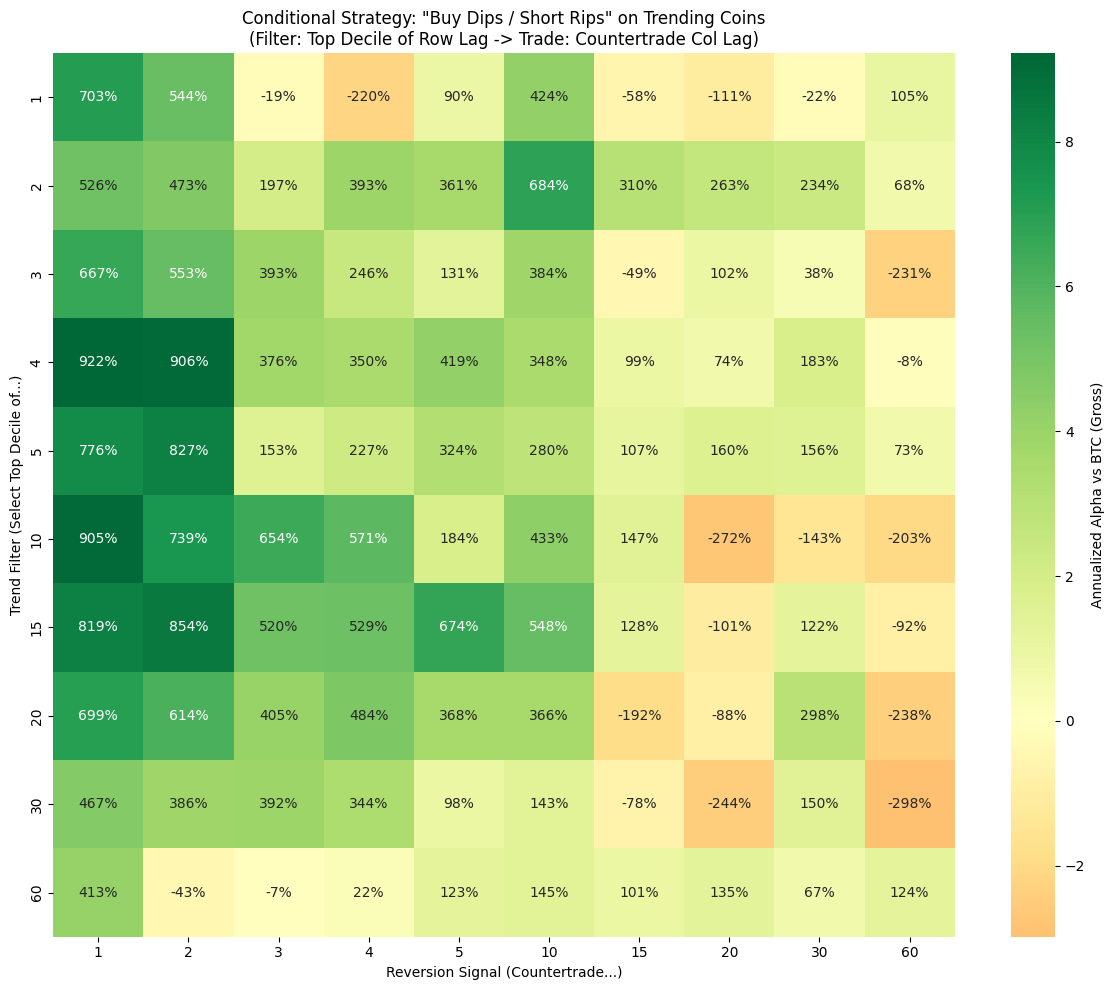

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import numpy as np

# 1. Get Benchmark (BTC) Annualized Return
# FIX: Use CTE to separate window calc from aggregation
btc_df = con.sql('''
    WITH daily_data AS (
        SELECT 
            ts,
            ln(close / lag(close) OVER (ORDER BY ts)) as log_ret
        FROM coins 
        WHERE symbol = 'btc'
    )
    SELECT 
        count(log_ret) as days,
        sum(log_ret) as total_log_ret
    FROM daily_data
''').df()

btc_ann_ret = (btc_df['total_log_ret'][0] / btc_df['days'][0]) * 365
print(f"Benchmark BTC Annual Return: {btc_ann_ret:.2%}")

# 2. Prepare Data (Wide Format) using DuckDB PIVOT
df_wide = con.sql('''
    PIVOT (
        select * from momentum 
        where year(ts) =2022
    )
    ON lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
    USING first(mom)
    GROUP BY ts, symbol, ret
    ORDER BY ts
''').pl()

# 3. Calculate Global Ranks for the "Long Lag" (Filter Step)
rank_cols = []
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]

exprs = [
    pl.col(str(l)).rank(method='ordinal').over('ts') / pl.col('symbol').count().over('ts')
    for l in lags
]
df_ranked = df_wide.with_columns([e.alias(f'rank_{l}') for l, e in zip(lags, exprs)])

# 4. Compute the Heatmap Matrix
matrix_data = []

# Loop 1: The Trend Filter (Long Lag)
for long_lag in lags:
    row = []
    
    # STEP A: Filter Universe to "Winners" (Top 10% of Long Lag)
    univ_mask = pl.col(f'rank_{long_lag}') >= 0.9
    df_univ = df_ranked.filter(univ_mask)
    
    # Loop 2: The Mean Reversion Signal (Short Lag)
    for short_lag in lags:
        # STEP B: Re-Rank coins WITHIN this "Winners" universe based on Short Lag
        strat_stats = (
            df_univ
            .select(['ts', 'ret', str(short_lag)])
            .with_columns([
                (pl.col(str(short_lag)).rank(method='ordinal').over('ts') / pl.count().over('ts')).alias('local_rank')
            ])
            .group_by('ts')
            .agg([
                # Long Leg: Bottom 10% (The Dips)
                pl.col('ret').filter(pl.col('local_rank') <= 0.1).mean().alias('long_ret'),
                # Short Leg: Top 10% (The Rips)
                pl.col('ret').filter(pl.col('local_rank') >= 0.9).mean().alias('short_ret')
            ])
            .select([
                # Daily Net Return = Long - Short
                (pl.col('long_ret') - pl.col('short_ret')).alias('net_ret')
            ])
            .drop_nulls()
        )
        
        # Check if we have enough data (avoid empty strategy errors)
        if strat_stats.height > 0:
            avg_daily_ret = strat_stats['net_ret'].mean()
            strat_ann = avg_daily_ret * 365
            alpha = strat_ann - btc_ann_ret
        else:
            alpha = 0.0 # No data for this combination
            
        row.append(alpha)
        
    matrix_data.append(row)

# 5. Visualization
df_heatmap = pd.DataFrame(matrix_data, index=lags, columns=lags)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_heatmap, 
    annot=True, 
    fmt='.0%', 
    cmap='RdYlGn', 
    center=0,
    cbar_kws={'label': 'Annualized Alpha vs BTC (Gross)'}
)

plt.title('Conditional Strategy: "Buy Dips / Short Rips" on Trending Coins\n(Filter: Top Decile of Row Lag -> Trade: Countertrade Col Lag)')
plt.ylabel('Trend Filter (Select Top Decile of...)')
plt.xlabel('Reversion Signal (Countertrade...)')
plt.tight_layout()
plt.show()

/Users/kai/studies/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- Strategy: Filter Top 20d Trend -> Countertrade 1d Move ---
--- Fee Rate: 0.2% ---


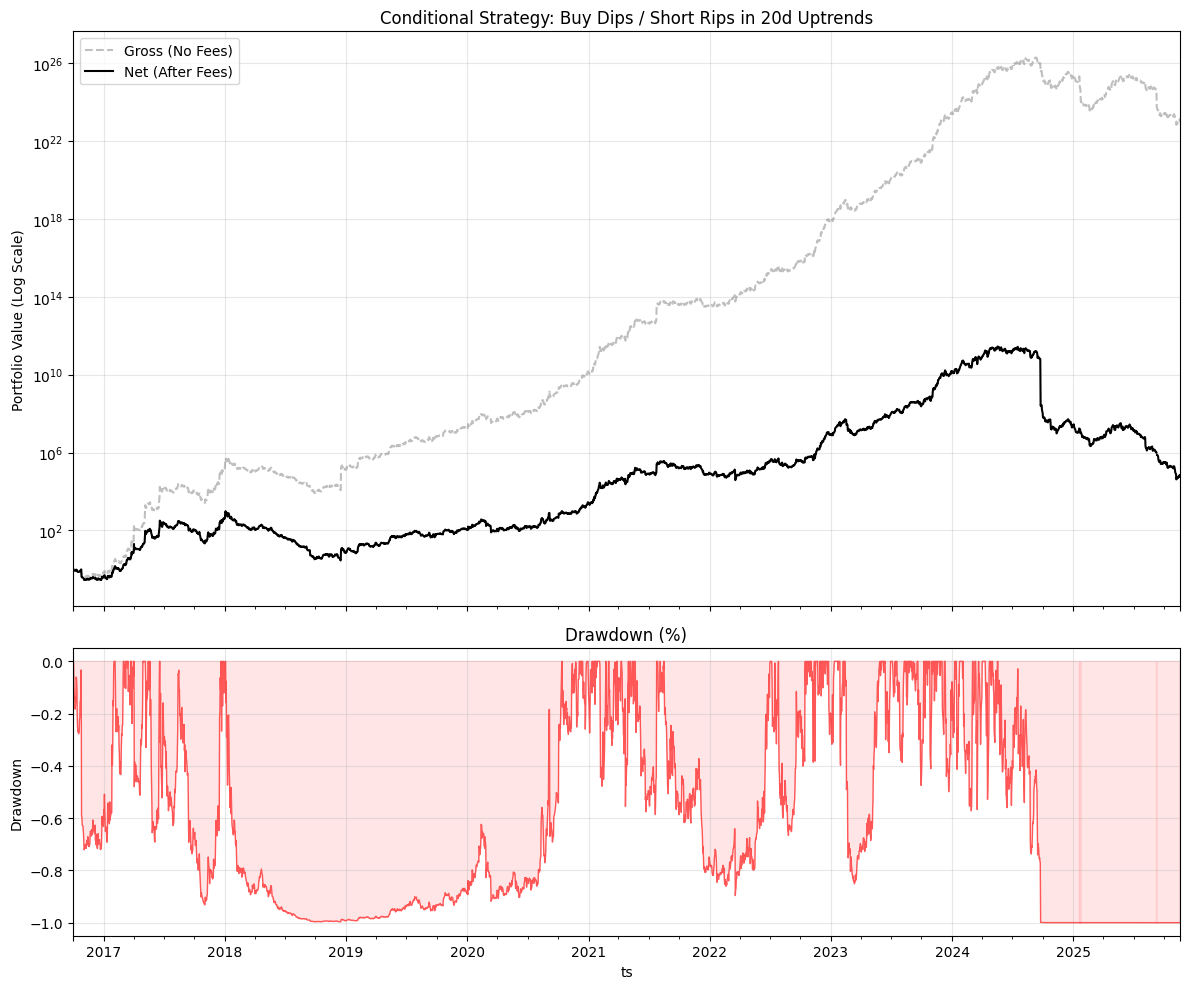

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
FILTER_LAG = 20   # The Trend (Long only the Top Decile of this)
SIGNAL_LAG = 1    # The Trigger (Counter-trade this)
FEE_RATE = 0.002  # 0.2% per trade
SMA_COL = 'vol20' # Volume weighting to ensure liquidity

# 1. Execute Backtest Logic in DuckDB
df_pnl = con.sql(f'''
    WITH base_data AS (
        SELECT 
            m_trend.ts,
            m_trend.symbol,
            m_trend.mom as mom_trend,
            m_signal.mom as mom_signal,
            -- Use Simple Returns for accurate Portfolio Aggregation
            exp(m_signal.ret) - 1 as ret_simple,
            s.{SMA_COL} as weight_metric
        FROM momentum m_trend
        JOIN momentum m_signal 
          ON m_trend.ts = m_signal.ts AND m_trend.symbol = m_signal.symbol
        JOIN sma s 
          ON m_trend.ts = s.ts AND m_trend.symbol = s.symbol
        WHERE m_trend.lag = {FILTER_LAG} 
          AND m_signal.lag = {SIGNAL_LAG}
          AND s.{SMA_COL} > 0
    ),
    -- STEP 1: Filter the Universe (Trend Following)
    trend_ranking AS (
        SELECT 
            *,
            -- Rank by Long-Term Trend
            ntile(10) OVER (PARTITION BY ts ORDER BY mom_trend ASC) as trend_rank
        FROM base_data
    ),
    filtered_universe AS (
        -- Keep ONLY the "Winners" (Top Decile)
        SELECT * FROM trend_ranking WHERE trend_rank = 10
    ),
    -- STEP 2: Generate Signals within Winners (Mean Reversion)
    signal_ranking AS (
        SELECT 
            *,
            -- Re-rank coins based on short-term move
            ntile(10) OVER (PARTITION BY ts ORDER BY mom_signal ASC) as signal_rank
        FROM filtered_universe
    ),
    bucket_stats AS (
        SELECT 
            ts, 
            signal_rank,
            sum(weight_metric) as total_bucket_vol
        FROM signal_ranking
        WHERE signal_rank IN (1, 10)
        GROUP BY 1, 2
    ),
    -- STEP 3: Assign Weights
    weights AS (
        SELECT
            r.ts,
            r.symbol,
            r.ret_simple,
            CASE 
                -- "Buy the Dip": Long the Bottom Decile of 1-Day move
                WHEN r.signal_rank = 1  THEN (r.weight_metric / bs.total_bucket_vol)
                
                -- "Short the Rip": Short the Top Decile of 1-Day move
                WHEN r.signal_rank = 10 THEN -1 * (r.weight_metric / bs.total_bucket_vol)
                
                ELSE 0.0 
            END as target_weight
        FROM signal_ranking r
        LEFT JOIN bucket_stats bs 
            -- FIX: The column name in bucket_stats is 'signal_rank', not 'mom_signal_rank'
            ON r.ts = bs.ts AND r.signal_rank = bs.signal_rank
    ),
    -- STEP 4: Calculate Turnover
    turnover_calc AS (
        SELECT
            ts,
            symbol,
            ret_simple,
            target_weight,
            -- Track weight changes from yesterday
            LAG(target_weight, 1, 0.0) OVER (PARTITION BY symbol ORDER BY ts) as prev_weight
        FROM weights
    )
    SELECT 
        ts,
        sum(target_weight * ret_simple) as gross_ret_simple,
        sum(abs(target_weight - prev_weight)) as turnover
    FROM turnover_calc
    WHERE abs(target_weight) > 0 OR abs(prev_weight) > 0
    GROUP BY ts
    ORDER BY ts
''').pl().to_pandas()

# 2. Net Returns Calculation
df_pnl['cost'] = df_pnl['turnover'] * FEE_RATE
df_pnl['net_ret_simple'] = df_pnl['gross_ret_simple'] - df_pnl['cost']
df_pnl['net_ret_log'] = np.log1p(df_pnl['net_ret_simple'])

# 3. Compute Metrics
stats = df_pnl.groupby(df_pnl['ts'].dt.year).agg(
    daily_mean=('net_ret_simple', 'mean'),
    daily_std=('net_ret_simple', 'std'),
    turnover_avg=('turnover', 'mean'),
    total_cost=('cost', 'sum'),
    total_ret=('net_ret_simple', 'sum') 
)

stats['Annual_Return'] = stats['daily_mean'] * 365
stats['Annual_Vol'] = stats['daily_std'] * np.sqrt(365)
stats['Sharpe_Ratio'] = stats['Annual_Return'] / stats['Annual_Vol']

print(f"--- Strategy: Filter Top {FILTER_LAG}d Trend -> Countertrade {SIGNAL_LAG}d Move ---")
print(f"--- Fee Rate: {FEE_RATE*100:.1f}% ---")
display_cols = ['total_ret', 'Annual_Return', 'Sharpe_Ratio', 'turnover_avg', 'total_cost']
print(stats[display_cols].style.format("{:.2f}"))

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Cumulative PnL
df_pnl.set_index('ts')['gross_ret_simple'].cumsum().apply(lambda x: np.exp(x)).plot(ax=ax1, label='Gross (No Fees)', color='grey', linestyle='--', alpha=0.5)
df_pnl.set_index('ts')['net_ret_log'].cumsum().apply(np.exp).plot(ax=ax1, label='Net (After Fees)', color='black')

ax1.set_title(f'Conditional Strategy: Buy Dips / Short Rips in {FILTER_LAG}d Uptrends')
ax1.set_ylabel('Portfolio Value (Log Scale)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown
cumulative = df_pnl.set_index('ts')['net_ret_log'].cumsum().apply(np.exp)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
drawdown.plot(ax=ax2, color='red', alpha=0.6, linewidth=1)
ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.1)

ax2.set_title('Drawdown (%)')
ax2.set_ylabel('Drawdown')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Fetching 2024 data...
BTC Cumulative Log Return (2024): 78.60%
Running 100 Backtests (Days=688, Fee=0.2%)...


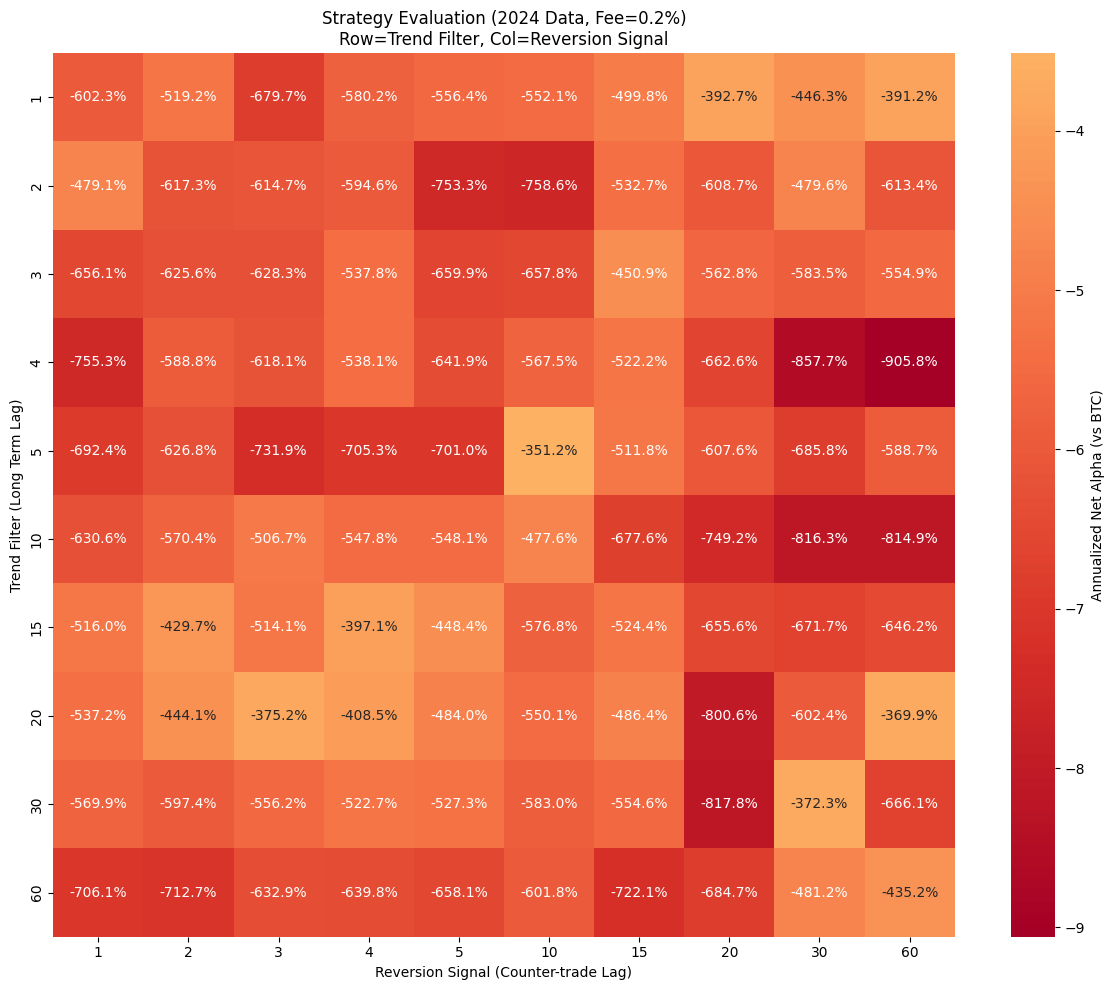

In [40]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fetch Data (DuckDB -> Polars) ---
print("Fetching 2024 data...")

# FIX: Use 'ts' for filtering instead of 'rowid'
btc_ret_2024 = con.sql("""
    WITH daily_ret AS (
        SELECT 
            ts,
            ln(close / lag(close) OVER (ORDER BY ts)) as log_ret
        FROM coins 
        WHERE symbol = 'btc' 
    )
    SELECT sum(log_ret) 
    FROM daily_ret
    WHERE ts >= '2024-01-01'
""").fetchone()[0]

# Fallback in case of data gaps/nulls
if btc_ret_2024 is None:
    btc_ret_2024 = 0.0

print(f"BTC Cumulative Log Return (2024): {btc_ret_2024:.2%}")

# Get Strategy Data
df_raw = con.sql("""
    WITH mom_wide AS (
        PIVOT momentum 
        ON lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
        USING first(mom)
        GROUP BY ts, symbol, ret
    )
    SELECT 
        m.ts,
        m.symbol,
        exp(m.ret) - 1 as ret, -- Simple Return
        c.volume,
        m."1" as mom_1, m."2" as mom_2, m."3" as mom_3, m."4" as mom_4, m."5" as mom_5,
        m."10" as mom_10, m."15" as mom_15, m."20" as mom_20, m."30" as mom_30, m."60" as mom_60
    FROM mom_wide m
    JOIN coins c ON m.ts = c.ts AND m.symbol = c.symbol
    WHERE m.ts >= '2024-01-01'
    ORDER BY m.ts
""").pl()

# Calculate days for annualization
n_days = df_raw['ts'].n_unique()
if n_days > 0:
    btc_ann_ret = (btc_ret_2024 / n_days) * 365
else:
    btc_ann_ret = 0.0

# --- 2. Pre-Compute Global Ranks (Polars) ---
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
FEE = 0.002

# Calculate ranks for all columns at once
exprs = [
    (pl.col(f'mom_{l}').rank(method='ordinal').over('ts') / pl.col('symbol').count().over('ts')).alias(f'grank_{l}')
    for l in lags
]
df = df_raw.with_columns(exprs)

# --- 3. Run 10x10 Backtest Loop ---
print(f"Running 100 Backtests (Days={n_days}, Fee={FEE*100:.1f}%)...")
results = []

for filter_lag in lags:
    row_res = []
    
    # Filter Universe: Top Decile of Trend
    universe_mask = pl.col(f'grank_{filter_lag}') >= 0.9
    
    for signal_lag in lags:
        # SIGNAL STEP: Counter-trade the Short Term Move
        
        # Subset to valid universe
        subset = df.filter(universe_mask).select(['ts', 'symbol', 'ret', 'volume', f'mom_{signal_lag}'])
        
        if subset.height == 0:
            row_res.append(0.0)
            continue

        # Re-Rank locally within this universe
        # We re-calculate rank because the "bottom 10%" of the Winners 
        # is different from the "bottom 10%" of the Global market.
        subset = subset.with_columns(
            (pl.col(f'mom_{signal_lag}').rank(method='ordinal').over('ts') / pl.len().over('ts')).alias('local_rank')
        )
        
        # Assign Weights (Long Bottom 10%, Short Top 10%)
        # Note: We use dynamic volume weighting
        subset = subset.with_columns([
            pl.when(pl.col('local_rank') <= 0.1).then(pl.col('volume'))
              .when(pl.col('local_rank') >= 0.9).then(pl.col('volume') * -1)
              .otherwise(0).alias('raw_w')
        ])
        
        # Normalize Weights Daily
        subset = subset.with_columns(
            pl.col('raw_w').abs().sum().over('ts').alias('daily_vol_sum')
        )
        
        subset = subset.with_columns(
            (pl.col('raw_w') / pl.col('daily_vol_sum')).fill_nan(0).alias('weight')
        )
        
        # Turnover Estimation (Heuristic)
        # Lag 1 flips daily (high turnover), Lag 60 flips slowly (low turnover)
        est_turnover_pct = 0.2 + (1.0 / signal_lag)
        if signal_lag == 1: est_turnover_pct = 1.8 
        
        # Annualize Average Daily Net Return
        # 1. Sum weighted returns per day (Portfolio Return)
        # 2. Subtract Fee from that daily return
        # 3. Average over all days
        daily_pnl = subset.group_by('ts').agg((pl.col('weight')*pl.col('ret')).sum().alias('pnl'))
        avg_net_ret = daily_pnl['pnl'].mean() - (est_turnover_pct * FEE)
        
        ann_ret = avg_net_ret * 365
        alpha = ann_ret - btc_ann_ret
        
        row_res.append(alpha)
        
    results.append(row_res)

# --- 4. Visualization ---
df_hm = pd.DataFrame(results, index=lags, columns=lags)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_hm, 
    annot=True, 
    fmt='.1%', 
    cmap='RdYlGn', 
    center=0,
    cbar_kws={'label': 'Annualized Net Alpha (vs BTC)'}
)
plt.title(f'Strategy Evaluation (2024 Data, Fee={FEE*100}%)\nRow=Trend Filter, Col=Reversion Signal')
plt.ylabel('Trend Filter (Long Term Lag)')
plt.xlabel('Reversion Signal (Counter-trade Lag)')
plt.tight_layout()
plt.show()

Fetching 2024 data...
BTC Cumulative Log Return (2024): 78.60%
Running 100 Backtests (Trend Following, Fee=0.2%)...


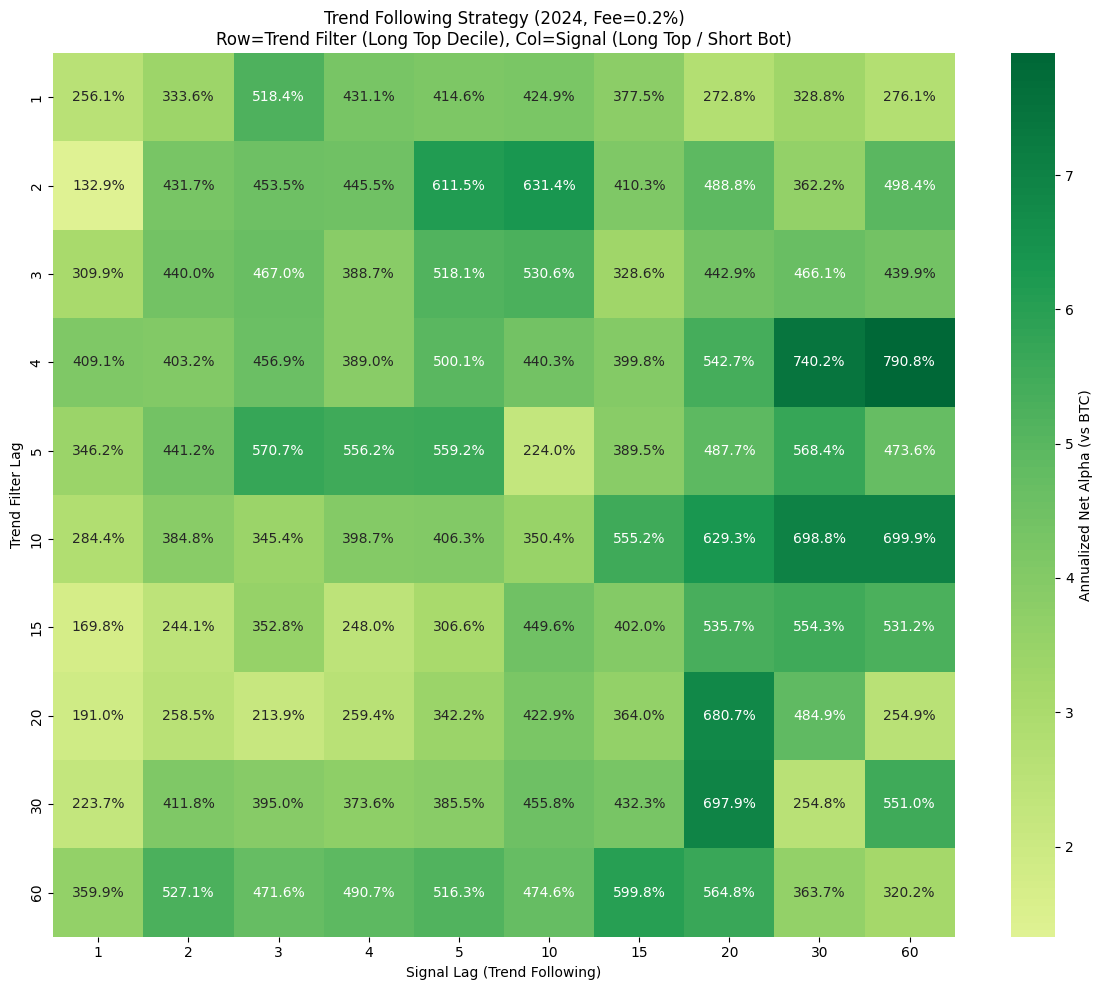

In [41]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fetch Data (DuckDB -> Polars) ---
print("Fetching 2024 data...")

# BTC Benchmark (Robust Fetch)
btc_ret_2024 = con.sql("""
    WITH daily_ret AS (
        SELECT 
            ts,
            ln(close / lag(close) OVER (ORDER BY ts)) as log_ret
        FROM coins 
        WHERE symbol = 'btc' 
    )
    SELECT sum(log_ret) 
    FROM daily_ret
    WHERE ts >= '2024-01-01'
""").fetchone()[0]

if btc_ret_2024 is None: btc_ret_2024 = 0.0
print(f"BTC Cumulative Log Return (2024): {btc_ret_2024:.2%}")

# Strategy Data
df_raw = con.sql("""
    WITH mom_wide AS (
        PIVOT momentum 
        ON lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
        USING first(mom)
        GROUP BY ts, symbol, ret
    )
    SELECT 
        m.ts,
        m.symbol,
        exp(m.ret) - 1 as ret, -- Simple Return
        c.volume,
        m."1" as mom_1, m."2" as mom_2, m."3" as mom_3, m."4" as mom_4, m."5" as mom_5,
        m."10" as mom_10, m."15" as mom_15, m."20" as mom_20, m."30" as mom_30, m."60" as mom_60
    FROM mom_wide m
    JOIN coins c ON m.ts = c.ts AND m.symbol = c.symbol
    WHERE m.ts >= '2024-01-01'
    ORDER BY m.ts
""").pl()

n_days = df_raw['ts'].n_unique()
if n_days > 0:
    btc_ann_ret = (btc_ret_2024 / n_days) * 365
else:
    btc_ann_ret = 0.0

# --- 2. Pre-Compute Global Ranks ---
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
FEE = 0.002

exprs = [
    (pl.col(f'mom_{l}').rank(method='ordinal').over('ts') / pl.col('symbol').count().over('ts')).alias(f'grank_{l}')
    for l in lags
]
df = df_raw.with_columns(exprs)

# --- 3. Run 10x10 Backtest Loop (Trend Following) ---
print(f"Running 100 Backtests (Trend Following, Fee={FEE*100:.1f}%)...")
results = []

for filter_lag in lags:
    row_res = []
    
    # Filter: Top Decile (Uptrend)
    universe_mask = pl.col(f'grank_{filter_lag}') >= 0.9
    
    for signal_lag in lags:
        subset = df.filter(universe_mask).select(['ts', 'symbol', 'ret', 'volume', f'mom_{signal_lag}'])
        
        if subset.height == 0:
            row_res.append(0.0)
            continue

        # Re-Rank locally
        subset = subset.with_columns(
            (pl.col(f'mom_{signal_lag}').rank(method='ordinal').over('ts') / pl.len().over('ts')).alias('local_rank')
        )
        
        # --- LOGIC SWITCH: TREND FOLLOWING ---
        # Long the Top 10% (Winners)
        # Short the Bottom 10% (Losers)
        subset = subset.with_columns([
            pl.when(pl.col('local_rank') >= 0.9).then(pl.col('volume'))       # LONG WINNERS
              .when(pl.col('local_rank') <= 0.1).then(pl.col('volume') * -1)  # SHORT LOSERS
              .otherwise(0).alias('raw_w')
        ])
        
        # Normalize
        subset = subset.with_columns(
            pl.col('raw_w').abs().sum().over('ts').alias('daily_vol_sum')
        )
        subset = subset.with_columns(
            (pl.col('raw_w') / pl.col('daily_vol_sum')).fill_nan(0).alias('weight')
        )
        
        # Turnover Estimation
        est_turnover_pct = 0.2 + (1.0 / signal_lag)
        if signal_lag == 1: est_turnover_pct = 1.8 
        
        # Returns
        daily_pnl = subset.group_by('ts').agg((pl.col('weight')*pl.col('ret')).sum().alias('pnl'))
        avg_net_ret = daily_pnl['pnl'].mean() - (est_turnover_pct * FEE)
        
        ann_ret = avg_net_ret * 365
        alpha = ann_ret - btc_ann_ret
        
        row_res.append(alpha)
        
    results.append(row_res)

# --- 4. Visualization ---
df_hm = pd.DataFrame(results, index=lags, columns=lags)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_hm, 
    annot=True, 
    fmt='.1%', 
    cmap='RdYlGn', 
    center=0,
    cbar_kws={'label': 'Annualized Net Alpha (vs BTC)'}
)
plt.title(f'Trend Following Strategy (2024, Fee={FEE*100}%)\nRow=Trend Filter (Long Top Decile), Col=Signal (Long Top / Short Bot)')
plt.ylabel('Trend Filter Lag')
plt.xlabel('Signal Lag (Trend Following)')
plt.tight_layout()
plt.show()

Fetching 2024 data for Sharpe Analysis...
Running 100 Backtests (Target: Sharpe Ratio, Fee=0.2%)...


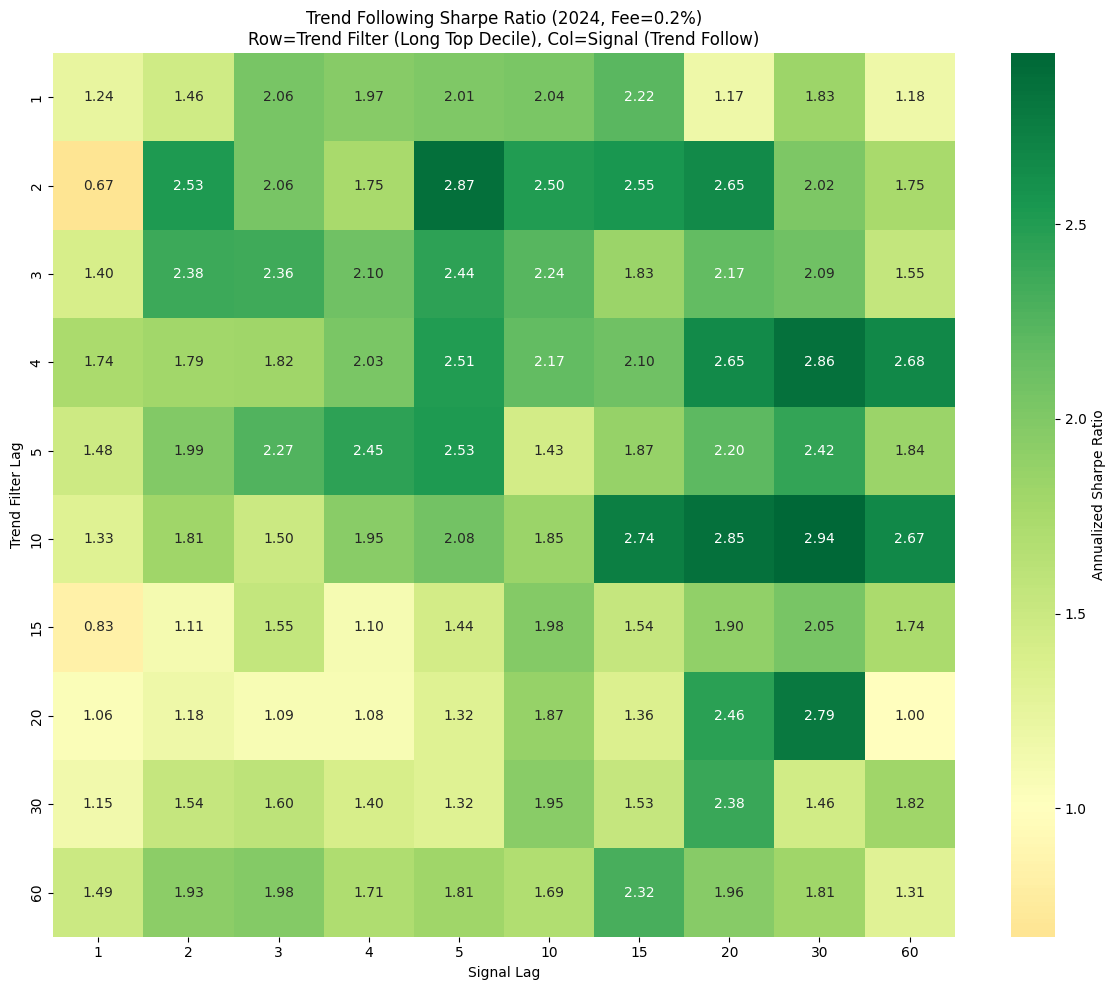

In [42]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fetch Data (DuckDB -> Polars) ---
print("Fetching 2024 data for Sharpe Analysis...")

# Get Strategy Data
df_raw = con.sql("""
    WITH mom_wide AS (
        PIVOT momentum 
        ON lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
        USING first(mom)
        GROUP BY ts, symbol, ret
    )
    SELECT 
        m.ts,
        m.symbol,
        exp(m.ret) - 1 as ret, -- Simple Return
        c.volume,
        m."1" as mom_1, m."2" as mom_2, m."3" as mom_3, m."4" as mom_4, m."5" as mom_5,
        m."10" as mom_10, m."15" as mom_15, m."20" as mom_20, m."30" as mom_30, m."60" as mom_60
    FROM mom_wide m
    JOIN coins c ON m.ts = c.ts AND m.symbol = c.symbol
    WHERE m.ts >= '2024-01-01'
    ORDER BY m.ts
""").pl()

# --- 2. Pre-Compute Global Ranks ---
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
FEE = 0.002

exprs = [
    (pl.col(f'mom_{l}').rank(method='ordinal').over('ts') / pl.col('symbol').count().over('ts')).alias(f'grank_{l}')
    for l in lags
]
df = df_raw.with_columns(exprs)

# --- 3. Run 10x10 Backtest Loop (Trend Following) ---
print(f"Running 100 Backtests (Target: Sharpe Ratio, Fee={FEE*100:.1f}%)...")
results = []

for filter_lag in lags:
    row_res = []
    
    # Filter: Top Decile (Uptrend)
    universe_mask = pl.col(f'grank_{filter_lag}') >= 0.9
    
    for signal_lag in lags:
        subset = df.filter(universe_mask).select(['ts', 'symbol', 'ret', 'volume', f'mom_{signal_lag}'])
        
        if subset.height == 0:
            row_res.append(0.0)
            continue

        # Re-Rank locally
        subset = subset.with_columns(
            (pl.col(f'mom_{signal_lag}').rank(method='ordinal').over('ts') / pl.len().over('ts')).alias('local_rank')
        )
        
        # --- LOGIC: TREND FOLLOWING ---
        # Long Winners (Top 10%), Short Losers (Bottom 10%)
        subset = subset.with_columns([
            pl.when(pl.col('local_rank') >= 0.9).then(pl.col('volume'))       # LONG
              .when(pl.col('local_rank') <= 0.1).then(pl.col('volume') * -1)  # SHORT
              .otherwise(0).alias('raw_w')
        ])
        
        # Normalize
        subset = subset.with_columns(
            pl.col('raw_w').abs().sum().over('ts').alias('daily_vol_sum')
        )
        subset = subset.with_columns(
            (pl.col('raw_w') / pl.col('daily_vol_sum')).fill_nan(0).alias('weight')
        )
        
        # Returns
        daily_pnl = subset.group_by('ts').agg((pl.col('weight')*pl.col('ret')).sum().alias('gross_pnl'))
        
        # Turnover & Fees
        est_turnover_pct = 0.2 + (1.0 / signal_lag)
        if signal_lag == 1: est_turnover_pct = 1.8 
        daily_cost = est_turnover_pct * FEE
        
        # Net Daily PnL
        daily_pnl = daily_pnl.with_columns(
            (pl.col('gross_pnl') - daily_cost).alias('net_pnl')
        )
        
        # --- SHARPE RATIO CALCULATION ---
        mean_ret = daily_pnl['net_pnl'].mean()
        std_ret = daily_pnl['net_pnl'].std()
        
        if std_ret > 0:
            sharpe = (mean_ret / std_ret) * np.sqrt(365)
        else:
            sharpe = 0.0
            
        row_res.append(sharpe)
        
    results.append(row_res)

# --- 4. Visualization ---
df_hm = pd.DataFrame(results, index=lags, columns=lags)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_hm, 
    annot=True, 
    fmt='.2f', 
    cmap='RdYlGn', 
    center=1.0,  # Center at Sharpe 1.0 (Good) rather than 0
    cbar_kws={'label': 'Annualized Sharpe Ratio'}
)
plt.title(f'Trend Following Sharpe Ratio (2024, Fee={FEE*100}%)\nRow=Trend Filter (Long Top Decile), Col=Signal (Trend Follow)')
plt.ylabel('Trend Filter Lag')
plt.xlabel('Signal Lag')
plt.tight_layout()
plt.show()

Fetching 2024 data (7-Day Horizon)...
BTC Cumulative Log Return (Weekly sampled): 74.12%
Running 100 Backtests (Weekly Hold, Fee=0.2%)...


/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/2404543820.py:97: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  subset = subset.filter(pl.col('ts').is_in(trading_days))


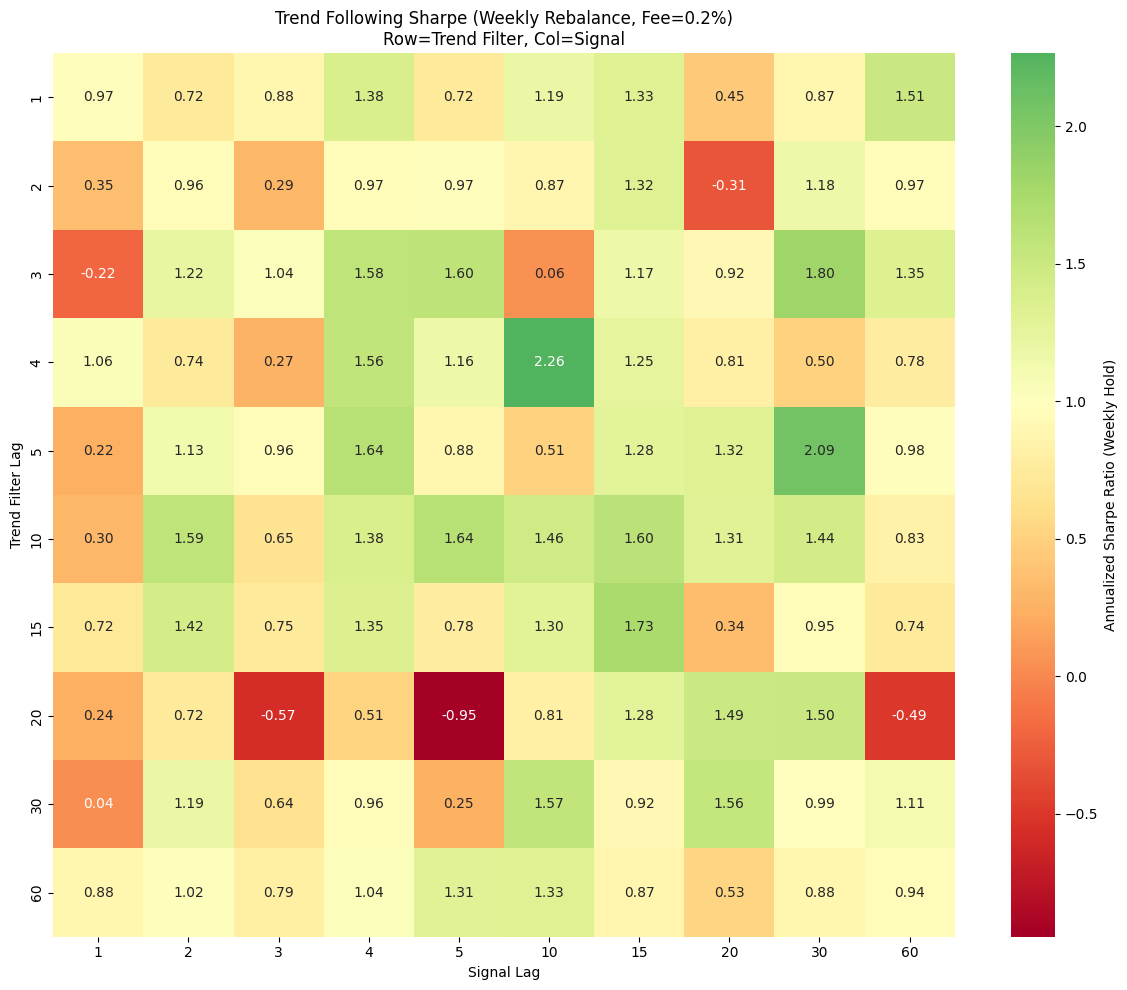

In [44]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fetch Data (DuckDB -> Polars) ---
print("Fetching 2024 data (7-Day Horizon)...")

# BTC Benchmark (Weekly) - Fixed to use only Close prices
btc_ret_2024 = con.sql("""
    WITH daily_log AS (
        SELECT 
            ts, 
            ln(close / lag(close) OVER (ORDER BY ts)) as log_ret
        FROM coins 
        WHERE symbol = 'btc'
    ),
    weekly_agg AS (
        SELECT 
            ts,
            -- Sum next 7 days of log returns
            sum(log_ret) OVER (
                ORDER BY ts ROWS BETWEEN 1 FOLLOWING AND 7 FOLLOWING
            ) as ret_7d_log
        FROM daily_log
    )
    SELECT sum(ret_7d_log)
    FROM weekly_agg
    WHERE ts >= '2024-01-01' 
      AND (date_diff('day', DATE '2024-01-01', ts) % 7 = 0)
""").fetchone()[0]

if btc_ret_2024 is None: btc_ret_2024 = 0.0
print(f"BTC Cumulative Log Return (Weekly sampled): {btc_ret_2024:.2%}")

# Strategy Data
# FIX: Use LEAD(close, 7) instead of close/open logic
df_raw = con.sql("""
    WITH mom_wide AS (
        PIVOT momentum 
        ON lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
        USING first(mom)
        GROUP BY ts, symbol, ret
    ),
    forward_returns AS (
        SELECT 
            m.ts,
            m.symbol,
            c.volume,
            
            -- FIX: Forward Return = (Price in 7 days / Price Today) - 1
            (LEAD(c.close, 7) OVER (
                PARTITION BY m.symbol ORDER BY m.ts
            ) / c.close) - 1 as ret_1w,
            
            m."1" as mom_1, m."2" as mom_2, m."3" as mom_3, m."4" as mom_4, m."5" as mom_5,
            m."10" as mom_10, m."15" as mom_15, m."20" as mom_20, m."30" as mom_30, m."60" as mom_60
        FROM mom_wide m
        JOIN coins c ON m.ts = c.ts AND m.symbol = c.symbol
    )
    SELECT * FROM forward_returns
    WHERE ts >= '2024-01-01'
    ORDER BY ts
""").pl()

# --- 2. Pre-Compute Global Ranks ---
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
FEE = 0.002

# Calculate ranks on the full daily dataset
exprs = [
    (pl.col(f'mom_{l}').rank(method='ordinal').over('ts') / pl.col('symbol').count().over('ts')).alias(f'grank_{l}')
    for l in lags
]
df = df_raw.with_columns(exprs)

# --- 3. Run 10x10 Backtest Loop (Weekly Rebalance) ---
print(f"Running 100 Backtests (Weekly Hold, Fee={FEE*100:.1f}%)...")
results = []

# Define sampling mask (Fridays, or every 7th index)
dates = df['ts'].unique().sort()
trading_days = dates.gather(pl.arange(0, dates.len(), 7))

for filter_lag in lags:
    row_res = []
    
    # FILTER: Top Decile (Uptrend)
    universe_mask = pl.col(f'grank_{filter_lag}') >= 0.9
    
    for signal_lag in lags:
        # 1. Subset
        subset = df.filter(universe_mask).select(['ts', 'symbol', 'ret_1w', 'volume', f'mom_{signal_lag}'])
        
        # 2. Downsample to Weekly Trading Days
        subset = subset.filter(pl.col('ts').is_in(trading_days))
        
        if subset.height == 0:
            row_res.append(0.0)
            continue

        # 3. Re-Rank locally
        subset = subset.with_columns(
            (pl.col(f'mom_{signal_lag}').rank(method='ordinal').over('ts') / pl.len().over('ts')).alias('local_rank')
        )
        
        # 4. Logic: TREND FOLLOWING
        subset = subset.with_columns([
            pl.when(pl.col('local_rank') >= 0.9).then(pl.col('volume'))       # LONG
              .when(pl.col('local_rank') <= 0.1).then(pl.col('volume') * -1)  # SHORT
              .otherwise(0).alias('raw_w')
        ])
        
        # 5. Normalize
        subset = subset.with_columns(
            pl.col('raw_w').abs().sum().over('ts').alias('weekly_vol_sum')
        )
        subset = subset.with_columns(
            (pl.col('raw_w') / pl.col('weekly_vol_sum')).fill_nan(0).alias('weight')
        )
        
        # 6. Returns (Weekly)
        weekly_pnl = subset.group_by('ts').agg((pl.col('weight')*pl.col('ret_1w')).sum().alias('gross_pnl'))
        
        # 7. Turnover (Conservative Weekly Estimate)
        est_turnover_pct = 0.4 + (0.6 / signal_lag) 
        if signal_lag == 1: est_turnover_pct = 1.2 
        
        weekly_cost = est_turnover_pct * FEE
        
        weekly_pnl = weekly_pnl.with_columns(
            (pl.col('gross_pnl') - weekly_cost).alias('net_pnl')
        )
        
        # 8. Sharpe Ratio (Annualized)
        mean_ret = weekly_pnl['net_pnl'].mean()
        std_ret = weekly_pnl['net_pnl'].std()
        
        if std_ret > 0:
            sharpe = (mean_ret / std_ret) * np.sqrt(52)
        else:
            sharpe = 0.0
            
        row_res.append(sharpe)
        
    results.append(row_res)

# --- 4. Visualization ---
df_hm = pd.DataFrame(results, index=lags, columns=lags)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_hm, 
    annot=True, 
    fmt='.2f', 
    cmap='RdYlGn', 
    center=1.0,
    cbar_kws={'label': 'Annualized Sharpe Ratio (Weekly Hold)'}
)
plt.title(f'Trend Following Sharpe (Weekly Rebalance, Fee={FEE*100}%)\nRow=Trend Filter, Col=Signal')
plt.ylabel('Trend Filter Lag')
plt.xlabel('Signal Lag')
plt.tight_layout()
plt.show()

Fetching 2024 data (3-Day Horizon)...
BTC Cumulative Log Return (3-Day sampled): 80.68%
Running 100 Backtests (3-Day Hold, Fee=0.2%)...


/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/3547356612.py:95: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  subset = subset.filter(pl.col('ts').is_in(trading_days))


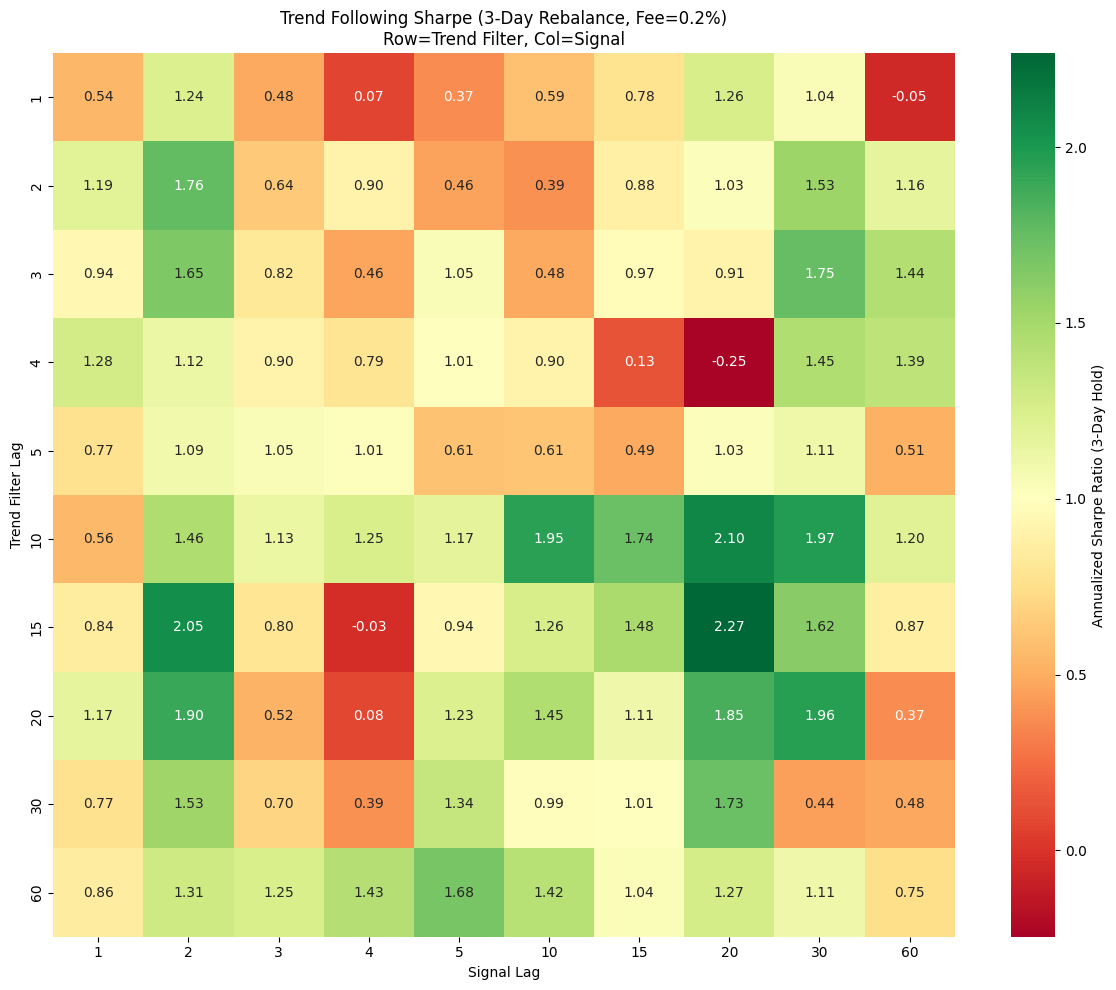

In [45]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fetch Data (DuckDB -> Polars) ---
print("Fetching 2024 data (3-Day Horizon)...")

# BTC Benchmark (Sampled every 3 days)
btc_ret_2024 = con.sql("""
    WITH daily_log AS (
        SELECT 
            ts, 
            ln(close / lag(close) OVER (ORDER BY ts)) as log_ret
        FROM coins 
        WHERE symbol = 'btc'
    ),
    three_day_agg AS (
        SELECT 
            ts,
            -- Sum next 3 days of log returns
            sum(log_ret) OVER (
                ORDER BY ts ROWS BETWEEN 1 FOLLOWING AND 3 FOLLOWING
            ) as ret_3d_log
        FROM daily_log
    )
    SELECT sum(ret_3d_log)
    FROM three_day_agg
    WHERE ts >= '2024-01-01' 
      AND (date_diff('day', DATE '2024-01-01', ts) % 3 = 0)
""").fetchone()[0]

if btc_ret_2024 is None: btc_ret_2024 = 0.0
print(f"BTC Cumulative Log Return (3-Day sampled): {btc_ret_2024:.2%}")

# Strategy Data
# FIX: Use LEAD(close, 3) for 3-day return
df_raw = con.sql("""
    WITH mom_wide AS (
        PIVOT momentum 
        ON lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
        USING first(mom)
        GROUP BY ts, symbol, ret
    ),
    forward_returns AS (
        SELECT 
            m.ts,
            m.symbol,
            c.volume,
            
            -- FIX: Forward Return = (Price in 3 days / Price Today) - 1
            (LEAD(c.close, 3) OVER (
                PARTITION BY m.symbol ORDER BY m.ts
            ) / c.close) - 1 as ret_3d,
            
            m."1" as mom_1, m."2" as mom_2, m."3" as mom_3, m."4" as mom_4, m."5" as mom_5,
            m."10" as mom_10, m."15" as mom_15, m."20" as mom_20, m."30" as mom_30, m."60" as mom_60
        FROM mom_wide m
        JOIN coins c ON m.ts = c.ts AND m.symbol = c.symbol
    )
    SELECT * FROM forward_returns
    WHERE ts >= '2024-01-01'
    ORDER BY ts
""").pl()

# --- 2. Pre-Compute Global Ranks ---
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
FEE = 0.002

exprs = [
    (pl.col(f'mom_{l}').rank(method='ordinal').over('ts') / pl.col('symbol').count().over('ts')).alias(f'grank_{l}')
    for l in lags
]
df = df_raw.with_columns(exprs)

# --- 3. Run 10x10 Backtest Loop (3-Day Rebalance) ---
print(f"Running 100 Backtests (3-Day Hold, Fee={FEE*100:.1f}%)...")
results = []

# Define sampling mask (Every 3rd day)
dates = df['ts'].unique().sort()
trading_days = dates.gather(pl.arange(0, dates.len(), 3))

for filter_lag in lags:
    row_res = []
    
    # FILTER: Top Decile (Uptrend)
    universe_mask = pl.col(f'grank_{filter_lag}') >= 0.9
    
    for signal_lag in lags:
        subset = df.filter(universe_mask).select(['ts', 'symbol', 'ret_3d', 'volume', f'mom_{signal_lag}'])
        
        # Downsample to Trading Days
        subset = subset.filter(pl.col('ts').is_in(trading_days))
        
        if subset.height == 0:
            row_res.append(0.0)
            continue

        # Re-Rank locally
        subset = subset.with_columns(
            (pl.col(f'mom_{signal_lag}').rank(method='ordinal').over('ts') / pl.len().over('ts')).alias('local_rank')
        )
        
        # Logic: Trend Following
        subset = subset.with_columns([
            pl.when(pl.col('local_rank') >= 0.9).then(pl.col('volume'))       # LONG
              .when(pl.col('local_rank') <= 0.1).then(pl.col('volume') * -1)  # SHORT
              .otherwise(0).alias('raw_w')
        ])
        
        # Normalize
        subset = subset.with_columns(
            pl.col('raw_w').abs().sum().over('ts').alias('period_vol_sum')
        )
        subset = subset.with_columns(
            (pl.col('raw_w') / pl.col('period_vol_sum')).fill_nan(0).alias('weight')
        )
        
        # Returns (3-Day)
        period_pnl = subset.group_by('ts').agg((pl.col('weight')*pl.col('ret_3d')).sum().alias('gross_pnl'))
        
        # Turnover Estimate (Every 3 days)
        # Turnover is slightly higher than weekly because we re-rank more often
        # Estimate: 60% for slow signals, 100% for fast
        est_turnover_pct = 0.6 + (0.4 / signal_lag) 
        if signal_lag == 1: est_turnover_pct = 1.4 
        
        period_cost = est_turnover_pct * FEE
        
        period_pnl = period_pnl.with_columns(
            (pl.col('gross_pnl') - period_cost).alias('net_pnl')
        )
        
        # Sharpe Ratio (Annualized)
        mean_ret = period_pnl['net_pnl'].mean()
        std_ret = period_pnl['net_pnl'].std()
        
        if std_ret > 0:
            # Approx 121.6 periods of 3 days in a year
            periods_per_year = 365 / 3
            sharpe = (mean_ret / std_ret) * np.sqrt(periods_per_year)
        else:
            sharpe = 0.0
            
        row_res.append(sharpe)
        
    results.append(row_res)

# --- 4. Visualization ---
df_hm = pd.DataFrame(results, index=lags, columns=lags)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_hm, 
    annot=True, 
    fmt='.2f', 
    cmap='RdYlGn', 
    center=1.0,
    cbar_kws={'label': 'Annualized Sharpe Ratio (3-Day Hold)'}
)
plt.title(f'Trend Following Sharpe (3-Day Rebalance, Fee={FEE*100}%)\nRow=Trend Filter, Col=Signal')
plt.ylabel('Trend Filter Lag')
plt.xlabel('Signal Lag')
plt.tight_layout()
plt.show()

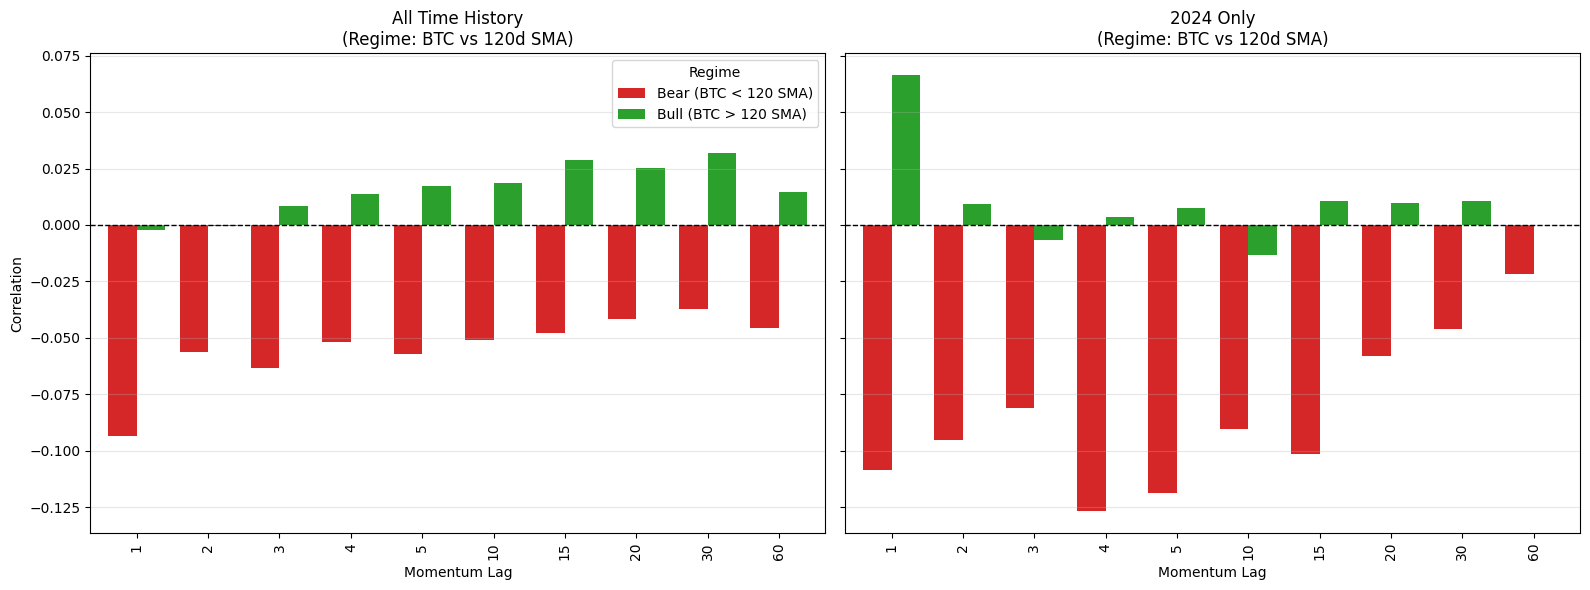

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Compute Regimes & Correlations for Both Periods
df_comparison = con.sql('''
    WITH btc_stats AS (
        SELECT 
            ts,
            close,
            -- Calculate 120-Day SMA for BTC
            avg(close) OVER (
                ORDER BY ts ROWS BETWEEN 119 PRECEDING AND CURRENT ROW
            ) as sma_120
        FROM coins
        WHERE symbol = 'btc'
    ),
    daily_regime AS (
        SELECT 
            ts,
            CASE 
                WHEN close > sma_120 THEN 'Bull (BTC > 120 SMA)' 
                ELSE 'Bear (BTC < 120 SMA)' 
            END as regime
        FROM btc_stats
        WHERE sma_120 IS NOT NULL
    ),
    base_data AS (
        SELECT 
            m.ts,
            m.lag,
            m.mom,
            m.ret,
            r.regime
        FROM momentum m
        JOIN daily_regime r ON m.ts = r.ts
        WHERE m.lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
    ),
    -- Aggregation 1: All Time
    stats_all AS (
        SELECT 
            'All Time' as period,
            lag,
            regime,
            corr(mom, ret) as correlation
        FROM base_data
        GROUP BY 1, 2, 3
    ),
    -- Aggregation 2: 2024 Only
    stats_2024 AS (
        SELECT 
            '2024 Only' as period,
            lag,
            regime,
            corr(mom, ret) as correlation
        FROM base_data
        WHERE ts >= '2025-01-01'
        GROUP BY 1, 2, 3
    )
    SELECT * FROM stats_all
    UNION ALL
    SELECT * FROM stats_2024
    ORDER BY period, lag, regime
''').df()

# 2. Pivot for Plotting
# We need two separate dataframes for the subplots
df_all = df_comparison[df_comparison['period'] == 'All Time'].pivot(index='lag', columns='regime', values='correlation')
df_24  = df_comparison[df_comparison['period'] == '2024 Only'].pivot(index='lag', columns='regime', values='correlation')

# 3. Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: All Time
df_all.plot(kind='bar', ax=axes[0], width=0.8, color=['#d62728', '#2ca02c']) # Red/Green
axes[0].set_title('All Time History\n(Regime: BTC vs 120d SMA)')
axes[0].set_ylabel('Correlation')
axes[0].set_xlabel('Momentum Lag')
axes[0].axhline(0, color='black', linewidth=1, linestyle='--')
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(title='Regime')

# Plot 2: 2024 Only
df_24.plot(kind='bar', ax=axes[1], width=0.8, color=['#d62728', '#2ca02c'])
axes[1].set_title('2024 Only\n(Regime: BTC vs 120d SMA)')
axes[1].set_xlabel('Momentum Lag')
axes[1].axhline(0, color='black', linewidth=1, linestyle='--')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend().remove() # Remove legend to reduce clutter (same as left)

plt.tight_layout()
plt.show()


Mean reversion is stronger execpt for positive momentum in bull markets.

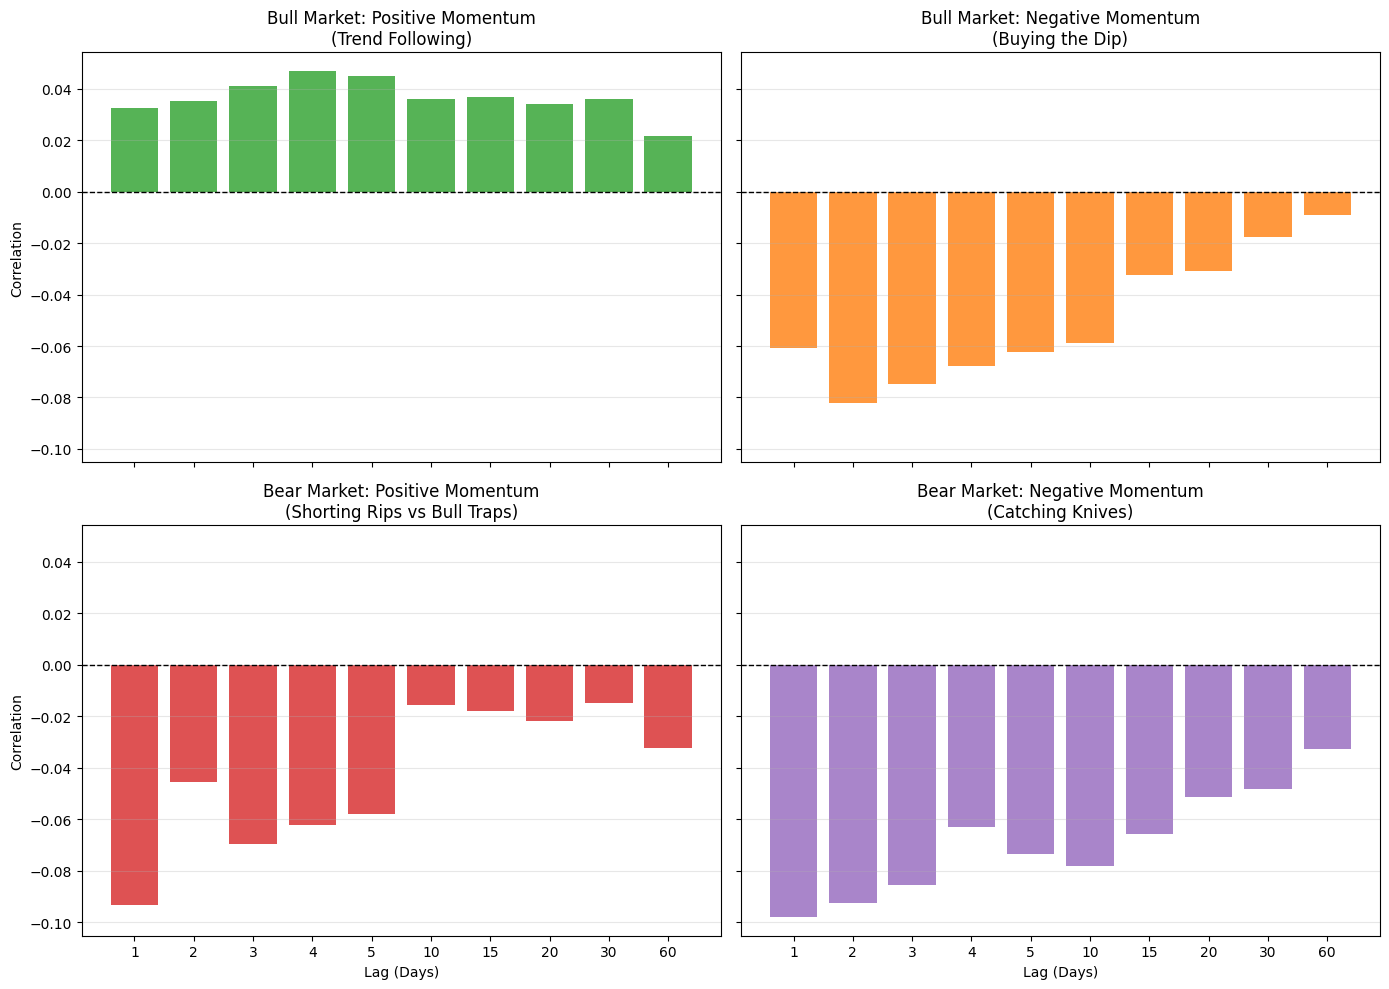

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Compute 4-Way Split in DuckDB
df_4way = con.sql('''
    WITH btc_stats AS (
        SELECT 
            ts,
            close,
            avg(close) OVER (
                ORDER BY ts ROWS BETWEEN 119 PRECEDING AND CURRENT ROW
            ) as sma_120
        FROM coins
        WHERE symbol = 'btc'
    ),
    regime_data AS (
        SELECT 
            ts,
            CASE 
                WHEN close > sma_120 THEN 'Bull' 
                ELSE 'Bear' 
            END as regime
        FROM btc_stats
        WHERE sma_120 IS NOT NULL
    ),
    split_data AS (
        SELECT 
            m.lag,
            r.regime,
            CASE 
                WHEN m.mom >= 0 THEN 'Positive' 
                ELSE 'Negative' 
            END as mom_sign,
            m.mom,
            m.ret
        FROM momentum m
        JOIN regime_data r ON m.ts = r.ts
        WHERE m.lag IN (1, 2, 3, 4, 5, 10, 15, 20, 30, 60)
    )
    SELECT 
        lag,
        regime,
        mom_sign,
        corr(mom, ret) as correlation
    FROM split_data
    GROUP BY 1, 2, 3
    ORDER BY lag, regime, mom_sign
''').df()

# 2. Visualization (2x2 Grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Helper function to keep code clean
def plot_quadrant(ax, regime, sign, color, title):
    subset = df_4way[(df_4way['regime'] == regime) & (df_4way['mom_sign'] == sign)]
    if not subset.empty:
        ax.bar(subset['lag'].astype(str), subset['correlation'], color=color, alpha=0.8)
    ax.set_title(title)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='y', alpha=0.3)

# Top Left: Bull Market + Positive Mom (The "Easy" Money)
plot_quadrant(axes[0, 0], 'Bull', 'Positive', '#2ca02c', 'Bull Market: Positive Momentum\n(Trend Following)')
axes[0, 0].set_ylabel('Correlation')

# Top Right: Bull Market + Negative Mom (The "Dip Buy")
plot_quadrant(axes[0, 1], 'Bull', 'Negative', '#ff7f0e', 'Bull Market: Negative Momentum\n(Buying the Dip)')

# Bottom Left: Bear Market + Positive Mom (The "Short Squeeze" / Trap)
plot_quadrant(axes[1, 0], 'Bear', 'Positive', '#d62728', 'Bear Market: Positive Momentum\n(Shorting Rips vs Bull Traps)')
axes[1, 0].set_ylabel('Correlation')
axes[1, 0].set_xlabel('Lag (Days)')

# Bottom Right: Bear Market + Negative Mom (The "Knife Catch")
plot_quadrant(axes[1, 1], 'Bear', 'Negative', '#9467bd', 'Bear Market: Negative Momentum\n(Catching Knives)')
axes[1, 1].set_xlabel('Lag (Days)')

plt.tight_layout()
plt.show()

mean reversion 2d momentum in bull markets, trend following 1d momentum in bear (0.2% fees, vs BTC)

* gets fucked when the market turns: maybe use distane of btc from 120d sma to get out earlier

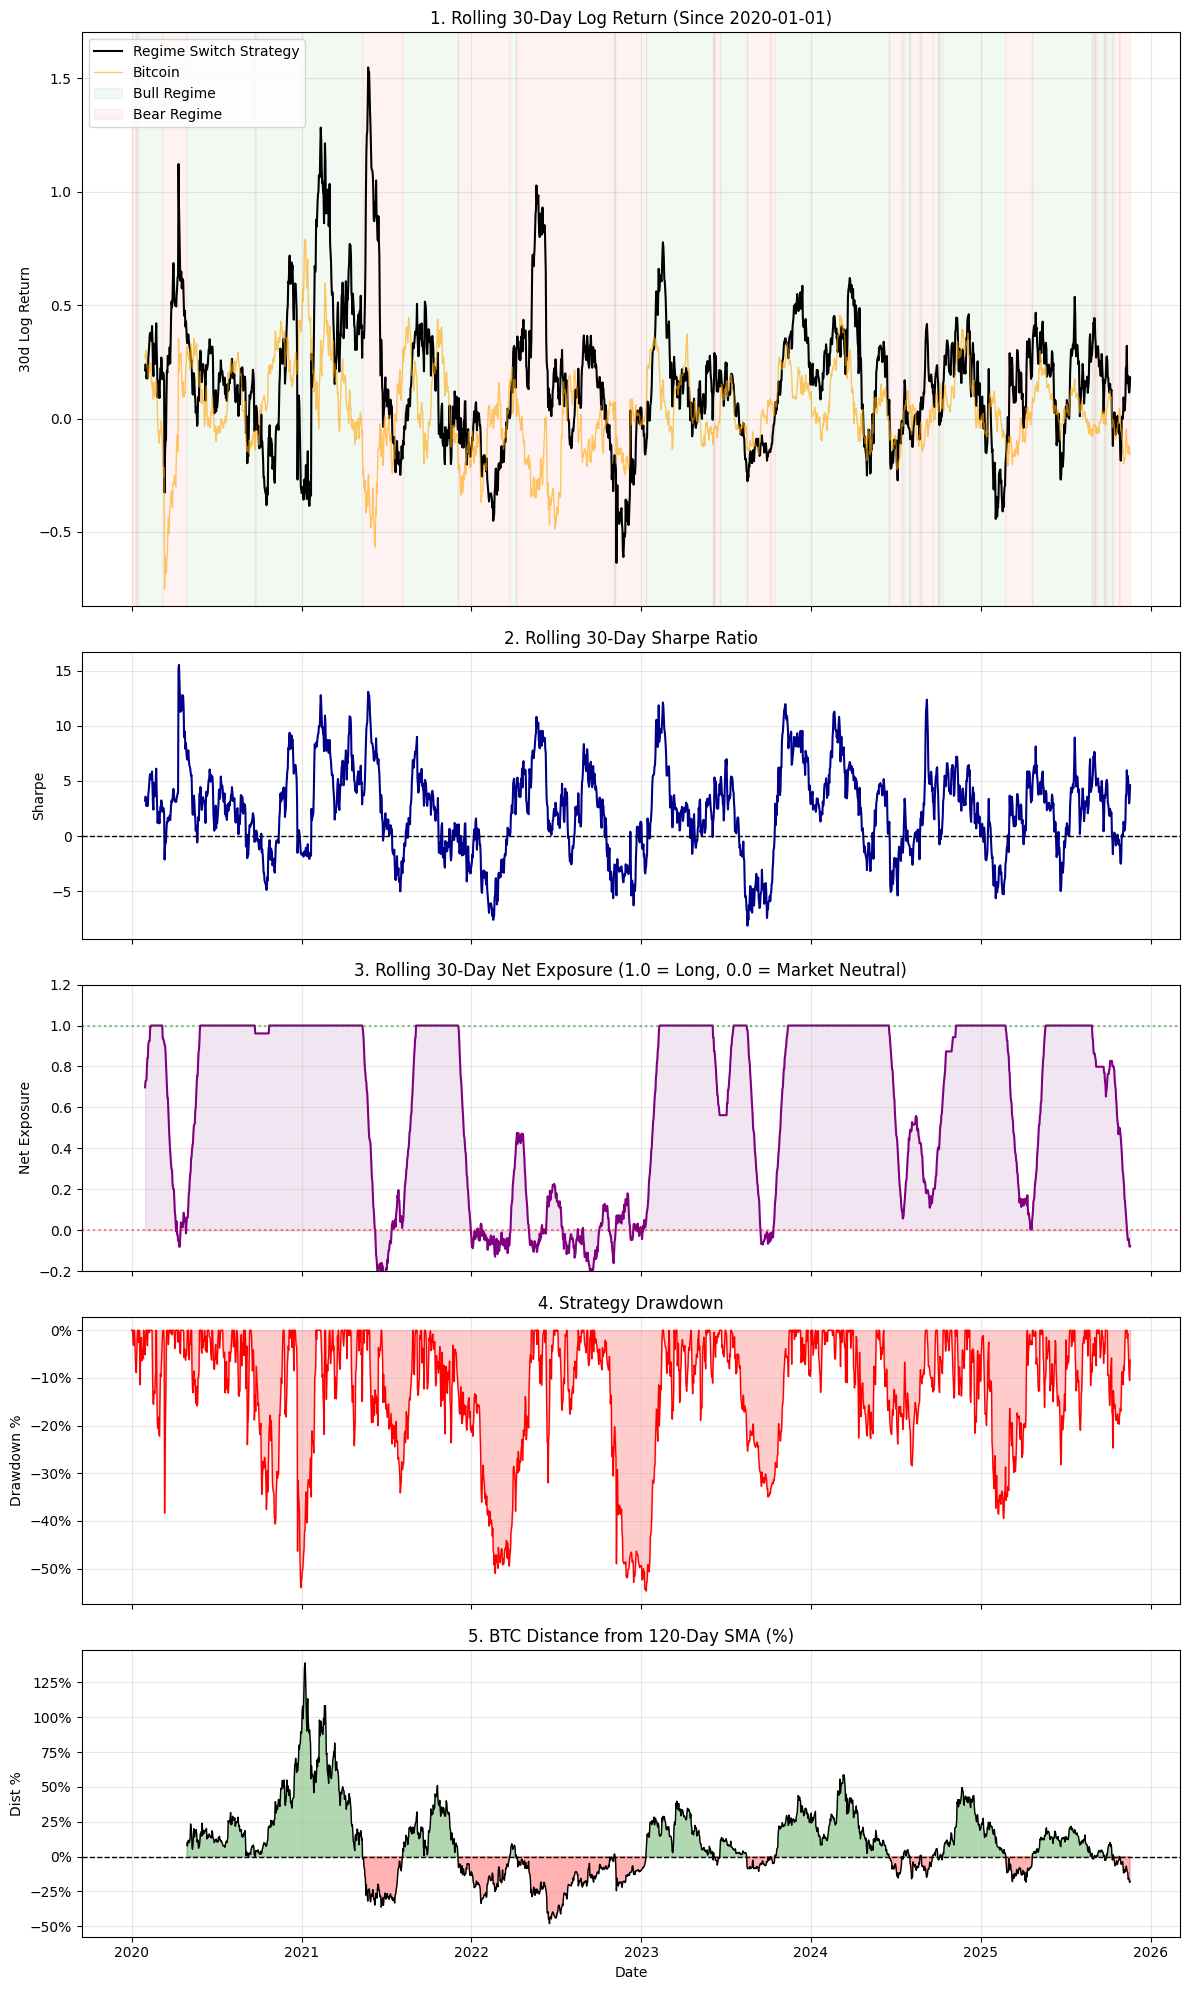

Max Drawdown: -54.72%
Max SMA Extension: 138.89%


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- CONFIGURATION ---
FEE_RATE = 0.002
SMA_WINDOW = 120
ROLLING_WINDOW = 30
START_DATE = '2020-01-01'

# 1. Execute Backtest Logic (Real Data)
df_pnl = con.sql(f'''
    WITH btc_stats AS (
        SELECT 
            ts,
            close,
            -- Calculate 120 SMA
            avg(close) OVER (
                ORDER BY ts ROWS BETWEEN {SMA_WINDOW - 1} PRECEDING AND CURRENT ROW
            ) as btc_sma
        FROM coins
        WHERE symbol = 'btc'
    ),
    regime_signal AS (
        SELECT 
            ts,
            CASE WHEN close > btc_sma THEN 1 ELSE 0 END as is_bull
        FROM btc_stats
        WHERE btc_sma IS NOT NULL
    ),
    base_data AS (
        SELECT 
            m1.ts,
            m1.symbol,
            m1.mom as mom1,
            m2.mom as mom2,
            m1.ret as ret_log, 
            s.vol20 as weight_metric,
            r.is_bull
        FROM momentum m1
        JOIN momentum m2 
          ON m1.ts = m2.ts AND m1.symbol = m2.symbol
        JOIN sma s 
          ON m1.ts = s.ts AND m1.symbol = s.symbol
        JOIN regime_signal r
          ON m1.ts = r.ts
        WHERE m1.lag = 1 
          AND m2.lag = 2
          AND s.vol20 > 0
          AND m1.ts >= '{START_DATE}'
    ),
    daily_ranks AS (
        SELECT 
            *,
            ntile(10) OVER (PARTITION BY ts ORDER BY mom1 ASC) as rank_mom1,
            ntile(10) OVER (PARTITION BY ts ORDER BY mom2 ASC) as rank_mom2
        FROM base_data
    ),
    daily_vol_aggs AS (
        SELECT 
            ts,
            sum(CASE WHEN is_bull = 1 AND rank_mom2 = 1 THEN weight_metric ELSE 0 END) as bull_vol,
            sum(CASE WHEN is_bull = 0 AND rank_mom1 IN (1, 10) THEN weight_metric ELSE 0 END) as bear_vol
        FROM daily_ranks
        GROUP BY ts
    ),
    weights AS (
        SELECT
            d.ts,
            d.symbol,
            d.ret_log,
            d.is_bull,
            CASE 
                -- BULL: Long Bottom Decile Lag 2
                WHEN d.is_bull = 1 AND d.rank_mom2 = 1 
                    THEN (d.weight_metric / NULLIF(v.bull_vol, 0))
                -- BEAR: Mean Reversion Lag 1 (Long/Short)
                WHEN d.is_bull = 0 AND d.rank_mom1 = 1
                    THEN (d.weight_metric / NULLIF(v.bear_vol, 0))
                WHEN d.is_bull = 0 AND d.rank_mom1 = 10
                    THEN -1 * (d.weight_metric / NULLIF(v.bear_vol, 0))
                ELSE 0.0 
            END as target_weight
        FROM daily_ranks d
        JOIN daily_vol_aggs v ON d.ts = v.ts
    ),
    turnover_calc AS (
        SELECT
            ts,
            is_bull,
            ret_log,
            target_weight,
            LAG(target_weight, 1, 0.0) OVER (PARTITION BY symbol ORDER BY ts) as prev_weight
        FROM weights
    )
    SELECT 
        ts,
        any_value(is_bull) as is_bull,
        
        -- Returns
        sum(target_weight * ret_log) as gross_ret_log,
        sum(abs(target_weight - prev_weight)) as turnover,
        
        -- Net Exposure (Sum of Weights)
        -- Should range from 0.0 (Bear/Neutral) to 1.0 (Bull/Long)
        sum(target_weight) as net_exposure
        
    FROM turnover_calc
    WHERE abs(target_weight) > 0 OR abs(prev_weight) > 0
    GROUP BY ts
    ORDER BY ts
''').pl().to_pandas()

# 2. Process Returns (Net of Fees)
df_pnl['cost'] = df_pnl['turnover'] * FEE_RATE
df_pnl['gross_ret_simple'] = np.exp(df_pnl['gross_ret_log']) - 1
df_pnl['net_ret_simple'] = df_pnl['gross_ret_simple'] - df_pnl['cost']
df_pnl['net_ret_log'] = np.log1p(df_pnl['net_ret_simple'])

# 3. Get BTC Data (Price + Log Ret)
# We fetch 'close' here to calculate SMA Distance in Python
df_btc = con.sql(f'''
    SELECT 
        ts, 
        close as btc_close,
        ln(close / lag(close) OVER (ORDER BY ts)) as btc_ret_log
    FROM coins 
    WHERE symbol = 'btc' 
    ORDER BY ts
''').pl().to_pandas()

# Filter BTC data to match strategy start date
df_btc = df_btc[df_btc['ts'] >= pd.to_datetime(START_DATE)]

# Merge
df_viz = pd.merge(df_pnl, df_btc, on='ts', how='inner').set_index('ts')

# 4. Compute Metrics
df_viz['Strategy_30d_Log'] = df_viz['net_ret_log'].rolling(ROLLING_WINDOW).sum()
df_viz['BTC_30d_Log'] = df_viz['btc_ret_log'].rolling(ROLLING_WINDOW).sum()

# Sharpe
rolling_mean = df_viz['net_ret_log'].rolling(ROLLING_WINDOW).mean()
rolling_std = df_viz['net_ret_log'].rolling(ROLLING_WINDOW).std()
df_viz['Rolling_Sharpe'] = (rolling_mean / rolling_std) * np.sqrt(365)

# Rolling Exposure
df_viz['Rolling_Exposure'] = df_viz['net_exposure'].rolling(ROLLING_WINDOW).mean()

# Drawdown
cumulative_equity = np.exp(df_viz['net_ret_log'].cumsum())
running_max = cumulative_equity.cummax()
df_viz['Drawdown'] = (cumulative_equity - running_max) / running_max

# 5. Compute BTC SMA Distance
# We calculate the SMA on the *sliced* data or fetch pre-calc. 
# Calculating here ensures alignment.
df_viz['btc_sma'] = df_viz['btc_close'].rolling(SMA_WINDOW).mean()
df_viz['sma_dist_pct'] = (df_viz['btc_close'] - df_viz['btc_sma']) / df_viz['btc_sma']

# 6. Visualization (5 Panels)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1, 1]})

# --- Panel 1: Returns ---
axes[0].plot(df_viz.index, df_viz['Strategy_30d_Log'], color='black', label='Regime Switch Strategy', linewidth=1.5)
axes[0].plot(df_viz.index, df_viz['BTC_30d_Log'], color='orange', label='Bitcoin', alpha=0.6, linewidth=1)
axes[0].fill_between(df_viz.index, -10, 10, where=(df_viz['is_bull']==1), color='green', alpha=0.05, label='Bull Regime')
axes[0].fill_between(df_viz.index, -10, 10, where=(df_viz['is_bull']==0), color='red', alpha=0.05, label='Bear Regime')
y_min = min(df_viz['Strategy_30d_Log'].min(), df_viz['BTC_30d_Log'].min())
y_max = max(df_viz['Strategy_30d_Log'].max(), df_viz['BTC_30d_Log'].max())
axes[0].set_ylim(y_min * 1.1, y_max * 1.1)
axes[0].set_title(f'1. Rolling 30-Day Log Return (Since {START_DATE})')
axes[0].set_ylabel('30d Log Return')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# --- Panel 2: Sharpe ---
axes[1].plot(df_viz.index, df_viz['Rolling_Sharpe'], color='darkblue')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('2. Rolling 30-Day Sharpe Ratio')
axes[1].set_ylabel('Sharpe')
axes[1].grid(True, alpha=0.3)

# --- Panel 3: Net Exposure ---
axes[2].plot(df_viz.index, df_viz['Rolling_Exposure'], color='purple', linewidth=1.5)
axes[2].fill_between(df_viz.index, df_viz['Rolling_Exposure'], 0, color='purple', alpha=0.1)
axes[2].set_ylim(-0.2, 1.2)
axes[2].set_title('3. Rolling 30-Day Net Exposure (1.0 = Long, 0.0 = Market Neutral)')
axes[2].set_ylabel('Net Exposure')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(1, color='green', linestyle=':', alpha=0.5)
axes[2].axhline(0, color='red', linestyle=':', alpha=0.5)

# --- Panel 4: Drawdown ---
axes[3].plot(df_viz.index, df_viz['Drawdown'], color='red', linewidth=1)
axes[3].fill_between(df_viz.index, df_viz['Drawdown'], 0, color='red', alpha=0.2)
axes[3].set_title('4. Strategy Drawdown')
axes[3].set_ylabel('Drawdown %')
axes[3].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
axes[3].grid(True, alpha=0.3)

# --- Panel 5: BTC Distance from SMA ---
axes[4].plot(df_viz.index, df_viz['sma_dist_pct'], color='black', linewidth=1)
axes[4].fill_between(df_viz.index, df_viz['sma_dist_pct'], 0, where=(df_viz['sma_dist_pct'] >= 0), color='green', alpha=0.3)
axes[4].fill_between(df_viz.index, df_viz['sma_dist_pct'], 0, where=(df_viz['sma_dist_pct'] < 0), color='red', alpha=0.3)
axes[4].axhline(0, color='black', linestyle='--', linewidth=1)
axes[4].set_title(f'5. BTC Distance from {SMA_WINDOW}-Day SMA (%)')
axes[4].set_ylabel('Dist %')
axes[4].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
axes[4].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Print Summary
print(f"Max Drawdown: {df_viz['Drawdown'].min():.2%}")
print(f"Max SMA Extension: {df_viz['sma_dist_pct'].max():.2%}")

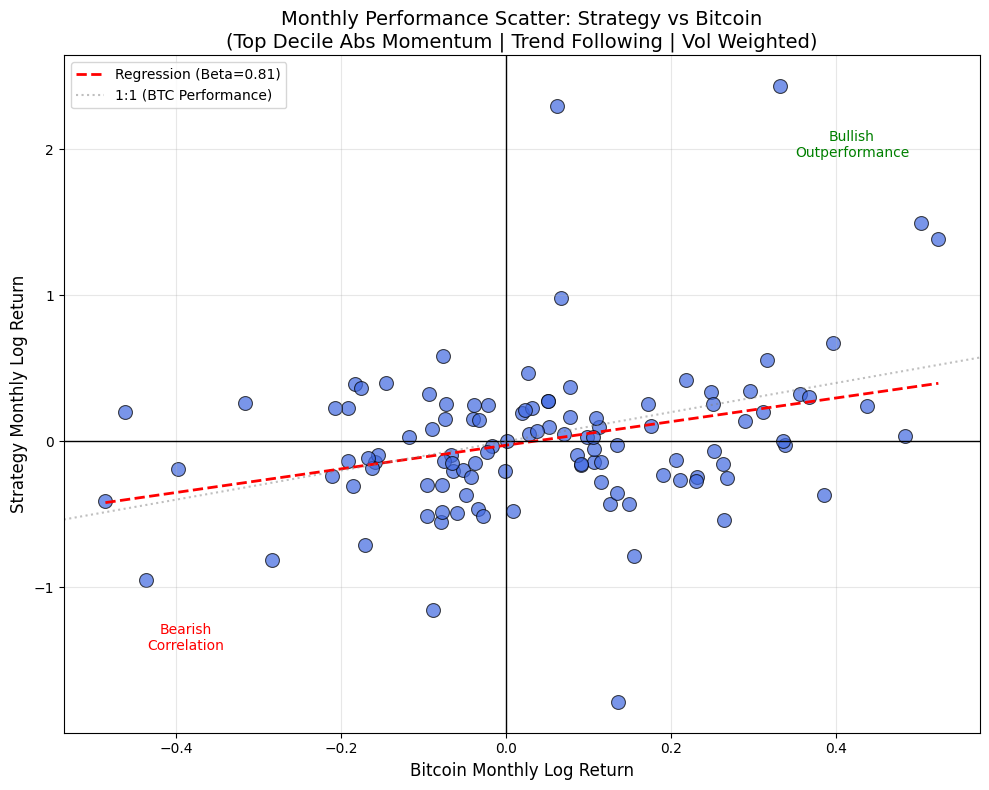

--- Strategy Correlation Analysis ---
Beta to BTC:      0.81
Correlation (R):  0.31
R-Squared:        0.09
Monthly Alpha:    -2.70%


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. DuckDB Query: Logic Calculation & Aggregation
# We perform the heavy lifting (Ranking, Weighting, Aggregating) inside the SQL engine
df_monthly = con.sql('''
    WITH base_data AS (
        SELECT 
            m.ts,
            m.symbol,
            m.mom,
            m.ret,
            s.vol20
        FROM momentum m
        JOIN sma s ON m.ts = s.ts AND m.symbol = s.symbol
        WHERE m.lag = 1 
          AND s.vol20 > 0
    ),
    -- Step 1: Rank by ABSOLUTE Momentum
    ranked AS (
        SELECT 
            *,
            ntile(10) OVER (PARTITION BY ts ORDER BY abs(mom) ASC) as abs_mom_decile
        FROM base_data
    ),
    -- Step 2: Select Top Decile & Determine Direction
    selected AS (
        SELECT 
            ts,
            symbol,
            vol20,
            ret,
            -- Trend Following: 
            -- If Mom was +5%, we go Long (+1). 
            -- If Mom was -5%, we go Short (-1).
            sign(mom) as direction
        FROM ranked
        WHERE abs_mom_decile = 10
    ),
    -- Step 3: Apply Volume Weighting
    weighted AS (
        SELECT
            ts,
            symbol,
            -- Strategy Return = Direction * Future Return
            (direction * ret) as raw_trade_ret,
            -- Weight = Coin Vol / Total Vol of Selection
            vol20 / sum(vol20) OVER (PARTITION BY ts) as weight
        FROM selected
    ),
    -- Step 4: Aggregate Strategy to Daily Level
    daily_strat AS (
        SELECT 
            ts,
            sum(weight * raw_trade_ret) as strat_ret_log
        FROM weighted
        GROUP BY ts
    ),
    -- Step 5: Get BTC Daily Returns
    daily_btc AS (
        SELECT 
            ts, 
            ln(close / lag(close) OVER (ORDER BY ts)) as btc_ret_log
        FROM coins 
        WHERE symbol = 'btc'
    )
    -- Step 6: Aggregate to Monthly Level
    SELECT 
        strftime(s.ts, '%Y-%m') as month,
        sum(s.strat_ret_log) as strat_ret,
        sum(b.btc_ret_log) as btc_ret
    FROM daily_strat s
    JOIN daily_btc b ON s.ts = b.ts
    GROUP BY 1
    ORDER BY 1
''').df()

# 2. Calculate Regression Stats (Beta/Alpha)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_monthly['btc_ret'], df_monthly['strat_ret'])

# 3. Visualization
plt.figure(figsize=(10, 8))

# Scatter Points
sns.scatterplot(
    data=df_monthly, 
    x='btc_ret', 
    y='strat_ret', 
    color='royalblue', 
    s=100, 
    alpha=0.7,
    edgecolor='black'
)

# Regression Line (The Strategy's "Beta")
x_vals = np.array([df_monthly['btc_ret'].min(), df_monthly['btc_ret'].max()])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2, label=f'Regression (Beta={slope:.2f})')

# Reference Lines
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.axline((0, 0), slope=1, color='grey', linestyle=':', alpha=0.5, label='1:1 (BTC Performance)')

# Labels and Titles
plt.title(f'Monthly Performance Scatter: Strategy vs Bitcoin\n(Top Decile Abs Momentum | Trend Following | Vol Weighted)', fontsize=14)
plt.xlabel('Bitcoin Monthly Log Return', fontsize=12)
plt.ylabel('Strategy Monthly Log Return', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Add Quadrant Annotations
plt.text(df_monthly['btc_ret'].max()*0.8, df_monthly['strat_ret'].max()*0.8, "Bullish\nOutperformance", fontsize=10, color='green', ha='center')
plt.text(df_monthly['btc_ret'].min()*0.8, df_monthly['strat_ret'].min()*0.8, "Bearish\nCorrelation", fontsize=10, color='red', ha='center')

plt.tight_layout()
plt.show()

# 4. Print Statistics
print("--- Strategy Correlation Analysis ---")
print(f"Beta to BTC:      {slope:.2f}")
print(f"Correlation (R):  {r_value:.2f}")
print(f"R-Squared:        {r_value**2:.2f}")
print(f"Monthly Alpha:    {intercept:.2%}")

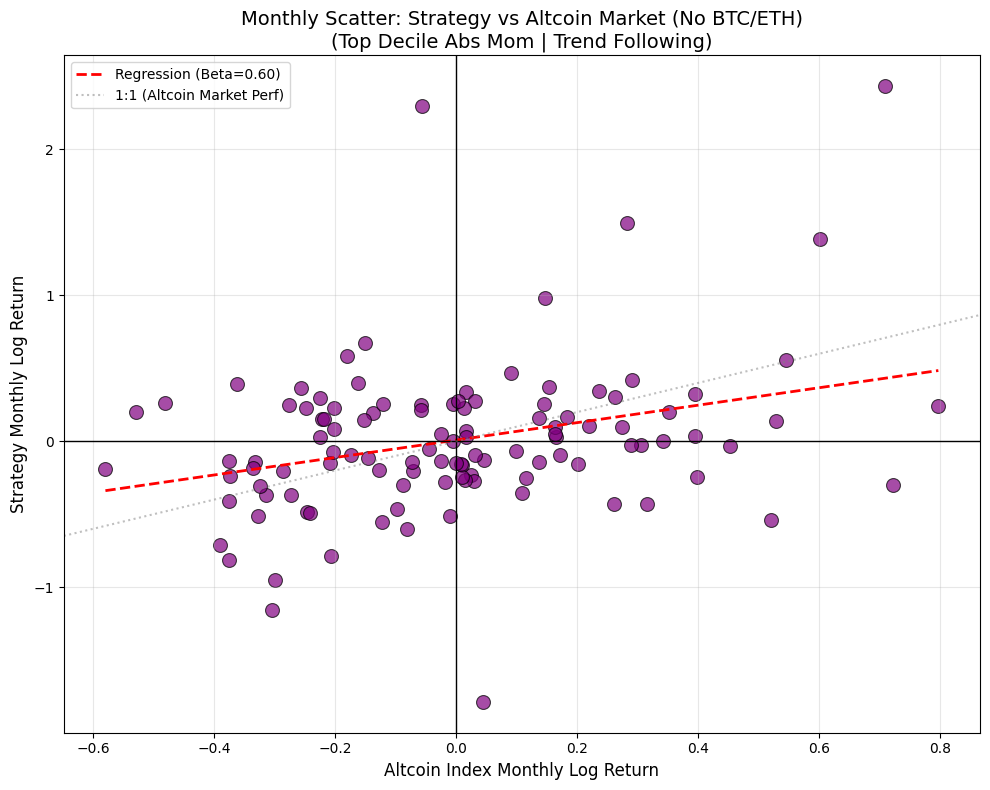

--- Strategy vs Altcoin Market ---
Beta to Altcoins: 0.60
Correlation (R):  0.31
Monthly Alpha:    0.82%


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. DuckDB Query: Strategy vs Altcoin Benchmark
df_monthly = con.sql('''
    WITH base_data AS (
        SELECT 
            m.ts,
            m.symbol,
            m.mom,
            m.ret,
            s.vol20
        FROM momentum m
        JOIN sma s ON m.ts = s.ts AND m.symbol = s.symbol
        WHERE m.lag = 1 
          AND s.vol20 > 0
    ),
    
    -- =============================================
    -- PART A: STRATEGY CALCULATION
    -- =============================================
    ranked AS (
        SELECT 
            *,
            -- Rank by ABSOLUTE Momentum
            ntile(10) OVER (PARTITION BY ts ORDER BY abs(mom) ASC) as abs_mom_decile
        FROM base_data
    ),
    strat_weights AS (
        SELECT
            ts,
            -- Strategy Logic: Direction * Return
            (sign(mom) * ret) as raw_trade_ret,
            -- Weight: Relative Volume of Top Decile
            vol20 / sum(vol20) OVER (PARTITION BY ts) as weight
        FROM ranked
        WHERE abs_mom_decile = 10
    ),
    daily_strat AS (
        SELECT 
            ts,
            sum(weight * raw_trade_ret) as strat_ret_log
        FROM strat_weights
        GROUP BY ts
    ),

    -- =============================================
    -- PART B: ALTCOIN BENCHMARK CALCULATION
    -- =============================================
    bench_data AS (
        SELECT 
            ts,
            ret,
            vol20
        FROM base_data
        -- Exclude the Giants
        WHERE symbol NOT IN ('btc', 'eth')
    ),
    daily_bench AS (
        SELECT
            ts,
            -- Volume Weighted Return of the remaining Universe
            -- Equivalent to: Sum(Coin_Vol * Coin_Ret) / Total_Vol
            sum(vol20 * ret) / sum(vol20) as bench_ret_log
        FROM bench_data
        GROUP BY ts
    )

    -- =============================================
    -- PART C: AGGREGATE TO MONTHLY
    -- =============================================
    SELECT 
        strftime(s.ts, '%Y-%m') as month,
        sum(s.strat_ret_log) as strat_ret,
        sum(b.bench_ret_log) as bench_ret
    FROM daily_strat s
    JOIN daily_bench b ON s.ts = b.ts
    GROUP BY 1
    ORDER BY 1
''').df()

# 2. Calculate Regression Stats (Beta to Alts)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_monthly['bench_ret'], df_monthly['strat_ret'])

# 3. Visualization
plt.figure(figsize=(10, 8))

# Scatter Points
sns.scatterplot(
    data=df_monthly, 
    x='bench_ret', 
    y='strat_ret', 
    color='purple', # Purple to distinguish Altcoin focus
    s=100, 
    alpha=0.7,
    edgecolor='black'
)

# Regression Line
x_vals = np.array([df_monthly['bench_ret'].min(), df_monthly['bench_ret'].max()])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2, label=f'Regression (Beta={slope:.2f})')

# Reference Lines
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.axline((0, 0), slope=1, color='grey', linestyle=':', alpha=0.5, label='1:1 (Altcoin Market Perf)')

# Labels
plt.title(f'Monthly Scatter: Strategy vs Altcoin Market (No BTC/ETH)\n(Top Decile Abs Mom | Trend Following)', fontsize=14)
plt.xlabel('Altcoin Index Monthly Log Return', fontsize=12)
plt.ylabel('Strategy Monthly Log Return', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Annotations
plt.tight_layout()
plt.show()

# 4. Print Statistics
print("--- Strategy vs Altcoin Market ---")
print(f"Beta to Altcoins: {slope:.2f}")
print(f"Correlation (R):  {r_value:.2f}")
print(f"Monthly Alpha:    {intercept:.2%}")

/Users/kai/studies/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/1658818117.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['rolling_corr'] = df.groupby('symbol').apply(


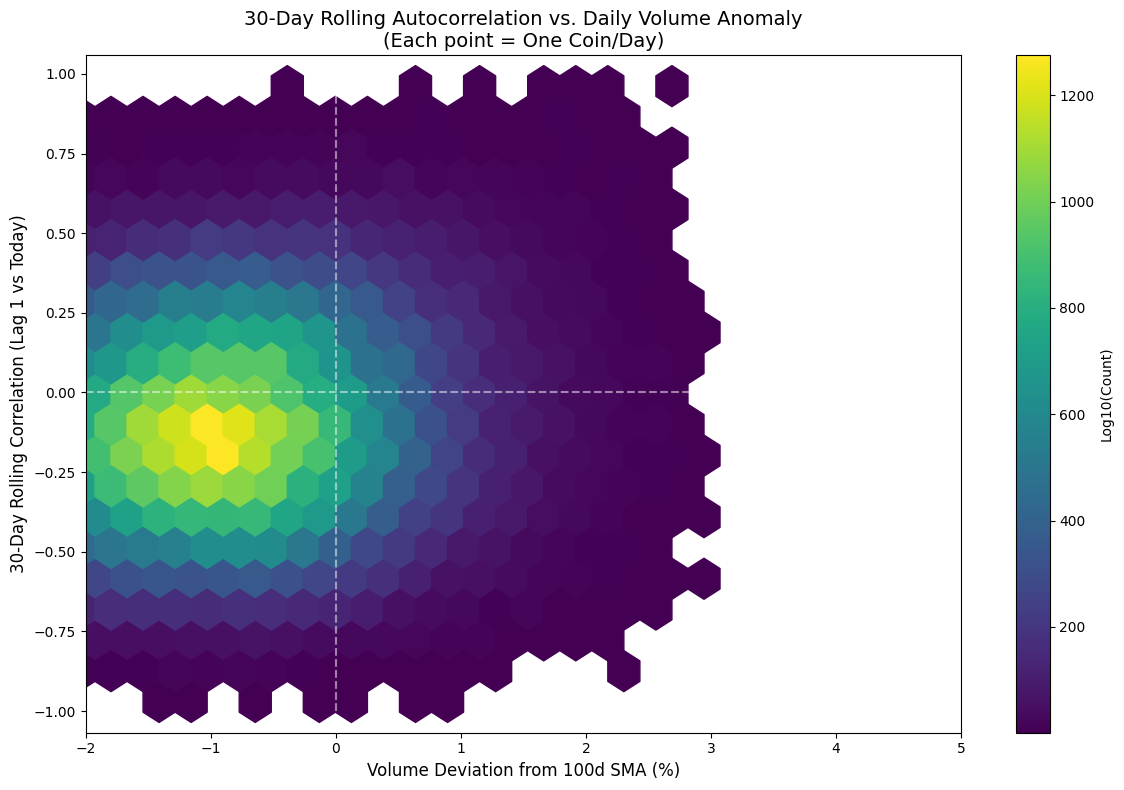

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fetch Data
df = con.sql('''
    WITH base AS (
        SELECT 
            ts, 
            symbol, 
            volume,
            -- Calculate Daily Return
            (close / lag(close) OVER (PARTITION BY symbol ORDER BY ts) - 1) as ret
        FROM coins
    ),
    with_sma AS (
        SELECT 
            *,
            -- 100-day Volume SMA
            avg(volume) OVER (
                PARTITION BY symbol 
                ORDER BY ts 
                ROWS BETWEEN 19 PRECEDING AND CURRENT ROW
            ) as vol_sma100,
            -- Lagged Return
            lag(ret) OVER (PARTITION BY symbol ORDER BY ts) as prev_ret
        FROM base
    )
    SELECT * FROM with_sma
    WHERE vol_sma100 IS NOT NULL AND prev_ret IS NOT NULL
''').df()

# 2. Calculate Metrics in Pandas (Rolling Corr is hard in SQL)
# A. Volume Distance %
df['vol_dist_pct'] = np.log((df['volume'] - df['vol_sma100']) / df['vol_sma100'])

# B. Rolling Correlation (30-day window of Ret vs Prev_Ret)
# This measures "Is this coin trending or mean-reverting lately?"
df['rolling_corr'] = df.groupby('symbol').apply(
    lambda x: x['ret'].rolling(10).corr(x['prev_ret'])
).reset_index(0, drop=True)

# Drop NaNs created by rolling window
df_clean = df.dropna(subset=['rolling_corr', 'vol_dist_pct'])

# 3. Visualization
plt.figure(figsize=(12, 8))

# Use Hexbin for density because scatter with millions of points is unreadable
hb = plt.hexbin(
    x=df_clean['vol_dist_pct'], 
    y=df_clean['rolling_corr'], 
    gridsize=(150,10),
    cmap='viridis', 
    mincnt=1,
    #bins='log' # Log scale for color to see outliers
)
cb = plt.colorbar(hb, label='Log10(Count)')

plt.title('30-Day Rolling Autocorrelation vs. Daily Volume Anomaly\n(Each point = One Coin/Day)', fontsize=14)
plt.xlabel('Volume Deviation from 100d SMA (%)', fontsize=12)
plt.ylabel('30-Day Rolling Correlation (Lag 1 vs Today)', fontsize=12)
plt.axhline(0, color='white', linestyle='--', alpha=0.5)
plt.axvline(0, color='white', linestyle='--', alpha=0.5)

# Limit X-axis to remove extreme outliers for readability
plt.xlim(-2, 5) 

plt.tight_layout()
plt.show()

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Fetch Data
# We need: TS, Symbol, Close (for returns), Volume
df = con.sql('''
    SELECT 
        ts, 
        symbol, 
        close, 
        volume
    FROM coins
    ORDER BY symbol, ts
''').df()

# 2. Calculate Metrics in Pandas
# Group by symbol to respect boundaries
grouped = df.groupby('symbol')

# A. Returns
df['ret'] = np.log(grouped['close'] / grouped['close'].shift(1)).dropna()
df['prev_ret'] = grouped['ret'].shift(1)

# B. Momentum Following Return
# Did the trend continue? (Yesterday UP & Today UP) or (Yesterday DOWN & Today DOWN)
df['mom_return'] = np.sign(df['prev_ret']) * df['ret']

# C. 5-Day EMA of Volume
df['vol_ema5'] = grouped['volume'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

# D. Slope of the EMA (Percentage Change)
# (Current EMA - Prev EMA) / Prev EMA
df['vol_ema_slope'] = grouped['vol_ema5'].pct_change()

# 3. Filter Clean Data
# Remove NaNs and extreme outliers for better visualization
df_clean = df.dropna(subset=['vol_ema_slope', 'mom_return'])

# Filter extreme slope outliers (e.g., usually within -0.5 to +0.5) for chart readability
# 1st and 99th percentiles
lower = df_clean['vol_ema_slope'].quantile(0.01)
upper = df_clean['vol_ema_slope'].quantile(0.99)
df_plot = df_clean[(df_clean['vol_ema_slope'] > lower) & (df_clean['vol_ema_slope'] < upper)]

# 4. Visualization
plt.figure(figsize=(12, 8))

# Hexbin Plot
hb = plt.hexbin(
    x=df_plot['vol_ema_slope'], 
    y=df_plot['mom_return'], 
    gridsize=50, 
    cmap='inferno', 
    mincnt=1,
    extent=[lower, upper, -0.02, 0.02] # Limit Y-axis visual range to focus on mass
)
cb = plt.colorbar(hb, label='Count of Coin-Days')

# Add Regression Trend Line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['vol_ema_slope'], df_plot['mom_return'])
x_vals = np.array([lower, upper])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, 'w--', linewidth=2, label=f'Trend (Slope={slope:.4f})')

plt.axhline(0, color='white', linestyle='--', alpha=0.5)
plt.axvline(0, color='white', linestyle='--', alpha=0.5)

plt.title('Momentum Profitability vs. Volume Trend (5-Day EMA Slope)\n(X: Vol Expansion/Contraction | Y: Trend Follow Return)', fontsize=14)
plt.xlabel('5-Day Volume EMA Slope (% Change)', fontsize=12)
plt.ylabel('Momentum Strategy Return (Daily)', fontsize=12)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"Correlation (Vol Slope vs Mom Return): {r_value:.4f}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (227, 2) + inhomogeneous part.

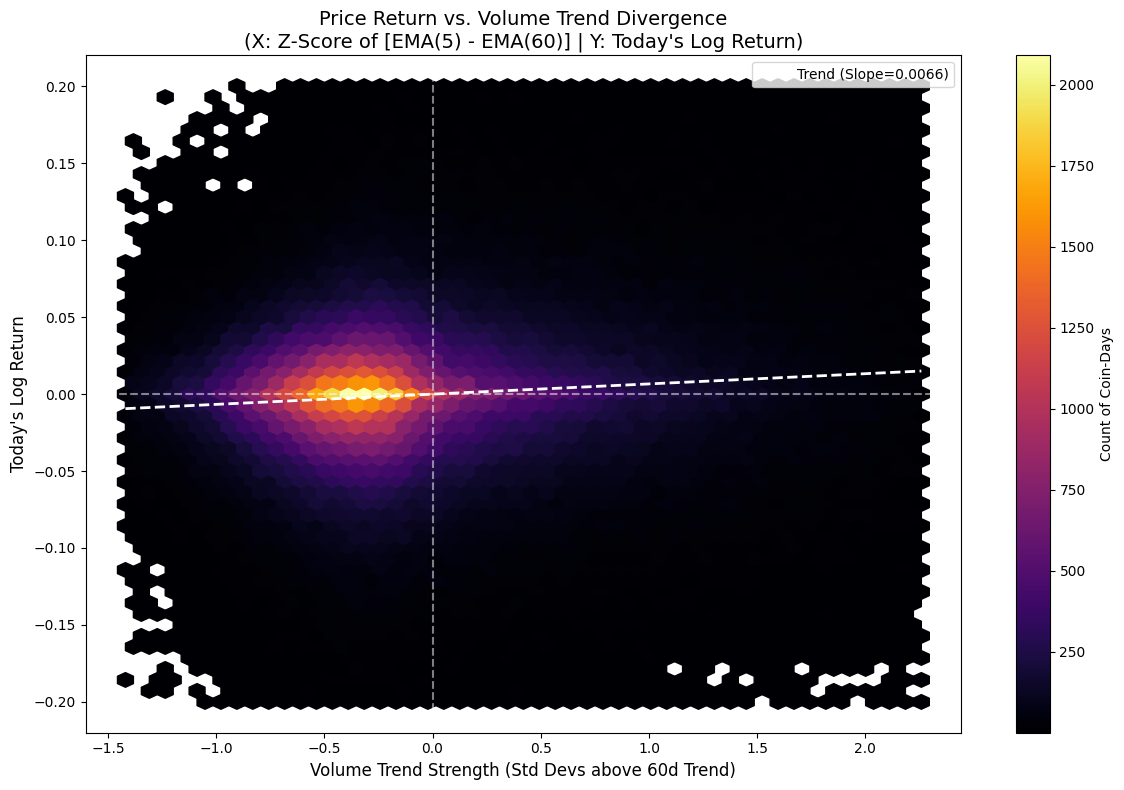

Correlation (Vol Spread Z vs Price Return): 0.0762


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Fetch Data
df = con.sql('''
    SELECT 
        ts, 
        symbol, 
        close, 
        volume
    FROM coins
    ORDER BY symbol, ts
''').df()

# 2. Calculate Metrics
grouped = df.groupby('symbol')

# A. Log Returns (Today)
df['log_ret'] = np.log(df['close'] / grouped['close'].shift(1))

# B. Volume EMAs
df['vol_ema5'] = grouped['volume'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
df['vol_ema60'] = grouped['volume'].transform(lambda x: x.ewm(span=60, adjust=False).mean())

# C. 60-Day Volume StdDev
df['vol_std60'] = grouped['volume'].transform(lambda x: x.rolling(window=60).std())

# D. Metric: Z-Score of the Spread
# (EMA5 - EMA60) / StdDev(Volume)
df['vol_spread_z'] = (df['vol_ema5'] - df['vol_ema60']) / df['vol_std60']

# 3. Filter Clean Data
df_clean = df.dropna(subset=['vol_spread_z', 'log_ret'])

# Filter extreme outliers for visualization clarity
lower_z = df_clean['vol_spread_z'].quantile(0.01)
upper_z = df_clean['vol_spread_z'].quantile(0.99)
df_plot = df_clean[
    (df_clean['vol_spread_z'] > lower_z) & 
    (df_clean['vol_spread_z'] < upper_z)
]

# 4. Visualization
plt.figure(figsize=(12, 8))

# Hexbin Plot
hb = plt.hexbin(
    x=df_plot['vol_spread_z'], 
    y=df_plot['log_ret'], 
    gridsize=50, 
    cmap='inferno', 
    mincnt=1,
    extent=[lower_z, upper_z, -0.2, 0.2] # Limit Y-axis to +/- 20% moves
)
cb = plt.colorbar(hb, label='Count of Coin-Days')

# Add Regression Trend Line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['vol_spread_z'], df_plot['log_ret'])
x_vals = np.array([lower_z, upper_z])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, 'w--', linewidth=2, label=f'Trend (Slope={slope:.4f})')

# Reference Lines
plt.axhline(0, color='white', linestyle='--', alpha=0.5)
plt.axvline(0, color='white', linestyle='--', alpha=0.5)

plt.title("Price Return vs. Volume Trend Divergence\n(X: Z-Score of [EMA(5) - EMA(60)] | Y: Today's Log Return)", fontsize=14)
plt.xlabel("Volume Trend Strength (Std Devs above 60d Trend)", fontsize=12)
plt.ylabel("Today's Log Return", fontsize=12)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"Correlation (Vol Spread Z vs Price Return): {r_value:.4f}")

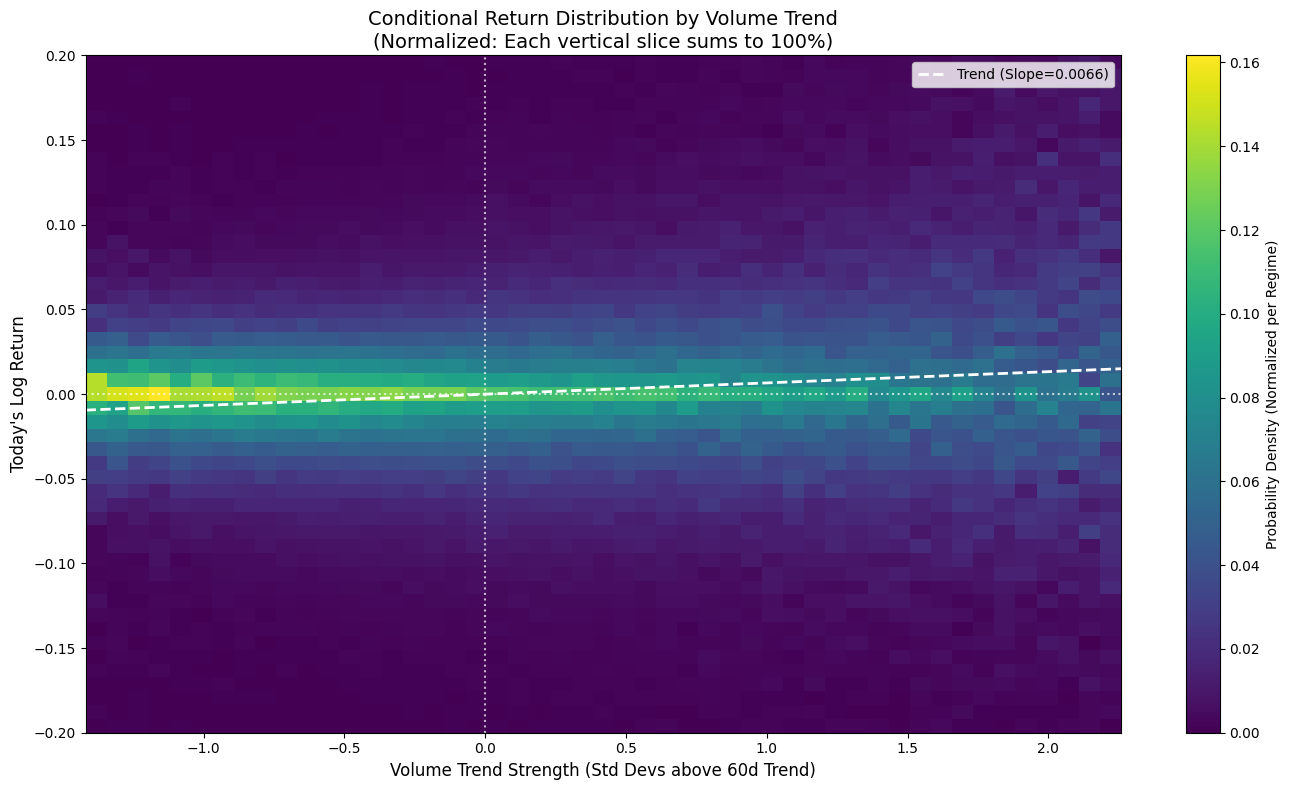

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Fetch Data
df = con.sql('''
    SELECT 
        ts, 
        symbol, 
        close, 
        volume
    FROM coins
    ORDER BY symbol, ts
''').df()

# 2. Calculate Metrics
grouped = df.groupby('symbol')

# A. Log Returns (Today)
df['log_ret'] = np.log(df['close'] / grouped['close'].shift(1))

# B. Volume EMAs
df['vol_ema5'] = grouped['volume'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
df['vol_ema60'] = grouped['volume'].transform(lambda x: x.ewm(span=60, adjust=False).mean())

# C. 60-Day Volume StdDev
df['vol_std60'] = grouped['volume'].transform(lambda x: x.rolling(window=60).std())

# D. Metric: Z-Score of the Spread
# (EMA5 - EMA60) / StdDev(Volume)
df['vol_spread_z'] = (df['vol_ema5'] - df['vol_ema60']) / df['vol_std60']

# 3. Filter Clean Data
df_clean = df.dropna(subset=['vol_spread_z', 'log_ret'])

# Filter extreme outliers
lower_z = df_clean['vol_spread_z'].quantile(0.01)
upper_z = df_clean['vol_spread_z'].quantile(0.99)
df_plot = df_clean[
    (df_clean['vol_spread_z'] > lower_z) & 
    (df_clean['vol_spread_z'] < upper_z)
].copy()

# 4. Compute 2D Histogram (Column Normalized)
# Define Bins
x_bins = np.linspace(lower_z, upper_z, 50)
y_bins = np.linspace(-0.2, 0.2, 50) # Range of returns +/- 20%

# H is the count matrix (nx, ny) -> (x_bin, y_bin)
H, x_edges, y_edges = np.histogram2d(
    df_plot['vol_spread_z'], 
    df_plot['log_ret'], 
    bins=[x_bins, y_bins]
)

# Normalize along the Y-axis (for each X bin, sum of probs = 1)
# H.sum(axis=1) gives total counts per X-bin
H_norm = H / H.sum(axis=1, keepdims=True)
H_norm = np.nan_to_num(H_norm) # Handle 0/0 division

# 5. Plotting
plt.figure(figsize=(14, 8))

# pcolormesh expects (X, Y, C). Note we pass H_norm.T (transpose) to match axes.
plt.pcolormesh(x_edges, y_edges, H_norm.T, cmap='viridis', shading='auto')
cb = plt.colorbar(label='Probability Density (Normalized per Regime)')

# Add Regression Trend Line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['vol_spread_z'], df_plot['log_ret'])
x_vals = np.array([lower_z, upper_z])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, 'w--', linewidth=2, label=f'Trend (Slope={slope:.4f})')

plt.title("Conditional Return Distribution by Volume Trend\n(Normalized: Each vertical slice sums to 100%)", fontsize=14)
plt.xlabel("Volume Trend Strength (Std Devs above 60d Trend)", fontsize=12)
plt.ylabel("Today's Log Return", fontsize=12)
plt.axhline(0, color='white', linestyle=':', alpha=0.7)
plt.axvline(0, color='white', linestyle=':', alpha=0.7)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

/Users/kai/studies/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kai/studies/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/2050828084.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_df = df.groupby(['symbol', 'month']).apply(calc_metrics).reset_index()


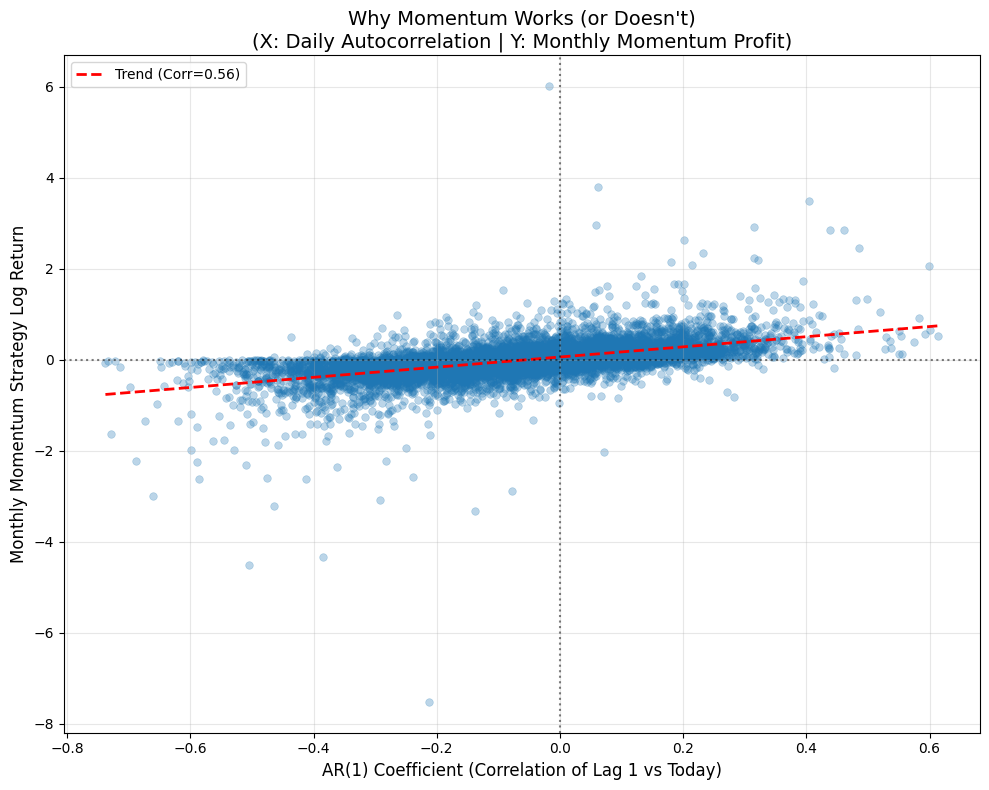

Correlation between AR(1) and Strategy Return: 0.5552


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Fetch Data
# We need TS, Symbol, Close
df = con.sql('''
    SELECT ts, symbol, close 
    FROM coins 
    ORDER BY symbol, ts
''').df()

# 2. Process Data in Pandas
# Calculate Daily Log Returns
grouped = df.groupby('symbol')
df['ret'] = np.log(df['close'] / grouped['close'].shift(1))
df['prev_ret'] = grouped['ret'].shift(1)
df.dropna(inplace=True)

# Group by Month
df['month'] = df['ts'].dt.to_period('M')

# 3. Calculate Monthly Metrics per Coin
def calc_metrics(x):
    # Need reasonable sample size (e.g., > 15 days)
    if len(x) < 15:
        return pd.Series([np.nan, np.nan], index=['ar1', 'mom_ret'])
    
    # Metric 1: AR(1) = Correlation(Ret, Prev_Ret)
    ar1 = x['ret'].corr(x['prev_ret'])
    
    # Metric 2: Momentum Strategy Return
    # If Prev_Ret > 0 -> Long (1 * Ret)
    # If Prev_Ret < 0 -> Short (-1 * Ret)
    mom_ret = np.sum(np.sign(x['prev_ret']) * x['ret'])
    
    return pd.Series([ar1, mom_ret], index=['ar1', 'mom_ret'])

stats_df = df.groupby(['symbol', 'month']).apply(calc_metrics).reset_index()
stats_df.dropna(inplace=True)

# 4. Visualization
plt.figure(figsize=(10, 8))

# Scatter Plot
sns.scatterplot(
    data=stats_df, 
    x='ar1', 
    y='mom_ret', 
    alpha=0.3,       # Transparency to handle density
    edgecolor=None,  # Remove edges for cleaner cloud
    s=30
)

# Regression Line
slope, intercept, r_value, p_value, std_err = stats.linregress(stats_df['ar1'], stats_df['mom_ret'])
x_vals = np.array([stats_df['ar1'].min(), stats_df['ar1'].max()])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, 'r--', linewidth=2, label=f'Trend (Corr={r_value:.2f})')

# Formatting
plt.title("Why Momentum Works (or Doesn't)\n(X: Daily Autocorrelation | Y: Monthly Momentum Profit)", fontsize=14)
plt.xlabel("AR(1) Coefficient (Correlation of Lag 1 vs Today)", fontsize=12)
plt.ylabel("Monthly Momentum Strategy Log Return", fontsize=12)
plt.axhline(0, color='black', linestyle=':', alpha=0.5)
plt.axvline(0, color='black', linestyle=':', alpha=0.5)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation between AR(1) and Strategy Return: {r_value:.4f}")

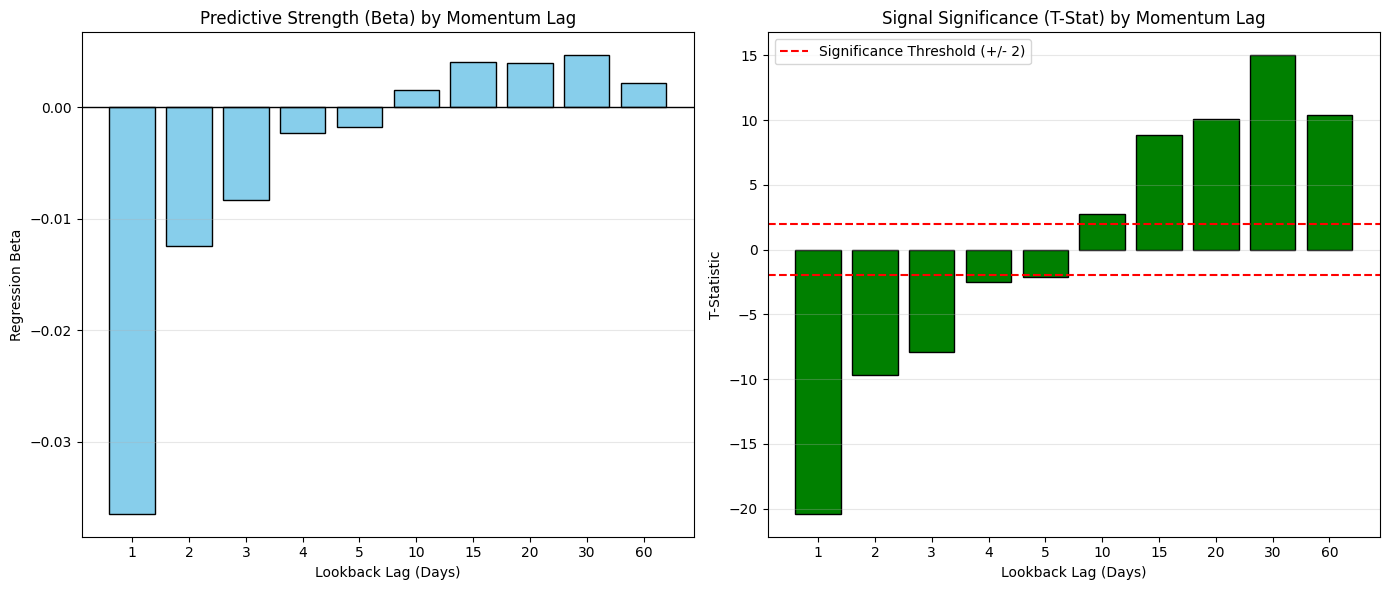

--- Momentum Factor Regressions ---
 Lag    Beta   T-Stat  R-Squared
   1 -0.0365 -20.4013     0.0014
   2 -0.0124  -9.6916     0.0003
   3 -0.0083  -7.9207     0.0002
   4 -0.0023  -2.4911     0.0000
   5 -0.0018  -2.1555     0.0000
  10  0.0016   2.7098     0.0000
  15  0.0041   8.8622     0.0003
  20  0.0040  10.1026     0.0003
  30  0.0047  14.9993     0.0008
  60  0.0022  10.4053     0.0004


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Fetch Data
# We query the momentum table which has pre-calculated (lag, mom, ret)
df = con.sql('SELECT lag, mom, ret FROM momentum').df()

# 2. Run Regressions per Lag
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
results = []

for lag in lags:
    subset = df[df['lag'] == lag]
    
    # Ensure sufficient data
    if len(subset) < 30:
        continue
        
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['mom'], subset['ret'])
    
    t_stat = slope / std_err if std_err != 0 else 0
    
    results.append({
        'Lag': lag,
        'Beta': slope,
        'T-Stat': t_stat,
        'R-Squared': r_value**2,
        'P-Value': p_value
    })

results_df = pd.DataFrame(results)

# 3. Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Betas
axes[0].bar(results_df['Lag'].astype(str), results_df['Beta'], color='skyblue', edgecolor='black')
axes[0].set_title('Predictive Strength (Beta) by Momentum Lag')
axes[0].set_xlabel('Lookback Lag (Days)')
axes[0].set_ylabel('Regression Beta')
axes[0].axhline(0, color='black', linewidth=1)
axes[0].grid(axis='y', alpha=0.3)

# Panel B: Significance (T-Stats)
# Color bars green if significant (|t| > 2), grey otherwise
colors = ['green' if abs(t) >= 2 else 'grey' for t in results_df['T-Stat']]
axes[1].bar(results_df['Lag'].astype(str), results_df['T-Stat'], color=colors, edgecolor='black')
axes[1].set_title('Signal Significance (T-Stat) by Momentum Lag')
axes[1].set_xlabel('Lookback Lag (Days)')
axes[1].set_ylabel('T-Statistic')
axes[1].axhline(2, color='red', linestyle='--', label='Significance Threshold (+/- 2)')
axes[1].axhline(-2, color='red', linestyle='--')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Print Summary Table
print("--- Momentum Factor Regressions ---")
print(results_df[['Lag', 'Beta', 'T-Stat', 'R-Squared']].to_string(index=False, float_format="%.4f"))

/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/3609936582.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['ar1_30d'] = grouped.apply(rolling_ar1).reset_index(0, drop=True)


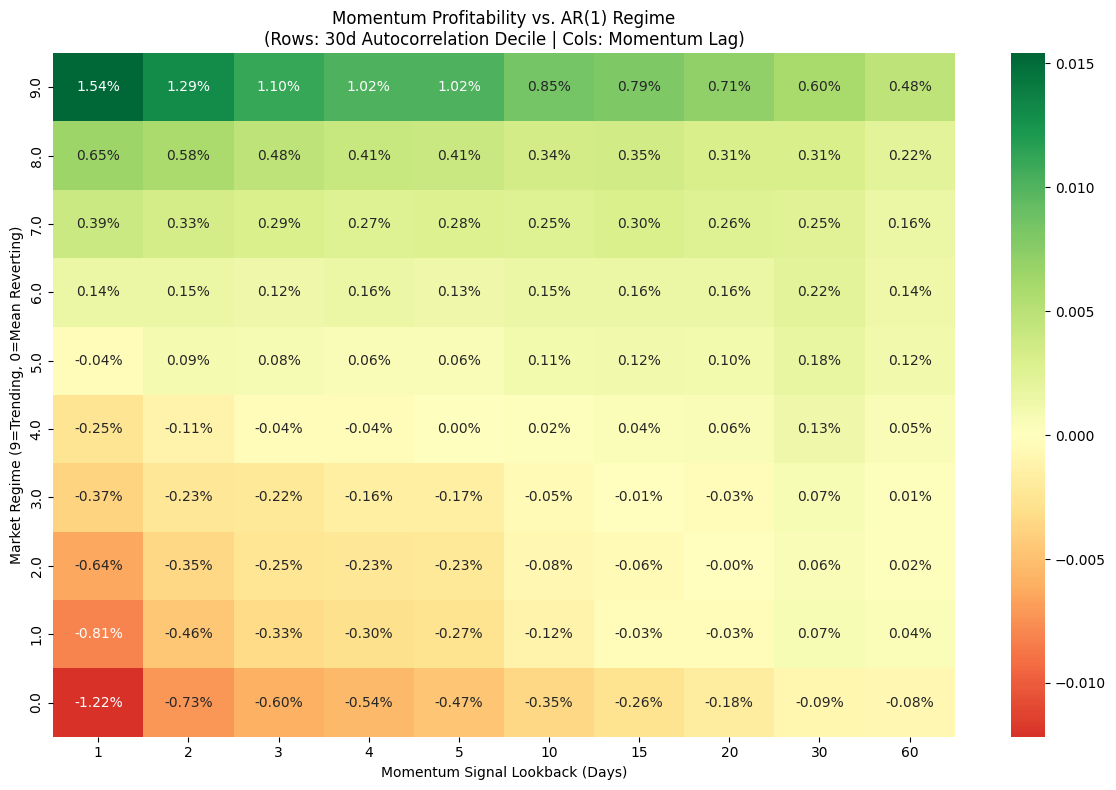

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fetch Data
# We query daily price data
df = con.sql('SELECT ts, symbol, close FROM coins ORDER BY symbol, ts').df()
df['ts'] = pd.to_datetime(df['ts'])

# 2. Calculate Returns
grouped = df.groupby('symbol')
df['ret'] = np.log(df['close'] / grouped['close'].shift(1))
df['prev_ret'] = grouped['ret'].shift(1)

# 3. Calculate 30-Day Rolling Autocorrelation (AR1)
# Correlation between ret and prev_ret over window
def rolling_ar1(x):
    return x['ret'].rolling(30).corr(x['prev_ret'])

df['ar1_30d'] = grouped.apply(rolling_ar1).reset_index(0, drop=True)

# 4. Calculate Momentum Strategy Returns
lags = [1, 2, 3, 4, 5, 10, 15, 20, 30, 60]
strat_cols = []

for lag in lags:
    col_name = f'strat_ret_{lag}'
    strat_cols.append(col_name)
    
    # Calculate Signal: Return over last 'lag' days
    # We define Signal available at T-1 to trade T
    # Signal = (Price_T-1 / Price_T-1-Lag) - 1
    # We shift this forward by 1 so it aligns with 'ret' at T
    signal = grouped['close'].pct_change(lag).shift(1)
    
    # Strategy: Sign(Signal) * Return
    df[col_name] = np.sign(signal) * df['ret']

# 5. Binning and Aggregation
df_clean = df.dropna(subset=['ar1_30d'] + strat_cols).copy()

# Rank AR(1) into Deciles (0-9) per day
df_clean['ar1_decile'] = df_clean.groupby('ts')['ar1_30d'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
)

# Compute Mean Return for each (Decile, Lag)
results = {}
for lag in lags:
    col = f'strat_ret_{lag}'
    results[lag] = df_clean.groupby('ar1_decile')[col].mean()

heatmap_df = pd.DataFrame(results)
heatmap_df.sort_index(ascending=False, inplace=True) # 9 at top

# 6. Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, fmt='.2%', cmap='RdYlGn', center=0)
plt.title('Momentum Profitability vs. AR(1) Regime\n(Rows: 30d Autocorrelation Decile | Cols: Momentum Lag)')
plt.ylabel('Market Regime (9=Trending, 0=Mean Reverting)')
plt.xlabel('Momentum Signal Lookback (Days)')
plt.tight_layout()
plt.show()

/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/4205960973.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_raw['ar1_raw'] = grouped.apply(rolling_ar1).reset_index(0, drop=True)


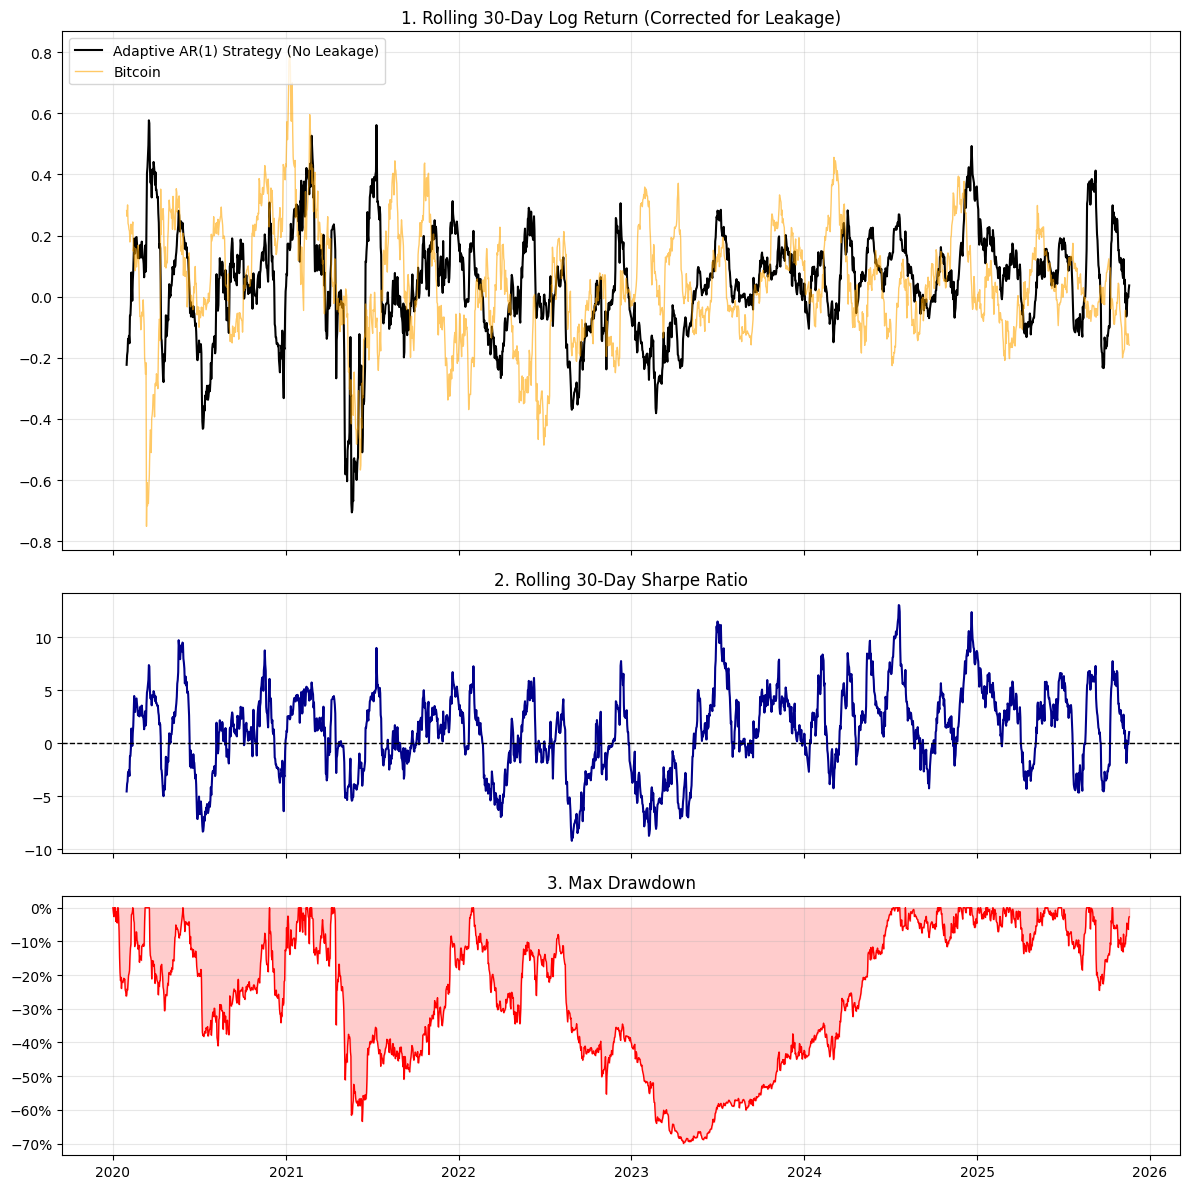

--- Data Leakage Check ---
Signal used for 2020-05-01 should depend on data up to 2020-04-30.
Trade Date: 2020-05-01 00:00:00
Signal Vol (Used for Weight): 1822420893.86
Actual Vol (Realized Today):  1751598144.40
PASS: Weight uses different volume than today.


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- CONFIGURATION ---
START_DATE = '2020-01-01'
WARMUP_DAYS = 60 # Increased buffer for lagging
ROLLING_WINDOW = 30
FEE_RATE = 0.002

# 1. Fetch Data
df_raw = con.sql(f'''
    SELECT ts, symbol, close, volume
    FROM coins
    WHERE ts >= DATE '{START_DATE}' - INTERVAL {WARMUP_DAYS} DAY
    ORDER BY symbol, ts
''').df()
df_raw['ts'] = pd.to_datetime(df_raw['ts'])

# 2. Calculate Indicators (Pre-Shift)
grouped = df_raw.groupby('symbol')

# Returns
df_raw['ret'] = np.log(df_raw['close'] / grouped['close'].shift(1))
df_raw['prev_ret'] = grouped['ret'].shift(1) # This is T-1 Return

# Rolling AR(1) Calculation
# Note: This calc still technically "sees" T because rolling includes current row
def rolling_ar1(x):
    return x['ret'].rolling(window=30).corr(x['prev_ret'])
df_raw['ar1_raw'] = grouped.apply(rolling_ar1).reset_index(0, drop=True)

# 3. FIX LEAKAGE: Shift Signals to T+1
# We want to trade Day T based on Data from T-1.
# So we take the metrics computed at T-1 and move them to row T.
df_raw['signal_ar1'] = grouped['ar1_raw'].shift(1)  # Yesterday's AR
df_raw['signal_vol'] = grouped['volume'].shift(1)   # Yesterday's Vol (for weighting)
df_raw['signal_mom'] = grouped['ret'].shift(1)      # Yesterday's Ret (for direction)

# 4. Filter for Backtest Period
df = df_raw[df_raw['ts'] >= pd.to_datetime(START_DATE)].copy()
# Drop NaNs in SIGNALS (not current returns)
df.dropna(subset=['signal_ar1', 'signal_vol', 'signal_mom', 'ret'], inplace=True)

# 5. Strategy Logic
# Rank based on YESTERDAY'S AR1
df['ar_rank'] = df.groupby('ts')['signal_ar1'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
)

# --- Leg 1: Top Decile (Trending) ---
# Logic: Follow Momentum (Sign of Yesterday's Return)
top_decile = df[df['ar_rank'] == 9].copy()
top_decile['signal_dir'] = -1 * np.sign(top_decile['signal_mom']) 
# Weight by YESTERDAY'S Volume
top_decile['weight'] = top_decile['signal_vol'] / top_decile.groupby('ts')['signal_vol'].transform('sum')
top_decile['final_weight'] = top_decile['weight'] * 0.5

# --- Leg 2: Bottom Decile (Mean Reverting) ---
# Logic: Counter-Trade (Opposite of Yesterday's Return)
bottom_decile = df[df['ar_rank'] == 0].copy()
bottom_decile['signal_dir'] = 1 * np.sign(bottom_decile['signal_mom'])
# Weight by YESTERDAY'S Volume
bottom_decile['weight'] = bottom_decile['signal_vol'] / bottom_decile.groupby('ts')['signal_vol'].transform('sum')
bottom_decile['final_weight'] = bottom_decile['weight'] * 0.5

# Combine
strat_df = pd.concat([top_decile, bottom_decile]).sort_values('ts')
#strat_df = pd.concat([top_decile]).sort_values('ts')

# 6. Portfolio Construction
strat_df['signed_weight'] = strat_df['signal_dir'] * strat_df['final_weight']

# The "Truth": Weight (determined at Open) * Ret (realized at Close)
strat_df['trade_ret'] = strat_df['signed_weight'] * strat_df['ret']

# Aggregation
daily_perf = strat_df.groupby('ts').agg({
    'trade_ret': 'sum',
    'signed_weight': 'sum'
}).rename(columns={'trade_ret': 'strat_ret_log', 'signed_weight': 'net_exposure'})

# Costs
daily_perf['cost'] = FEE_RATE * 0.4 # Est turnover
daily_perf['net_strat_ret'] = daily_perf['strat_ret_log'] - daily_perf['cost']

# 7. Benchmarking (BTC)
btc_df = df_raw[df_raw['symbol'] == 'btc'].set_index('ts')[['ret']].rename(columns={'ret': 'btc_ret'})
df_viz = pd.merge(daily_perf, btc_df, left_index=True, right_index=True, how='inner')

# 8. Visualization Metrics
df_viz['Strategy_30d'] = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).sum()
df_viz['BTC_30d'] = df_viz['btc_ret'].rolling(ROLLING_WINDOW).sum()

rolling_mean = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).mean()
rolling_std = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).std()
df_viz['Rolling_Sharpe'] = (rolling_mean / rolling_std) * np.sqrt(365)

cum_ret = np.exp(df_viz['net_strat_ret'].cumsum())
running_max = cum_ret.cummax()
df_viz['Drawdown'] = (cum_ret - running_max) / running_max

# --- PLOTTING ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

# Returns
axes[0].plot(df_viz.index, df_viz['Strategy_30d'], color='black', label='Adaptive AR(1) Strategy (No Leakage)', linewidth=1.5)
axes[0].plot(df_viz.index, df_viz['BTC_30d'], color='orange', label='Bitcoin', alpha=0.6, linewidth=1)
axes[0].set_title('1. Rolling 30-Day Log Return (Corrected for Leakage)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Sharpe
axes[1].plot(df_viz.index, df_viz['Rolling_Sharpe'], color='darkblue')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('2. Rolling 30-Day Sharpe Ratio')
axes[1].grid(True, alpha=0.3)

# Drawdown
axes[2].plot(df_viz.index, df_viz['Drawdown'], color='red', linewidth=1)
axes[2].fill_between(df_viz.index, df_viz['Drawdown'], 0, color='red', alpha=0.2)
axes[2].set_title('3. Max Drawdown')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verification Print
print("--- Data Leakage Check ---")
print("Signal used for 2020-05-01 should depend on data up to 2020-04-30.")
sample_check = strat_df[strat_df['ts'] == '2020-05-01'].iloc[0]
print(f"Trade Date: {sample_check['ts']}")
print(f"Signal Vol (Used for Weight): {sample_check['signal_vol']:.2f}")
print(f"Actual Vol (Realized Today):  {sample_check['volume']:.2f}")
if sample_check['signal_vol'] != sample_check['volume']:
    print("PASS: Weight uses different volume than today.")
else:
    print("FAIL: Weight uses today's volume.")

/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_18205/2750613252.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_raw['ar1_raw'] = grouped.apply(rolling_ar1).reset_index(0, drop=True)


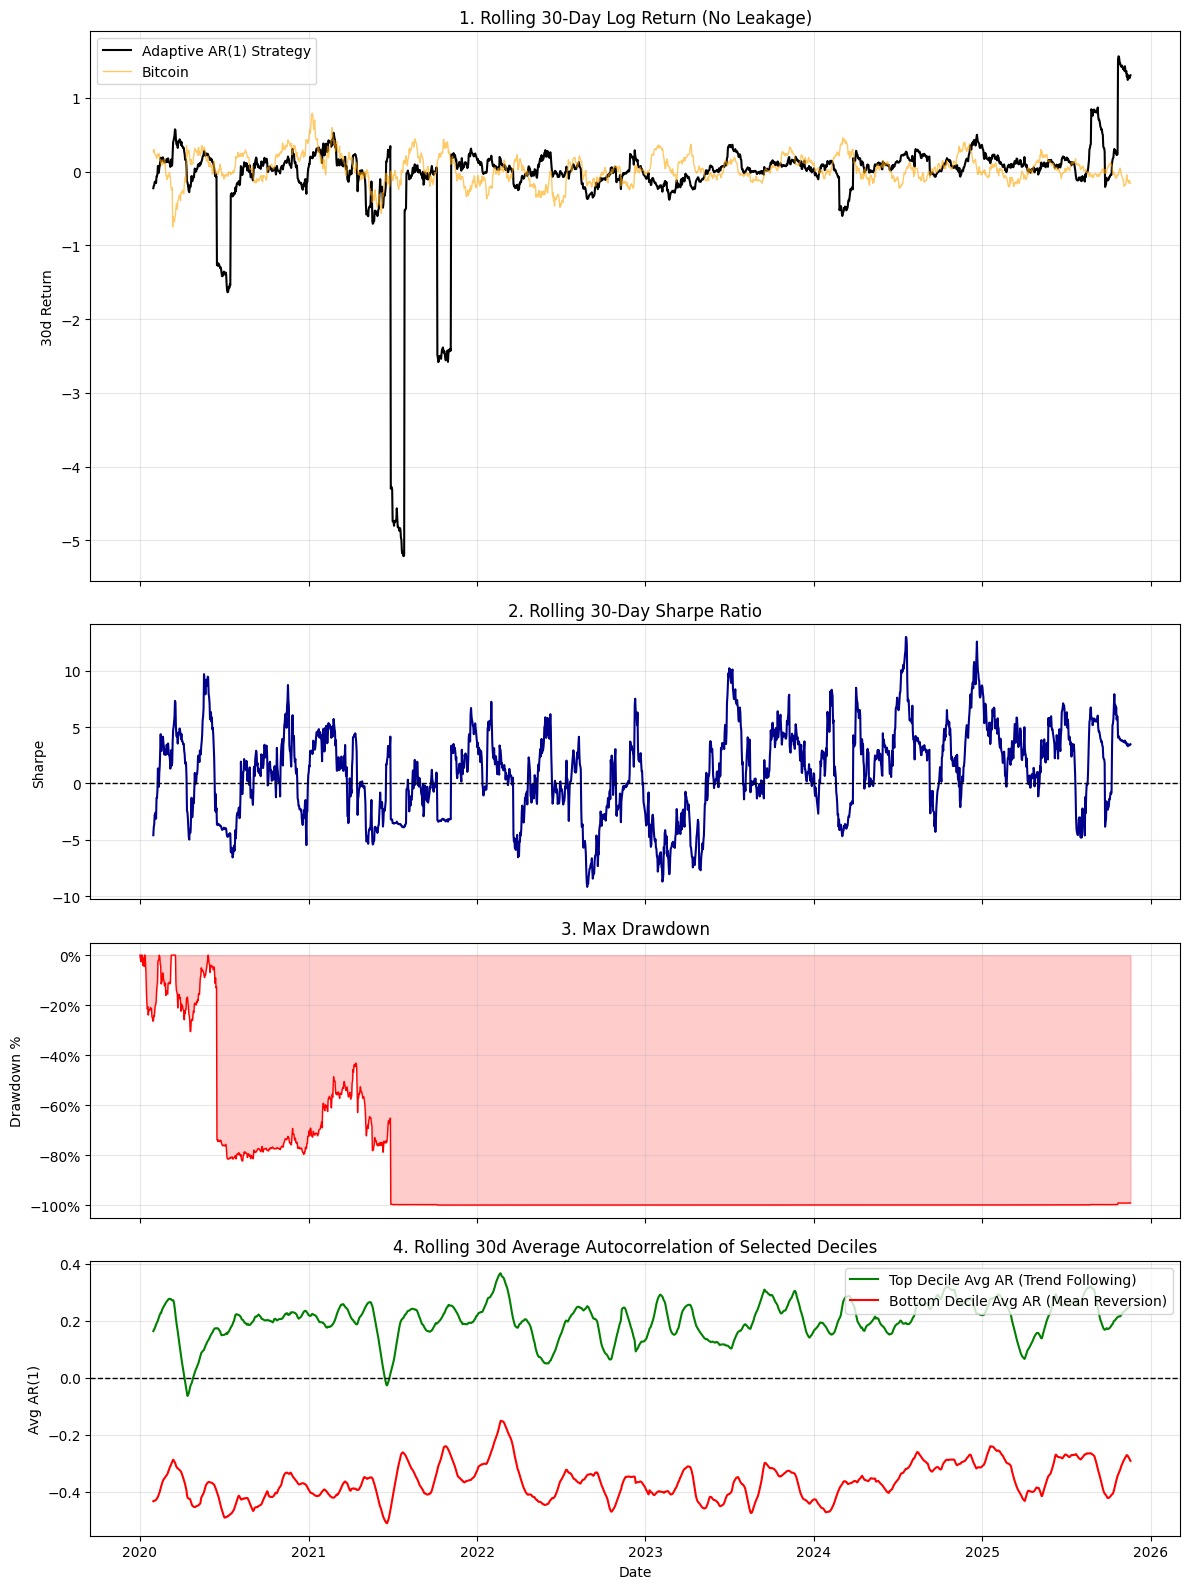

Total Return: -98.53%
Max Drawdown: -99.99%


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- CONFIGURATION ---
START_DATE = '2020-01-01'
WARMUP_DAYS = 60           # Buffer to calculate AR(1) before trading starts
ROLLING_WINDOW = 30        # For Sharpe/Exposure charts
FEE_RATE = 0.002           # 0.2% per trade (estimated)

# 1. Fetch Data (DuckDB / SQLite)
# We fetch data starting BEFORE 2020 to ensure signals are ready on day 1
df_raw = con.sql(f'''
    SELECT ts, symbol, close, volume
    FROM coins
    WHERE ts >= DATE '{START_DATE}' - INTERVAL {WARMUP_DAYS} DAY
    ORDER BY symbol, ts
''').df()

df_raw['ts'] = pd.to_datetime(df_raw['ts'])

# 2. Calculate Indicators (Pre-Shift)
# We calculate metrics based on TODAY'S close.
grouped = df_raw.groupby('symbol')
df_raw['ret'] = np.log(df_raw['close'] / df_raw['close'].shift(1))
df_raw['prev_ret'] = grouped['ret'].shift(1) # Return T-1

# Rolling AR(1): Correlation of Ret(T) and Ret(T-1) over last 30 days
# Note: This calculation technically "sees" the close of T.
def rolling_ar1(x):
    return x['ret'].rolling(window=30).corr(x['prev_ret'])

df_raw['ar1_raw'] = grouped.apply(rolling_ar1).reset_index(0, drop=True)

# 3. FIX LEAKAGE: Shift Signals to T+1
# Critical Step: We must trade Day T using ONLY data available at T-1 Close.
df_raw['signal_ar1'] = df_raw['ar1_raw'].shift(1)  # Yesterday's AR Regime
df_raw['signal_vol'] = df_raw['volume'].shift(1)   # Yesterday's Volume (for weighting)
df_raw['signal_mom'] = df_raw['ret'].shift(1)      # Yesterday's Return (for direction)

# 4. Filter for Backtest Period
df = df_raw[df_raw['ts'] >= pd.to_datetime(START_DATE)].copy()
# Remove rows where we don't have valid YESTERDAY signals
df.dropna(subset=['signal_ar1', 'signal_vol', 'signal_mom', 'ret'], inplace=True)

# 5. Strategy Logic
# Rank coins daily based on YESTERDAY'S AR(1)
df['ar_rank'] = df.groupby('ts')['signal_ar1'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
)

# --- Leg 1: Top Decile (High Autocorrelation -> Trending) ---
# Logic: Follow Momentum (If Yest was Up, Buy. If Yest was Down, Short)
top_decile = df[df['ar_rank'] == 9].copy()
top_decile['signal_dir'] = -1 * np.sign(top_decile['signal_mom']) 
# Weighting: Relative Volume of this bucket
top_decile['weight'] = top_decile['signal_vol'] / top_decile.groupby('ts')['signal_vol'].transform('sum')
top_decile['final_weight'] = top_decile['weight'] * 0.5  # 50% Allocation

# --- Leg 2: Bottom Decile (Low/Neg Autocorrelation -> Mean Reverting) ---
# Logic: Counter-Trade (If Yest was Up, Short. If Yest was Down, Buy)
bottom_decile = df[df['ar_rank'] == 0].copy()
bottom_decile['signal_dir'] = 1 * np.sign(bottom_decile['signal_mom'])
# Weighting: Relative Volume of this bucket
bottom_decile['weight'] = bottom_decile['signal_vol'] / bottom_decile.groupby('ts')['signal_vol'].transform('sum')
bottom_decile['final_weight'] = bottom_decile['weight'] * 0.5 # 50% Allocation

# Combine Legs
strat_df = pd.concat([top_decile, bottom_decile]).sort_values('ts')

# 6. Portfolio Construction & Returns
# Calculate Signed Weight (Long/Short)
strat_df['signed_weight'] = strat_df['signal_dir'] * strat_df['final_weight']

# Trade Return = Weight * Today's Realized Return
strat_df['trade_ret'] = strat_df['signed_weight'] * strat_df['ret']

# Aggregate Daily
daily_perf = strat_df.groupby('ts').agg({
    'trade_ret': 'sum',
    'signed_weight': 'sum'
}).rename(columns={'trade_ret': 'strat_ret_log', 'signed_weight': 'net_exposure'})

# Estimate Costs (Assumes ~40% daily turnover across the portfolio)
daily_perf['cost'] = FEE_RATE * 0.4 
daily_perf['net_strat_ret'] = daily_perf['strat_ret_log'] - daily_perf['cost']

# --- METRICS: Tracking the Average AR of our Selections ---
# We want to verify: Does the Top Decile actually have high AR?
# Calculate average Signal AR for Rank 9 and Rank 0 per day
avg_ar_by_rank = df.groupby(['ts', 'ar_rank'])['signal_ar1'].mean().unstack()
daily_perf['avg_ar_top'] = avg_ar_by_rank[9]
daily_perf['avg_ar_bottom'] = avg_ar_by_rank[0]

# Rolling 30d of these averages for smoother plotting
daily_perf['rolling_ar_top'] = daily_perf['avg_ar_top'].rolling(ROLLING_WINDOW).mean()
daily_perf['rolling_ar_bottom'] = daily_perf['avg_ar_bottom'].rolling(ROLLING_WINDOW).mean()


# 7. Benchmarking (BTC)
btc_df = df_raw[df_raw['symbol'] == 'btc'].set_index('ts')[['ret']].rename(columns={'ret': 'btc_ret'})
df_viz = pd.merge(daily_perf, btc_df, left_index=True, right_index=True, how='inner')

# 8. Rolling Stats for Visualization
df_viz['Strategy_30d'] = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).sum()
df_viz['BTC_30d'] = df_viz['btc_ret'].rolling(ROLLING_WINDOW).sum()

rolling_mean = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).mean()
rolling_std = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).std()
df_viz['Rolling_Sharpe'] = (rolling_mean / rolling_std) * np.sqrt(365)

# Max Drawdown
cum_ret = np.exp(df_viz['net_strat_ret'].cumsum())
running_max = cum_ret.cummax()
df_viz['Drawdown'] = (cum_ret - running_max) / running_max

# --- PLOTTING ---
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})

# Panel 1: Rolling Returns
axes[0].plot(df_viz.index, df_viz['Strategy_30d'], color='black', label='Adaptive AR(1) Strategy', linewidth=1.5)
axes[0].plot(df_viz.index, df_viz['BTC_30d'], color='orange', label='Bitcoin', alpha=0.6, linewidth=1)
axes[0].set_title('1. Rolling 30-Day Log Return (No Leakage)')
axes[0].set_ylabel('30d Return')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Panel 2: Sharpe Ratio
axes[1].plot(df_viz.index, df_viz['Rolling_Sharpe'], color='darkblue')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('2. Rolling 30-Day Sharpe Ratio')
axes[1].set_ylabel('Sharpe')
axes[1].grid(True, alpha=0.3)

# Panel 3: Drawdown
axes[2].plot(df_viz.index, df_viz['Drawdown'], color='red', linewidth=1)
axes[2].fill_between(df_viz.index, df_viz['Drawdown'], 0, color='red', alpha=0.2)
axes[2].set_title('3. Max Drawdown')
axes[2].set_ylabel('Drawdown %')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
axes[2].grid(True, alpha=0.3)

# Panel 4: Rolling AR(1) of Selected Portfolios
axes[3].plot(df_viz.index, df_viz['rolling_ar_top'], color='green', label='Top Decile Avg AR (Trend Following)', linewidth=1.5)
axes[3].plot(df_viz.index, df_viz['rolling_ar_bottom'], color='red', label='Bottom Decile Avg AR (Mean Reversion)', linewidth=1.5)
axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
axes[3].set_title('4. Rolling 30d Average Autocorrelation of Selected Deciles')
axes[3].set_ylabel('Avg AR(1)')
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Summary Print
print(f"Total Return: {cum_ret.iloc[-1]-1:.2%}")
print(f"Max Drawdown: {df_viz['Drawdown'].min():.2%}")

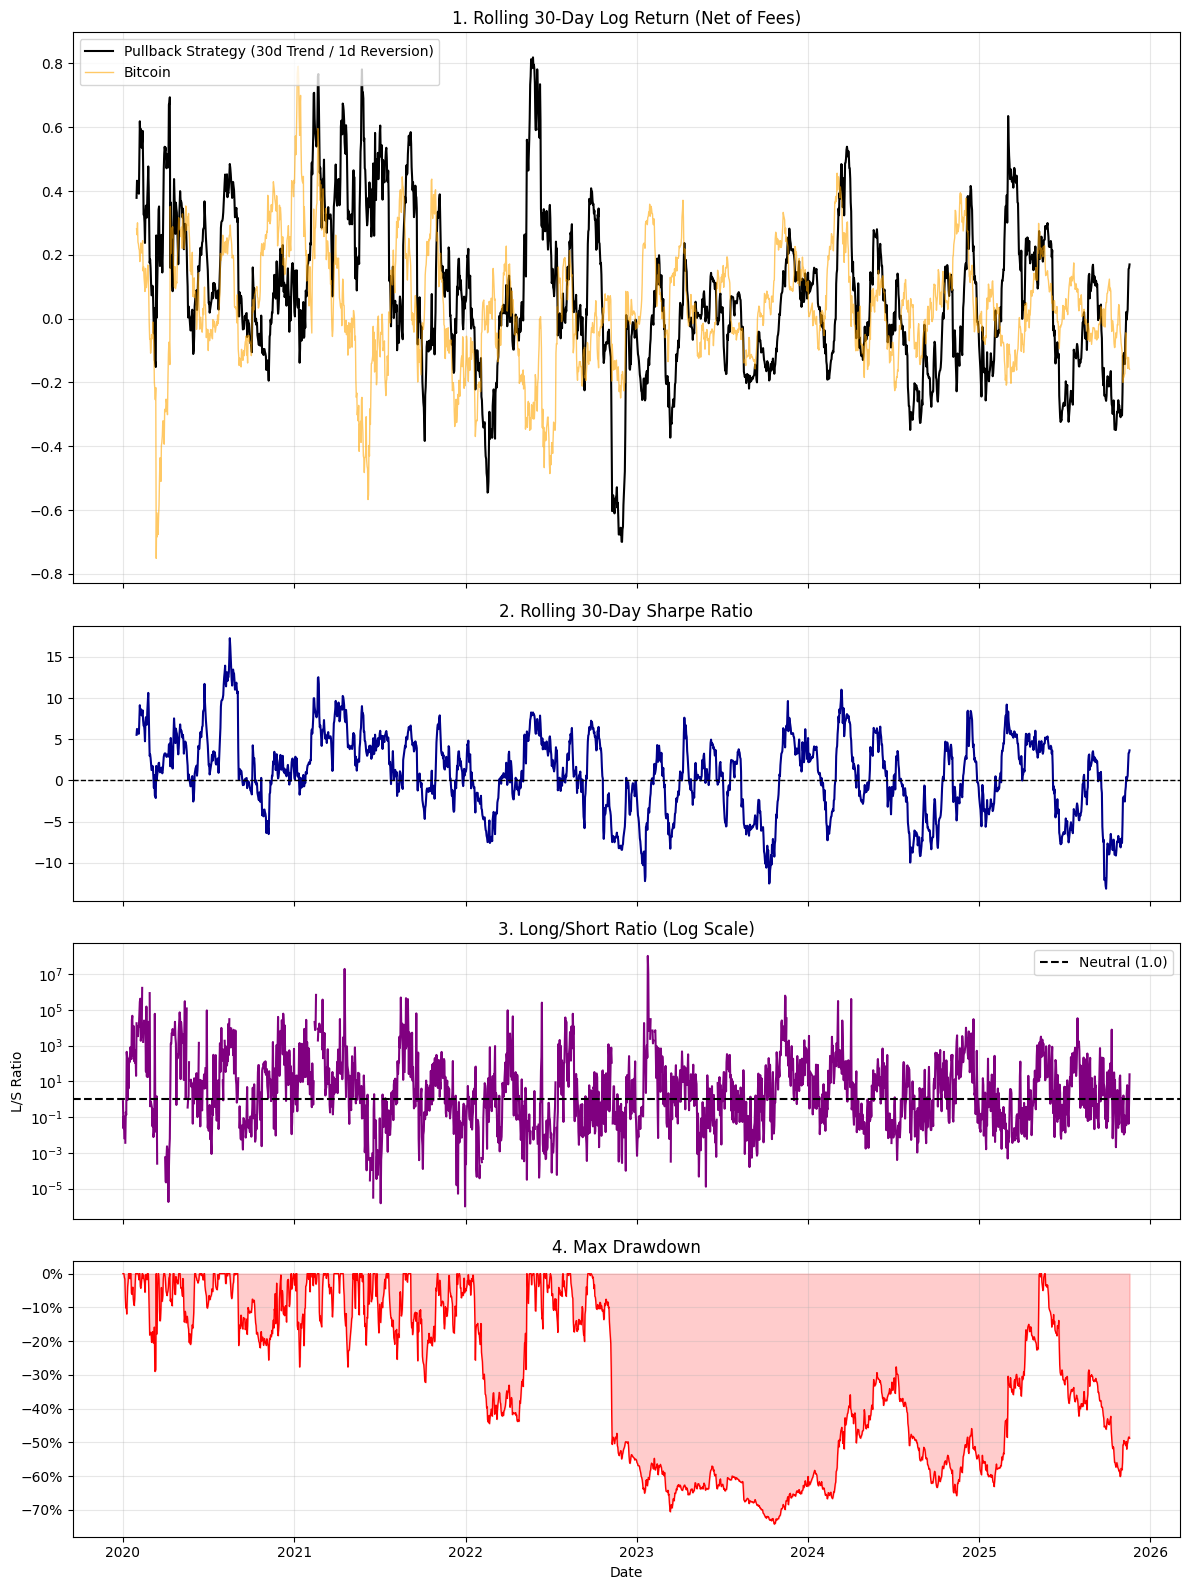

Total Return: 26178.26%
Avg Daily Turnover Cost: 0.0030 bps
Max Drawdown: -74.28%


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- CONFIGURATION ---
START_DATE = '2020-01-01'
WARMUP_DAYS = 60           # Buffer for 30d momentum calculation
ROLLING_WINDOW = 30
FEE_RATE = 0.002           # 0.2% per trade (applied to turnover)

# 1. Fetch Data
# We grab extra data before 2020 to have valid signals on Jan 1
df_raw = con.sql(f'''
    SELECT ts, symbol, close, volume
    FROM coins
    WHERE ts >= DATE '{START_DATE}' - INTERVAL {WARMUP_DAYS} DAY
    ORDER BY symbol, ts
''').df()
df_raw['ts'] = pd.to_datetime(df_raw['ts'])

# 2. Calculate Indicators (Pre-Shift)
grouped = df_raw.groupby('symbol')

# A. Realized Return (Target for Day T)
df_raw['ret'] = np.log(df_raw['close'] / grouped['close'].shift(1))

# B. Signals (Must be available at T-1)
# 1-Day Momentum (Yesterday's Return)
df_raw['mom_1d_raw'] = grouped['close'].pct_change(1)
# 30-Day Momentum (Return over last 30 days)
df_raw['mom_30d_raw'] = grouped['close'].pct_change(30)

# C. SHIFT SIGNALS (Critical for Leakage Prevention)
# We move T-1 data to row T.
df_raw['signal_mom1'] = grouped['mom_1d_raw'].shift(1)
df_raw['signal_mom30'] = grouped['mom_30d_raw'].shift(1)
df_raw['signal_vol'] = grouped['volume'].shift(1)

# 3. Filter for Backtest Period
df = df_raw[df_raw['ts'] >= pd.to_datetime(START_DATE)].copy()
df.dropna(subset=['signal_mom1', 'signal_mom30', 'signal_vol', 'ret'], inplace=True)

# 4. Strategy Logic: Pullback within Trend
# Condition: Sign(1d) != Sign(30d)
# Example: 30d is UP (+), 1d is DOWN (-). We Buy (+).
# Example: 30d is DOWN (-), 1d is UP (+). We Short (-).
condition = np.sign(df['signal_mom1']) != np.sign(df['signal_mom30'])

# Filter: Keep only coins matching the condition
strat_df = df[condition].copy()

# Direction: Follow the 30d Trend
strat_df['direction'] = np.sign(strat_df['signal_mom30'])

# Weighting: Relative Volume of selected coins
# "signal_vol" is yesterday's volume.
daily_vol_sum = strat_df.groupby('ts')['signal_vol'].transform('sum')
strat_df['raw_weight'] = strat_df['signal_vol'] / daily_vol_sum

# Signed Weight (Post-Direction)
strat_df['signed_weight'] = strat_df['raw_weight'] * strat_df['direction']

# 5. Calculate Costs (Precise Turnover Method)
# We need to see how much our weight changed from yesterday to today for each coin
# Note: We must pivot to handle the changing universe of selected coins correctly
weights_matrix = strat_df.pivot(index='ts', columns='symbol', values='signed_weight').fillna(0.0)

# Calculate change in weights (Turnover)
turnover_matrix = weights_matrix.diff().abs()
# For the first day, turnover is the full initial allocation
turnover_matrix.iloc[0] = weights_matrix.iloc[0].abs()

daily_turnover = turnover_matrix.sum(axis=1)
daily_cost = daily_turnover * FEE_RATE

# 6. Calculate Portfolio Returns
# Gross Return = Weight * Ret
strat_df['gross_ret'] = strat_df['signed_weight'] * strat_df['ret']
daily_gross = strat_df.groupby('ts')['gross_ret'].sum()

# Net Return = Gross - Cost
daily_perf = pd.DataFrame({
    'strat_ret_log': daily_gross,
    'cost': daily_cost
}).fillna(0.0)
daily_perf['net_strat_ret'] = daily_perf['strat_ret_log'] - daily_perf['cost']

# 7. Calculate Long/Short Ratio
# Sum of positive weights vs Sum of absolute negative weights
long_exposure = strat_df[strat_df['signed_weight'] > 0].groupby('ts')['signed_weight'].sum()
short_exposure = strat_df[strat_df['signed_weight'] < 0].groupby('ts')['signed_weight'].sum().abs()
daily_perf['ls_ratio'] = long_exposure / short_exposure

# 8. Benchmarking (BTC)
btc_df = df_raw[df_raw['symbol'] == 'btc'].set_index('ts')[['ret']].rename(columns={'ret': 'btc_ret'})
df_viz = pd.merge(daily_perf, btc_df, left_index=True, right_index=True, how='inner')

# 9. Rolling Metrics
df_viz['Strategy_30d'] = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).sum()
df_viz['BTC_30d'] = df_viz['btc_ret'].rolling(ROLLING_WINDOW).sum()

rolling_mean = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).mean()
rolling_std = df_viz['net_strat_ret'].rolling(ROLLING_WINDOW).std()
df_viz['Rolling_Sharpe'] = (rolling_mean / rolling_std) * np.sqrt(365)

cum_ret = np.exp(df_viz['net_strat_ret'].cumsum())
df_viz['Drawdown'] = (cum_ret - cum_ret.cummax()) / cum_ret.cummax()

# --- VISUALIZATION ---
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})

# Panel 1: Returns
axes[0].plot(df_viz.index, df_viz['Strategy_30d'], color='black', label='Pullback Strategy (30d Trend / 1d Reversion)', linewidth=1.5)
axes[0].plot(df_viz.index, df_viz['BTC_30d'], color='orange', label='Bitcoin', alpha=0.6, linewidth=1)
axes[0].set_title('1. Rolling 30-Day Log Return (Net of Fees)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Panel 2: Sharpe
axes[1].plot(df_viz.index, df_viz['Rolling_Sharpe'], color='darkblue')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('2. Rolling 30-Day Sharpe Ratio')
axes[1].grid(True, alpha=0.3)

# Panel 3: Long/Short Ratio
axes[2].plot(df_viz.index, df_viz['ls_ratio'], color='purple', linewidth=1.5)
axes[2].axhline(1, color='black', linestyle='--', label='Neutral (1.0)')
axes[2].set_yscale('log') # Log scale because ratios can get large
axes[2].set_title('3. Long/Short Ratio (Log Scale)')
axes[2].set_ylabel('L/S Ratio')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# Panel 4: Drawdown
axes[3].plot(df_viz.index, df_viz['Drawdown'], color='red', linewidth=1)
axes[3].fill_between(df_viz.index, df_viz['Drawdown'], 0, color='red', alpha=0.2)
axes[3].set_title('4. Max Drawdown')
axes[3].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
axes[3].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Stats
print(f"Total Return: {cum_ret.iloc[-1]-1:.2%}")
print(f"Avg Daily Turnover Cost: {daily_perf['cost'].mean():.4f} bps")
print(f"Max Drawdown: {df_viz['Drawdown'].min():.2%}")